# Time-Series Forecasting: Prédictions récursives des valeurs du SP500 sur 100 jours

Attention : l'exécution de ce notebook prend plusieurs heures même avec un bon processeur et carte graphique, merci de vous armer de patience si vous souhaitez exécuter ce notebook. L'utilisation de carte graphique récente dédiée (voir spécialisé type Nvidia A100) est fortement recommandé

In [18]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Add, Conv1D, MultiHeadAttention, Dropout, Bidirectional
from tensorflow.keras.models import Model 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from itertools import product
from keras.callbacks import EarlyStopping
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import acf, pacf
from math import sqrt
from skopt import gp_minimize
from skopt.space import Integer
import optuna
import plotly
from tensorflow.keras.layers import Attention
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2, l1_l2
from datetime import datetime, timedelta
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.ndimage import gaussian_filter1d
from scipy.stats import kurtosis, skew
from statsmodels.tsa.stattools import adfuller
from keras import backend as K
from joblib import dump, load
from statsmodels.tsa.stattools import adfuller

In [2]:
print(tf.config.experimental.list_physical_devices('GPU'))
print(torch.cuda.is_available())
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Utiliser le premier GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
# Calculer la date d'hier
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.strftime('%Y-%m-%d')
# import the data
GSPC_data= yf.download('^GSPC',start='2001-06-25',end=yesterday_str)
VIX_data = yf.download('^VIX', start='2001-06-25', end=yesterday_str)
CL_DF_data = yf.download('CL=F', start='2001-06-25', end=yesterday_str)
GC_F_data = yf.download('GC=F', start='2001-06-25', end=yesterday_str)
EURUSD_X_data = yf.download('EURUSD=X', start='2001-06-25', end=yesterday_str)
GBPUSD_X_data = yf.download('GBPUSD=X', start='2001-06-25', end=yesterday_str)
JPY_X_data = yf.download('JPY=X', start='2001-06-25', end=yesterday_str)
RUB_X_data = yf.download('RUB=X', start='2001-06-25', end=yesterday_str)
NG_F_data = yf.download('NG=F', start='2001-06-25', end=yesterday_str)
TNX_data = yf.download('^TNX', start='2001-06-25', end=yesterday_str)
FVX_data = yf.download('^FVX', start='2001-06-25', end=yesterday_str)
FCHI_data = yf.download('^FCHI', start='2001-06-25', end=yesterday_str)
DJI_data = yf.download('^DJI', start='2001-06-25', end=yesterday_str)
JPM_data = yf.download('JPM', start='2001-06-25', end=yesterday_str)
CNY_X_data = yf.download('CNY=X', start='2001-06-25', end=yesterday_str)
SZ_data = yf.download('399001.SZ', start='2001-06-25', end=yesterday_str)
SS_data = yf.download('000001.SS', start='2001-06-25', end=yesterday_str)
MXX_data = yf.download('^MXX', start='2001-06-25', end=yesterday_str)
BVSP_data = yf.download('^BVSP', start='2001-06-25', end=yesterday_str)
N225_data = yf.download('^N225', start='2001-06-25', end=yesterday_str)
HSI_data = yf.download('^HSI', start='2001-06-25', end=yesterday_str)
STI_data = yf.download('^STI', start='2001-06-25', end=yesterday_str)
BSESN_data = yf.download('^BSESN', start='2001-06-25', end=yesterday_str)
TSM_data = yf.download('TSM', start='2001-06-25', end=yesterday_str) 
ORAPA_data = yf.download('ORA.PA', start='2001-06-25', end=yesterday_str)
VZ_data = yf.download('VZ', start='2001-06-25', end=yesterday_str)
VODL_data = yf.download('VOD.L', start='2001-06-25', end=yesterday_str) 
ADBE_data = yf.download('ADBE', start='2001-06-25', end=yesterday_str)
AAPL_data = yf.download('AAPL', start='2001-06-25', end=yesterday_str)
MSFT_data = yf.download('MSFT', start='2001-06-25', end=yesterday_str)
ORCL_data = yf.download('ORCL', start='2001-06-25', end=yesterday_str)
IBM_data = yf.download('IBM', start='2001-06-25', end=yesterday_str)
INTC_data = yf.download('INTC', start='2001-06-25', end=yesterday_str)
QCOM_data = yf.download('QCOM', start='2001-06-25', end=yesterday_str)
NVDA_data = yf.download('NVDA', start='2001-06-25', end=yesterday_str)
AMZN_data = yf.download('AMZN', start='2001-06-25', end=yesterday_str)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [4]:
GSPC_data.shape

(5602, 6)

Text(0.5, 1.0, 'Closing price History')

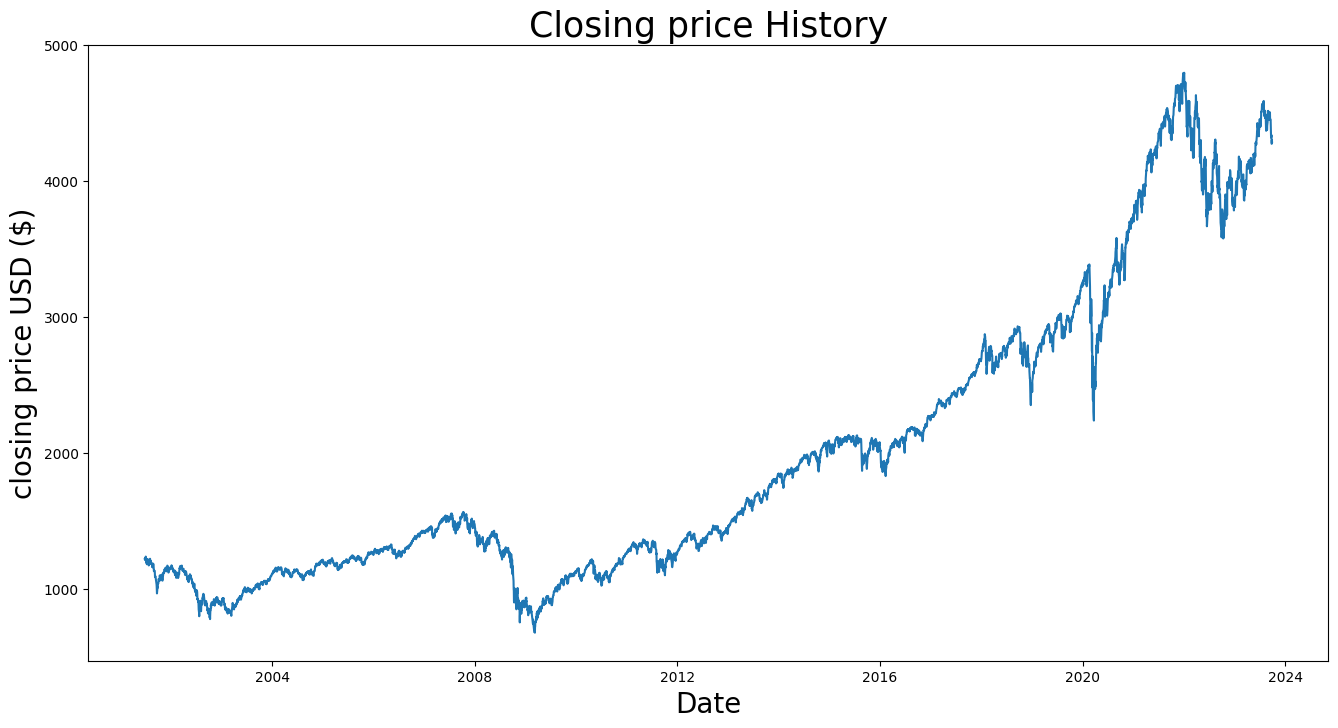

In [5]:
#lets look at the stock closing price of history
plt.figure(figsize=(16,8))
sns.lineplot(x= GSPC_data.index,y=GSPC_data['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('closing price USD ($)',fontsize=20)
plt.title('Closing price History',fontsize=25)

In [6]:
# Liste de vos DataFrames et leurs noms
dataframes = [GSPC_data, VIX_data, CL_DF_data, GC_F_data, EURUSD_X_data, GBPUSD_X_data, JPY_X_data, RUB_X_data, NG_F_data, TNX_data, FVX_data, FCHI_data, DJI_data, CNY_X_data, SZ_data, SS_data, MXX_data, BVSP_data, N225_data, HSI_data, STI_data, BSESN_data, TSM_data, ORAPA_data, VZ_data, VODL_data, ADBE_data, AAPL_data, MSFT_data, ORCL_data, IBM_data, INTC_data, QCOM_data, NVDA_data, AMZN_data]
names = ['GSPC', 'VIX', 'CL_DF', 'GC_F', 'EURUSD_X', 'GBPUSD_X', 'JPY_X', 'RUB_X', 'NG_F', 'TNX', 'FVX', 'FCHI', 'DJI', 'CNY_X', 'SZ', 'SS', 'MXX', 'BVSP', 'N225', 'HSI', 'STI', 'BSESN', 'TSM', 'ORAPA', 'VZ', 'VODL', 'ADBE', 'AAPL', 'MSFT', 'ORCL', 'IBM', 'INTC', 'QCOM', 'NVDA', 'AMZN']

# Initialiser un DataFrame vide
combined_data = pd.DataFrame()

# Parcourir chaque DataFrame et ajouter ses colonnes au DataFrame combiné
for df, name in zip(dataframes, names):
    # Sélectionnez seulement les colonnes qui vous intéressent (Open, Close, Min, Max)
    selected_columns = df[['Open', 'Close', 'Low', 'High']]
    
    # Renommez les colonnes pour inclure le nom de l'indice
    selected_columns.columns = pd.MultiIndex.from_product([[name], ['Open', 'Close', 'Low', 'High']])
    
    # Concaténez les colonnes sélectionnées au DataFrame combiné
    if combined_data.empty:
        combined_data = selected_columns
    else:
        combined_data = pd.concat([combined_data, selected_columns], axis=1)

combined_data.dropna(inplace=True)
# Affichez les premières lignes du DataFrame combiné
print(combined_data.shape)

(3677, 140)


### Carte de chaleur de correlation entre les features du modèle:

In [7]:
# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

### Sélection des features

In [8]:
# Sélectionner les caractéristiques avec une forte corrélation
target = ('GSPC', 'Close')
correlation_threshold = 0.8

# Trouver les caractéristiques fortement corrélées
highly_correlated_features = [idx for idx, corr in correlation_matrix[target].items() if abs(corr) > correlation_threshold]

print(f"Selected indices: {highly_correlated_features}")

Selected indices: [('GSPC', 'Open'), ('GSPC', 'Close'), ('GSPC', 'Low'), ('GSPC', 'High'), ('RUB_X', 'Open'), ('RUB_X', 'Close'), ('RUB_X', 'Low'), ('RUB_X', 'High'), ('FCHI', 'Open'), ('FCHI', 'Close'), ('FCHI', 'Low'), ('FCHI', 'High'), ('DJI', 'Open'), ('DJI', 'Close'), ('DJI', 'Low'), ('DJI', 'High'), ('BVSP', 'Open'), ('BVSP', 'Close'), ('BVSP', 'Low'), ('BVSP', 'High'), ('N225', 'Open'), ('N225', 'Close'), ('N225', 'Low'), ('N225', 'High'), ('BSESN', 'Open'), ('BSESN', 'Close'), ('BSESN', 'Low'), ('BSESN', 'High'), ('TSM', 'Open'), ('TSM', 'Close'), ('TSM', 'Low'), ('TSM', 'High'), ('ADBE', 'Open'), ('ADBE', 'Close'), ('ADBE', 'Low'), ('ADBE', 'High'), ('AAPL', 'Open'), ('AAPL', 'Close'), ('AAPL', 'Low'), ('AAPL', 'High'), ('MSFT', 'Open'), ('MSFT', 'Close'), ('MSFT', 'Low'), ('MSFT', 'High'), ('ORCL', 'Open'), ('ORCL', 'Close'), ('ORCL', 'Low'), ('ORCL', 'High'), ('QCOM', 'Open'), ('QCOM', 'Close'), ('QCOM', 'Low'), ('QCOM', 'High'), ('NVDA', 'Open'), ('NVDA', 'Close'), ('NVDA',

### Gestion de la Multicollinéarité

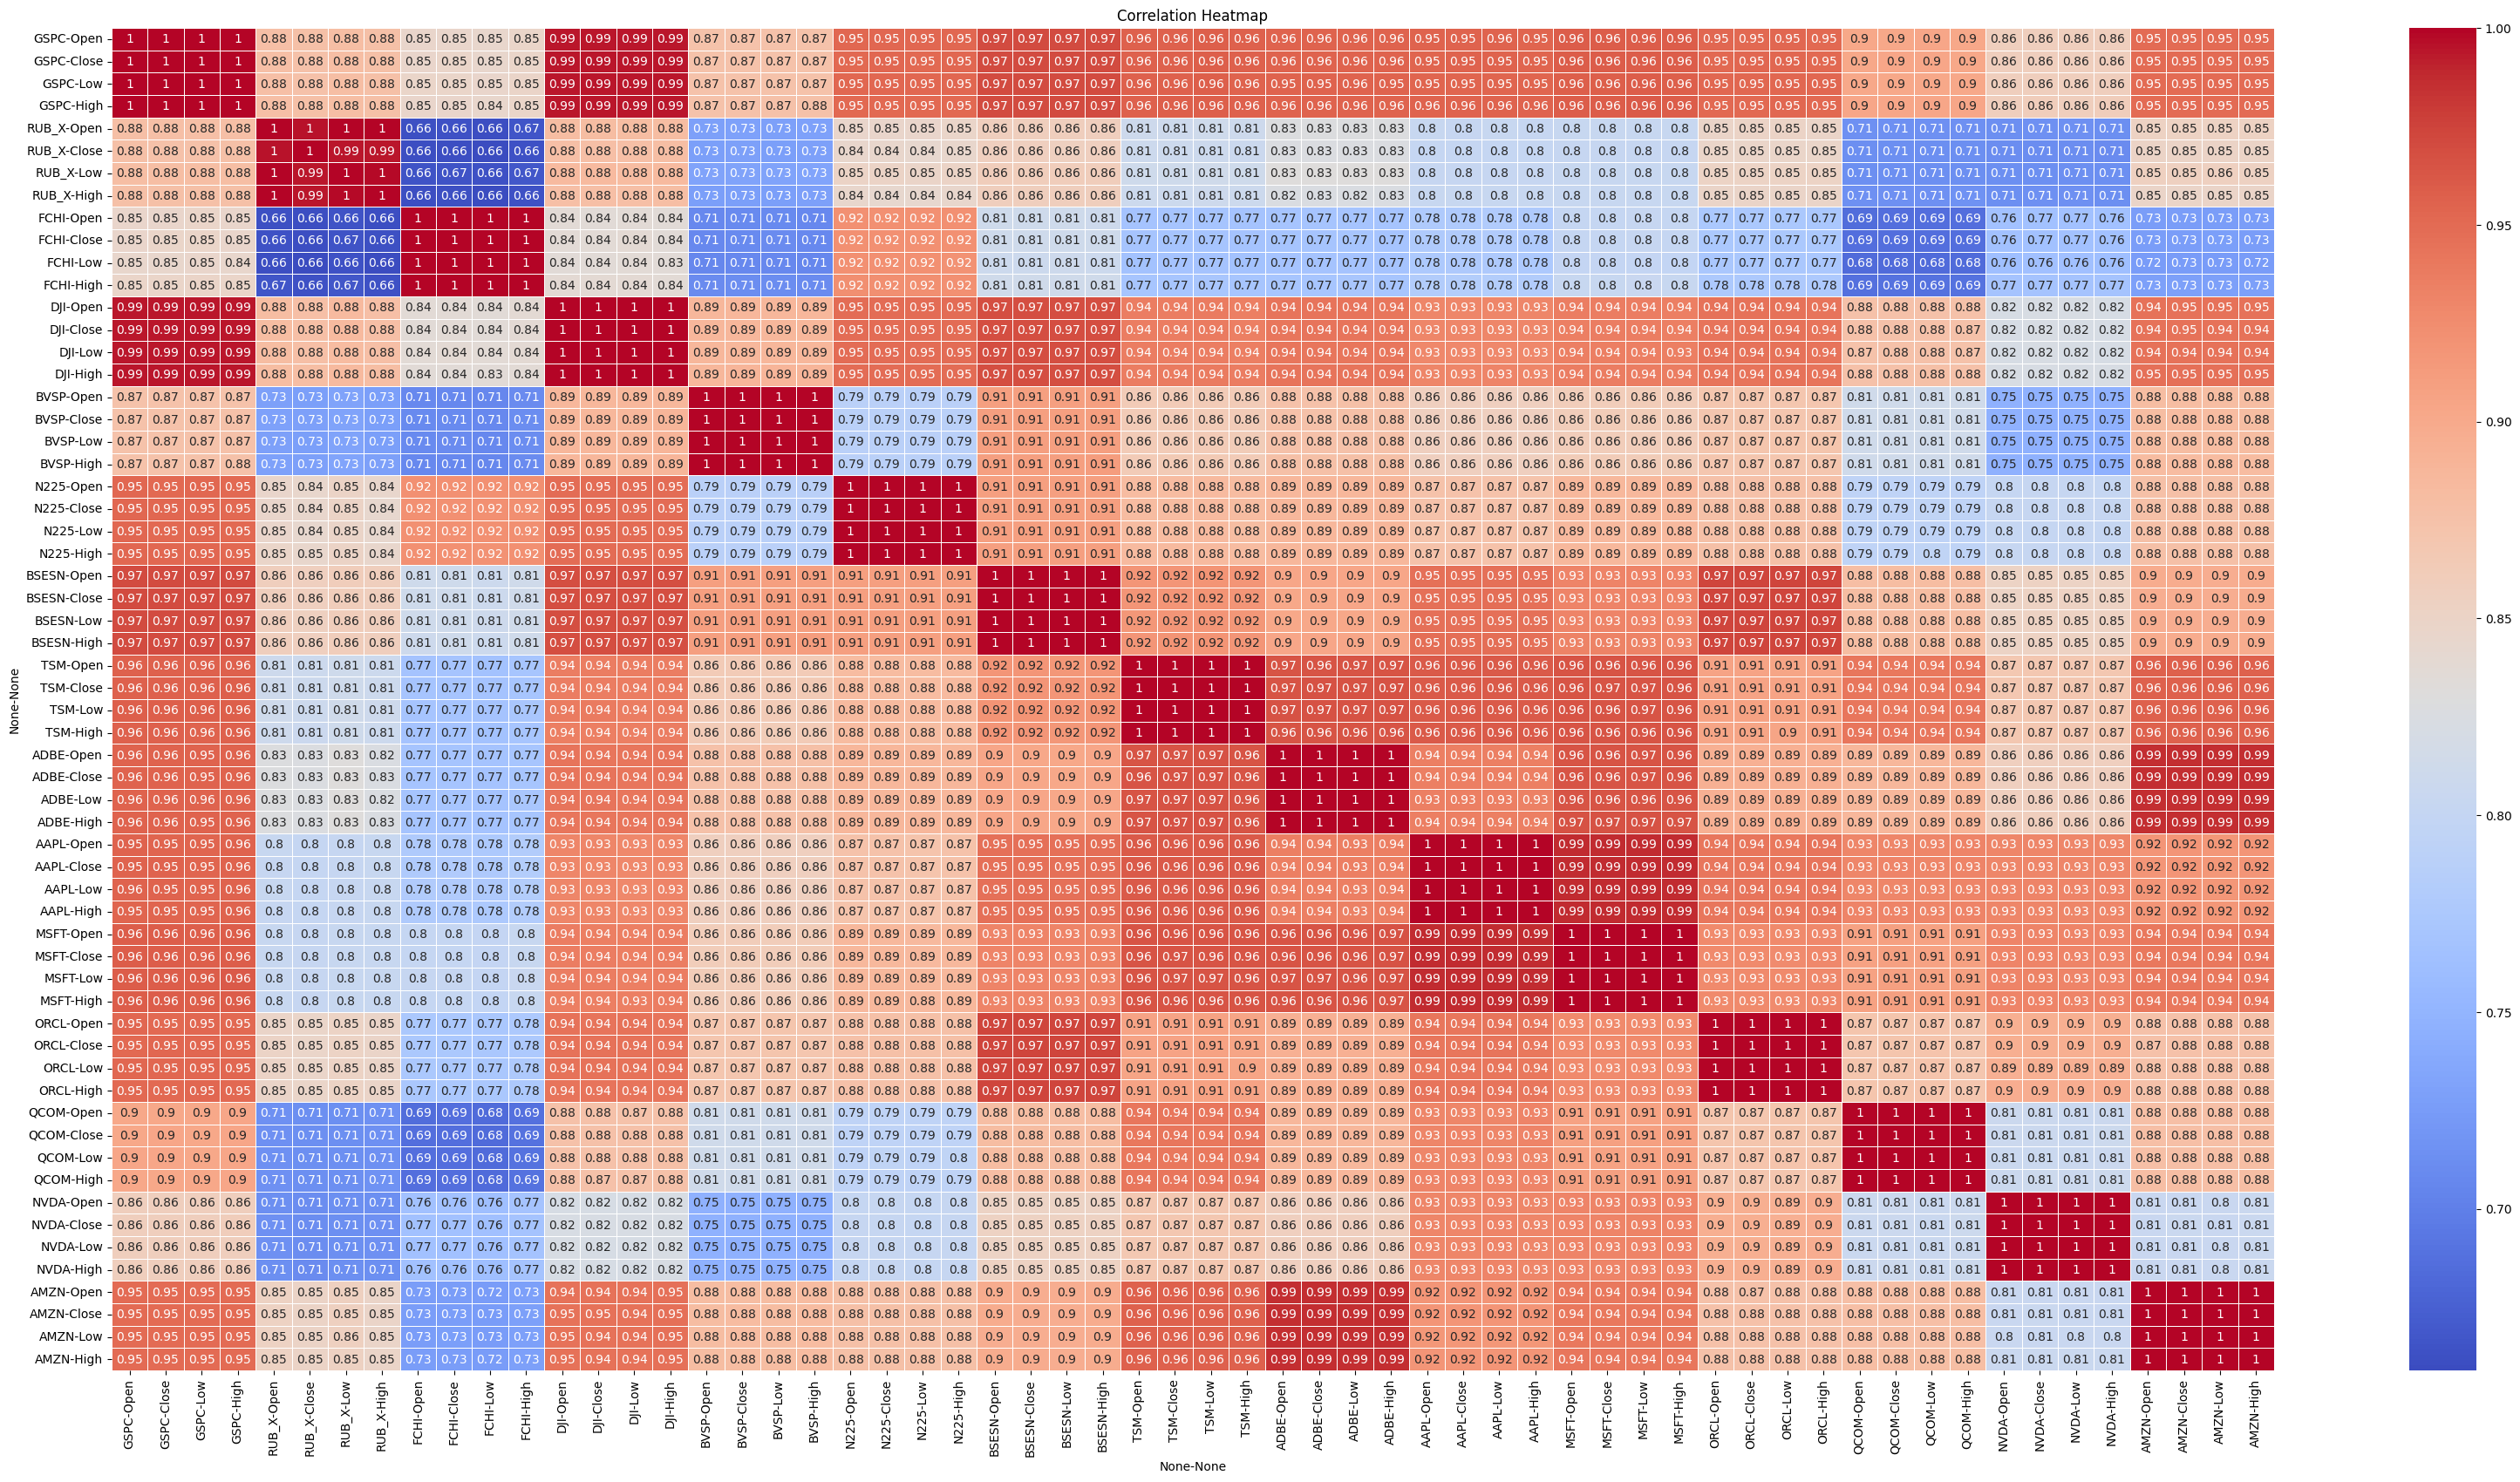

In [9]:
# Afficher la heatmap
selected_correlation_matrix = combined_data[highly_correlated_features].corr()

plt.figure(figsize=(40, 20))
sns.heatmap(selected_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
# Calculate VIF
def calculate_vif(dataframe, threshold=4.0):
    vif = pd.DataFrame()
    vif["Variable"] = [str(col) for col in dataframe.columns]
    vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    
    while vif["VIF"].max() > threshold:
        remove = vif.sort_values("VIF", ascending=False).iloc[0]
        removed_var = dataframe.columns[int(remove.name)]
        dataframe = dataframe.drop(removed_var, axis=1)
        vif = pd.DataFrame()
        vif["Variable"] = [str(col) for col in dataframe.columns]
        vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]

    return dataframe

### Sélection des features définitives:

In [11]:
#highly_correlated_features.remove(target)
filtred_df = combined_data[highly_correlated_features].copy()
# Extraire les valeurs de clôture pour chaque indice
close_values_df = combined_data.xs('Close', level=1, axis=1)

# Calculer le VIF sur ces valeurs
reduced_df = calculate_vif(close_values_df)

# Conserver seulement les indices qui ne sont pas colinéaires
valid_indices = reduced_df.columns.tolist()

# Créer un nouveau DataFrame contenant toutes les variables pour ces indices
final_df = combined_data.loc[:, pd.IndexSlice[valid_indices, :]]
print(final_df.shape)

(3677, 12)


### Normalisation des données

In [12]:
# Initialisez un dictionnaire pour stocker les scalers
scalers_dict = {}

# Créez un DataFrame vide pour stocker les données mises à l'échelle
scaled_data_df = pd.DataFrame(index=final_df.index)

# Itérer sur le premier niveau de l'index multi-niveaux (noms des indices)
for first_level in final_df.columns.levels[0]:
    # Itérer sur le second niveau de l'index multi-niveaux (Open, Close, High, Low)
    for second_level in final_df.columns.levels[1]:
        feature = (first_level, second_level)
        
        if feature in final_df.columns:
            feature_scaler = RobustScaler()
            scaled_feature = feature_scaler.fit_transform(final_df[feature].values.reshape(-1, 1))
            scaled_data_df[feature] = scaled_feature.flatten()  # Convertir les données 2D en 1D
            
            # Stocker le scaler pour chaque combinaison d'indice et de mesure
            scalers_dict[feature] = feature_scaler

print(scaled_data_df.head())

            (FVX, Close)  (FVX, High)  (FVX, Low)  (FVX, Open)  (NVDA, Close)  \
Date                                                                            
2003-12-01      0.837719     0.842788    0.836656     0.803038      -0.075414   
2003-12-02      0.822368     0.833603    0.848283     0.824742      -0.075573   
2003-12-03      0.837719     0.816315    0.831672     0.824742      -0.075960   
2003-12-04      0.810855     0.821718    0.835548     0.844276      -0.076154   
2003-12-05      0.707237     0.721232    0.722038     0.714596      -0.077351   

            (NVDA, High)  (NVDA, Low)  (NVDA, Open)  (VIX, Close)  \
Date                                                                
2003-12-01     -0.076776    -0.076864     -0.076735      0.003405   
2003-12-02     -0.076447    -0.076701     -0.076859     -0.053348   
2003-12-03     -0.075892    -0.076955     -0.076682     -0.012486   
2003-12-04     -0.076811    -0.077973     -0.077054     -0.049943   
2003-12-05     -0.

In [13]:
# Split into train and test:
# Définissez la taille de l'ensemble d'entraînement
train_size = int(len(scaled_data_df)) - 200
test_size = 200

# Séparez les données
train_data = scaled_data_df.iloc[:train_size]
test_data = scaled_data_df.iloc[train_size:]
print(train_data.shape)
print(test_data.shape)

(3477, 12)
(200, 12)


In [14]:
#Now, we can save the 2 csv files, Train and Test.
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

### Création d'une métrique personalisée pour la prédiction récursive 

In [15]:
def weighted_rmse(y_true, y_pred, total_observations):
    weights = np.arange(total_observations, 0, -1) / total_observations
    weighted_square_errors = weights * ((y_pred - y_true) ** 2)
    weighted_rmse = sqrt(np.mean(weighted_square_errors))
    return weighted_rmse
    
    weighted_square_errors = weights * ((y_pred - y_true) ** 2)
    weighted_rmse = sqrt(np.mean(weighted_square_errors))
    return weighted_rmse

#création d'un test pour éviter les modèles à prédictions récursives stationnaires
def adf_test(series):
    if np.all(series == series[0]):  # Vérifie si tous les éléments sont identiques
        return False  # Vous pouvez considérer que c'est non-stationnaire ou inapproprié pour vos besoins
    result = adfuller(series)
    return result[1] <= 0.10

# Recherche de la meilleure architecture pour les modèles neuronaux

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
best_params_per_feature = {}
top_n_trials_per_feature = {}

# Function to create sequences for multi-output prediction

def create_single_output_sequences(data, index_name, look_back=1):
    X, y = [], []
    feature_columns = ['Close']
    for i in range(look_back, len(data)):
        sequence_data = data.loc[data.index[i-look_back:i], [(index_name, col) for col in feature_columns]].values
        X.append(sequence_data)
        y.append(data.loc[data.index[i], [(index_name, 'Close')]].values[0])
    return np.array(X), np.array(y)

def generate_recursive_predictions(model, X_val, n_steps=10):
    # Supposons que X_val soit de forme (nombre_d'exemples, look_back, nombre_de_features)
    recursive_predictions = []
    input_sequence = X_val[0].reshape(1, X_val.shape[1], X_val.shape[2])  # Prendre la première séquence

    for i in range(n_steps):
        # Faire une prédiction à partir de la séquence d'entrée
        prediction = model.predict(input_sequence, verbose=0)
        recursive_predictions.append(prediction[0, 0])

        # Mettre à jour la séquence d'entrée pour inclure la nouvelle prédiction
        new_input_sequence = np.append(input_sequence[0, 1:, :], prediction)
        input_sequence = new_input_sequence.reshape(1, X_val.shape[1], X_val.shape[2])

    return np.array(recursive_predictions)


def create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, input_shape, use_conv1d , conv1d_filters ,conv1d_kernel_size ,use_residual_connection, attention_layer, l1_reg, l2_reg):
    inputs = Input(shape=input_shape)
    x = inputs
    if use_conv1d:
        x = Conv1D(conv1d_filters, kernel_size=conv1d_kernel_size, activation='relu')(x)
    if layer_type[0] == "GRU":
        x = Bidirectional(GRU(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    elif layer_type[0] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    x = Dropout(dropout_per_layer[0])(x)
    for i in range(1, num_layers):
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x_res = x
        if layer_type[i] == "GRU":
            x = Bidirectional(GRU(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        elif layer_type[i] == "LSTM":
            x = Bidirectional(LSTM(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        x = Dropout(dropout_per_layer[i])(x)
        if attention_layer:
            x = Attention(use_scale=True)([x, x])
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x = Add()([x, x_res])
    if layer_type[num_layers-1] == "GRU":
        x = Bidirectional(GRU(units_per_layer[num_layers-1]))(x)
    elif layer_type[num_layers-1] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[num_layers-1]))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

for index_name in final_df.columns.get_level_values(0).unique():  # Parcourir chaque indice

    # Définition de l'objectif
    def objective(trial):

        # Espace de recherche
        ###############################################################################################
        look_back = trial.suggest_int('look_back', int(test_size/4), int(test_size/2) - 1)
        num_layers = trial.suggest_int('num_layers', 5, 8)
        layer_type = [trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) for i in range(num_layers)]
        units_per_layer = [trial.suggest_int(f'units_power_{i}', 7, 9) for i in range(num_layers)]
        units_per_layer = [2 ** power for power in units_per_layer]
        dropout_per_layer = [trial.suggest_float(f'dropout_{i}', 0.1, 0.3) for i in range(num_layers)]
        use_residual_connection = trial.suggest_categorical('use_residual_connection', [True, False])
        attention_layer = trial.suggest_categorical('use_attention_layer', [True, False])
        use_conv1d = trial.suggest_categorical('use_conv1d', [False, True])
        if use_conv1d:
            conv1d_filters = trial.suggest_int('conv1d_filters', 5, 7)
            conv1d_filters = 2 ** conv1d_filters
            conv1d_kernel_size = trial.suggest_int('conv1d_kernel_size', 3, 7)
        l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
        l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
        ################################################################################################

        # Créez des séquences en utilisant look_back
        X_train, y_train = create_single_output_sequences(train_data, index_name , look_back)
        X_test, y_test = create_single_output_sequences(test_data, index_name ,look_back)

        n_splits = 5  # Nombre de splits
        tscv = TimeSeriesSplit(n_splits=n_splits)

        val_loss_list = []  # Liste pour stocker la val_loss de chaque split
        mda_list = []  # Liste pour stocker MDA de chaque split
        train_loss_list = []  # Liste pour stocker la loss de chaque split

        for train_index, val_index in tscv.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            if use_conv1d:
                model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), 1), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)
            else:
                conv1d_filters = 36
                conv1d_kernel_size = 5
                model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), 1), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)

            history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=10, batch_size=64, verbose=0, callbacks=[early_stopping])

            last_val_loss = history.history['val_loss'][-1]
            last_train_loss = history.history['loss'][-1]
            
            # Calcul de MDA
            y_true_direction = np.sign(np.diff(y_val_fold.reshape(-1)))  # vrai direction
            y_pred_direction = np.sign(np.diff(model.predict(X_val_fold, verbose=0).reshape(-1)))  # prédiction de direction
            mda = np.mean(y_true_direction == y_pred_direction)
            
            val_loss_list.append(last_val_loss)
            train_loss_list.append(last_train_loss)
            mda_list.append(mda)
        
        mean_val_loss = np.mean(val_loss_list)
        mean_train_loss = np.mean(train_loss_list)
        mean_mda = np.mean(mda_list)
        
        
        # Calcul des malus
        loss_difference_malus = abs(mean_val_loss - mean_train_loss) * 1
        recursive_predictions = generate_recursive_predictions(model, X_val_fold, len(X_val_fold))
        if np.all(recursive_predictions == recursive_predictions[0]):
            adf_malus = 3
        else:
            adf_result = adfuller(recursive_predictions)
            adf_malus = (1 - adf_result[1]) * 2

        # Calcul du score final avec les malus
        final_score = (1-mean_mda) + loss_difference_malus + adf_malus
        
        print("mda: " + str(mean_mda))
        print("loss diff: " + str(loss_difference_malus))
        print("adf: " + str(adf_malus))

        return final_score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=35)
    
    best_params_per_feature[index_name] = study.best_params

    top_n_trials = sorted(study.trials, key=lambda trial: trial.value)[:5]

    # Stockez les meilleurs hyperparamètres
    top_n_params = [trial.params for trial in top_n_trials]

    # Stockez ces meilleurs paramètres dans le dictionnaire
    top_n_trials_per_feature[index_name] = top_n_params

    # Affichage des résultats
    print(f'Number of finished trials for {index_name}: ', len(study.trials))
    print('Best 5 trials:')
    for i, trial in enumerate(top_n_trials):
        print(f'Rank {i+1} - Value: {trial.value}, Params: {trial.params}')

[I 2023-10-02 00:16:59,605] A new study created in memory with name: no-name-2a71bc05-24f9-4138-b142-d58cd4d8187b
[I 2023-10-02 00:23:45,104] Trial 0 finished with value: 4.890815223316422 and parameters: {'look_back': 73, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.2080100053657249, 'dropout_1': 0.2118439794965759, 'dropout_2': 0.2402387621024298, 'dropout_3': 0.2516776611190943, 'dropout_4': 0.2706527514006851, 'dropout_5': 0.2760180296972663, 'dropout_6': 0.17381497058466597, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.008849417166156923, 'l2_reg': 0.00015286929795557596}. Best is trial 0 with value: 4.890815223316422.


mda: 0.12190812720848059
loss diff: 0.012723350524902699
adf: 4


[I 2023-10-02 00:31:57,997] Trial 1 finished with value: 3.3491697736718833 and parameters: {'look_back': 91, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 8, 'units_power_7': 8, 'dropout_0': 0.285158638122157, 'dropout_1': 0.1643704528852742, 'dropout_2': 0.2547344896221401, 'dropout_3': 0.21676267125765133, 'dropout_4': 0.16593899351831223, 'dropout_5': 0.15586528938571506, 'dropout_6': 0.2820072940934306, 'dropout_7': 0.10520653306704982, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.01196285095011311, 'l2_reg': 0.0078075731969858096}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.22202486678507993
loss diff: 0.7165798187255881
adf: 1.8546148217313752


[I 2023-10-02 00:38:15,197] Trial 2 finished with value: 4.643930412265524 and parameters: {'look_back': 75, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.1759839058626282, 'dropout_1': 0.14919034220801158, 'dropout_2': 0.2616681999979149, 'dropout_3': 0.16414648428146925, 'dropout_4': 0.26722976020641365, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.02564798120996467, 'l2_reg': 0.014810895700165607}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4872791519434629
loss diff: 0.13120956420898722
adf: 4


[I 2023-10-02 00:44:36,208] Trial 3 finished with value: 5.616943604592248 and parameters: {'look_back': 60, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.18906430438593436, 'dropout_1': 0.1305228186163088, 'dropout_2': 0.1419417812675721, 'dropout_3': 0.2838314065875799, 'dropout_4': 0.12472030037385602, 'dropout_5': 0.24195460307546132, 'dropout_6': 0.16179069469117707, 'dropout_7': 0.21796747990899829, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.033765296617961044, 'l2_reg': 0.07107582358421656}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.3242957746478873
loss diff: 2.216836929321289
adf: 2.7244024499188466


[I 2023-10-02 00:51:06,752] Trial 4 finished with value: 3.659714580085031 and parameters: {'look_back': 56, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.16388422551145776, 'dropout_1': 0.1849325639451283, 'dropout_2': 0.28508954473034664, 'dropout_3': 0.15875034455634346, 'dropout_4': 0.19404880199358104, 'dropout_5': 0.2305275025788517, 'dropout_6': 0.2792958346617761, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.00020399984330293942, 'l2_reg': 0.00016147223253196467}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4868189806678383
loss diff: 0.14653356075286883
adf: 3.0


[I 2023-10-02 00:55:47,749] Trial 5 finished with value: 4.409255670746344 and parameters: {'look_back': 57, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.2689706630280958, 'dropout_1': 0.22763249494080542, 'dropout_2': 0.18177027525109118, 'dropout_3': 0.20555683548006354, 'dropout_4': 0.2517340442678494, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0006669613248726332, 'l2_reg': 0.0002119721175518162}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.40562390158172235
loss diff: 0.8148795723915099
adf: 2.9999999999365565


[I 2023-10-02 01:03:36,193] Trial 6 finished with value: 3.7647680705166295 and parameters: {'look_back': 99, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.17399243223901023, 'dropout_1': 0.14735381046267057, 'dropout_2': 0.1960084585758602, 'dropout_3': 0.14031023744778617, 'dropout_4': 0.20466884515965356, 'dropout_5': 0.14746642184391437, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 8.352713262703682e-05, 'l2_reg': 0.035230538988393026}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4711743772241993
loss diff: 0.274744141101837
adf: 2.961198306638992


[I 2023-10-02 01:09:51,643] Trial 7 finished with value: 3.820795549295135 and parameters: {'look_back': 75, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.2216254797319137, 'dropout_1': 0.20887041190846073, 'dropout_2': 0.1905249058770861, 'dropout_3': 0.26783324017126675, 'dropout_4': 0.26017552444387365, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.010968648541174662, 'l2_reg': 0.01233990656765227}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.48869257950530026
loss diff: 0.32423171997070277
adf: 2.9852564088297324


[I 2023-10-02 01:17:39,977] Trial 8 finished with value: 3.663823362246948 and parameters: {'look_back': 90, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.10381477198694034, 'dropout_1': 0.22794559356782557, 'dropout_2': 0.1669744835656081, 'dropout_3': 0.15509336792927883, 'dropout_4': 0.2541064494230818, 'dropout_5': 0.11842833781647846, 'dropout_6': 0.2492989302543193, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 2.8876166683686767e-05, 'l2_reg': 0.005157881386773962}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4724689165186501
loss diff: 0.13629227876663208
adf: 2.9999999999989657


[I 2023-10-02 01:24:53,176] Trial 9 finished with value: 4.376928437175885 and parameters: {'look_back': 61, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.1830838548730718, 'dropout_1': 0.1583531498690924, 'dropout_2': 0.20750158996141715, 'dropout_3': 0.23232121139755202, 'dropout_4': 0.19594452387592848, 'dropout_5': 0.20390317772987943, 'dropout_6': 0.17472954612117952, 'dropout_7': 0.10546932602269397, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 8.406994690145721e-05, 'l2_reg': 0.030577486869661864}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4524647887323944
loss diff: 0.8293932259082795
adf: 3.0


[I 2023-10-02 01:33:31,083] Trial 10 finished with value: 9.412082009928241 and parameters: {'look_back': 87, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.2995108811198577, 'dropout_1': 0.10115656181391952, 'dropout_2': 0.29880741002823585, 'dropout_3': 0.10834010185852468, 'dropout_4': 0.11571039105054089, 'dropout_5': 0.1601998519855334, 'dropout_6': 0.2992894615513224, 'dropout_7': 0.10018540909225146, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 0.08599598057194485, 'l2_reg': 1.0270752783337623e-05}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.2776595744680851
loss diff: 5.6961517333984375
adf: 2.99358985099789


[I 2023-10-02 01:40:36,148] Trial 11 finished with value: 4.096361992430597 and parameters: {'look_back': 68, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.2483903174283759, 'dropout_1': 0.2629142229334037, 'dropout_2': 0.29646963749106514, 'dropout_3': 0.18734975266600654, 'dropout_4': 0.16886397476942264, 'dropout_5': 0.20063152479640517, 'dropout_6': 0.2998856180316102, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 0.0017259764527080804, 'l2_reg': 0.0015752832270956169}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4610229276895943
loss diff: 0.5573849201202385
adf: 2.999999999999953


[I 2023-10-02 01:47:06,760] Trial 12 finished with value: 4.377694902014225 and parameters: {'look_back': 87, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.13289867134789685, 'dropout_1': 0.18057334159626823, 'dropout_2': 0.24727564661707896, 'dropout_3': 0.21349009726257273, 'dropout_4': 0.1573451585392525, 'dropout_5': 0.2375018058244039, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.0009763927470154128, 'l2_reg': 0.0020456777488320685}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.473404255319149
loss diff: 0.8510991573333742
adf: 3.0


[I 2023-10-02 01:53:40,214] Trial 13 finished with value: 4.750489934173743 and parameters: {'look_back': 52, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 8, 'dropout_0': 0.29493090800295657, 'dropout_1': 0.1836536020129385, 'dropout_2': 0.27097586331319645, 'dropout_3': 0.18769767074580035, 'dropout_4': 0.21165469494935057, 'dropout_5': 0.10112108207864226, 'dropout_6': 0.2369168222353691, 'dropout_7': 0.2986281800066244, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.0041043691857007465, 'l2_reg': 0.0005298275293373154}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4695957820738137
loss diff: 1.2200857162475565
adf: 3.0


[I 2023-10-02 02:01:52,532] Trial 14 finished with value: 4.0627591113642465 and parameters: {'look_back': 97, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.2379464511717369, 'dropout_1': 0.17258654252981992, 'dropout_2': 0.22797927152399758, 'dropout_3': 0.29756454971719637, 'dropout_4': 0.16015042784180164, 'dropout_5': 0.17023114923486282, 'dropout_6': 0.1034838466239975, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.0002750031966624361, 'l2_reg': 0.004317500786792497}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4747330960854092
loss diff: 0.5479614734649658
adf: 2.98953073398469


[I 2023-10-02 02:08:19,223] Trial 15 finished with value: 3.864874790105103 and parameters: {'look_back': 81, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.15254926783028974, 'dropout_1': 0.18954270685297772, 'dropout_2': 0.10527716744791084, 'dropout_3': 0.23488059438004516, 'dropout_4': 0.2993573554269192, 'dropout_5': 0.2936776355737189, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 1.379420376202261e-05, 'l2_reg': 0.0005957694163156448}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4753982300884956
loss diff: 0.34038758277893066
adf: 2.999885437414668


[I 2023-10-02 02:15:45,070] Trial 16 finished with value: 3.7074476104985257 and parameters: {'look_back': 67, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.21667747998840292, 'dropout_1': 0.2922098283555963, 'dropout_2': 0.2690146048028031, 'dropout_3': 0.17968262212287284, 'dropout_4': 0.13736278674021457, 'dropout_5': 0.18653953228831488, 'dropout_6': 0.25551341504327674, 'dropout_7': 0.15341776364300336, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.00027769436293109743, 'l2_reg': 6.542486635330414e-05}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.47442680776014107
loss diff: 0.18187441825866646
adf: 3.0


[I 2023-10-02 02:21:52,780] Trial 17 finished with value: 4.991385590068081 and parameters: {'look_back': 50, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.2697031472639196, 'dropout_1': 0.12714286968937458, 'dropout_2': 0.2242077770260831, 'dropout_3': 0.2160040462109396, 'dropout_4': 0.18445601018509739, 'dropout_5': 0.13692841402507297, 'dropout_6': 0.2730220067946878, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.003948310259915079, 'l2_reg': 0.09908750147454227}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.31087719298245614
loss diff: 0.3022627830505371
adf: 4


[I 2023-10-02 02:30:47,973] Trial 18 finished with value: 3.7792904773443237 and parameters: {'look_back': 94, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.15149152073519656, 'dropout_1': 0.1974962899073186, 'dropout_2': 0.2797474035981557, 'dropout_3': 0.1301048054882003, 'dropout_4': 0.22820232392621226, 'dropout_5': 0.22301001324584152, 'dropout_6': 0.22007087825632632, 'dropout_7': 0.1724408536967476, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 0.003731607564259941, 'l2_reg': 0.0041174196982077214}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4907473309608541
loss diff: 0.2703334808349602
adf: 2.9997043274702175


[I 2023-10-02 02:37:20,339] Trial 19 finished with value: 4.1428963010501025 and parameters: {'look_back': 81, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.20944627742128952, 'dropout_1': 0.17605000595696343, 'dropout_2': 0.25567514115962847, 'dropout_3': 0.1673870724686139, 'dropout_4': 0.14065948056906266, 'dropout_5': 0.17583810956767137, 'dropout_6': 0.27466011077323976, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.00069677818731988, 'l2_reg': 0.0015400961812197134}. Best is trial 1 with value: 3.3491697736718833.


mda: 0.4669026548672567
loss diff: 0.6097989559173587
adf: 3.0


[I 2023-10-02 02:43:20,368] Trial 20 finished with value: 3.309684276286779 and parameters: {'look_back': 81, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.23585042293400343, 'dropout_1': 0.16805477830821924, 'dropout_2': 0.278967503241645, 'dropout_3': 0.20476416340732334, 'dropout_4': 0.10577666445370175, 'dropout_5': 0.15318067542833486, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.0002948450112679516, 'l2_reg': 0.0005393119559806651}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4654867256637168
loss diff: 0.28855087757110587
adf: 2.48662012437939


[I 2023-10-02 02:49:18,951] Trial 21 finished with value: 3.6029057259255266 and parameters: {'look_back': 82, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.23929700184460995, 'dropout_1': 0.16237034128916025, 'dropout_2': 0.2886038913743987, 'dropout_3': 0.19871549260197516, 'dropout_4': 0.10019845404268499, 'dropout_5': 0.14217501000226124, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.000229900223726871, 'l2_reg': 0.0007692959589713058}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4542553191489362
loss diff: 0.057161045074462624
adf: 3.0


[I 2023-10-02 02:55:24,536] Trial 22 finished with value: 4.2344552371523 and parameters: {'look_back': 82, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.23512973046687335, 'dropout_1': 0.16171894343836837, 'dropout_2': 0.2787344345365162, 'dropout_3': 0.1990516434515412, 'dropout_4': 0.10182048532332082, 'dropout_5': 0.1361390218791575, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.0016912743617562079, 'l2_reg': 0.0007231970036727475}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4794326241134752
loss diff: 0.7139234066009521
adf: 2.9999644546648234


[I 2023-10-02 03:01:42,847] Trial 23 finished with value: 4.2675835088909935 and parameters: {'look_back': 91, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.25610175270656693, 'dropout_1': 0.16429320846811557, 'dropout_2': 0.25348093750230655, 'dropout_3': 0.2304384339386074, 'dropout_4': 0.10048319663051566, 'dropout_5': 0.15660658299927113, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.000484826721718589, 'l2_reg': 0.002430202216215882}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4717584369449378
loss diff: 0.771757459640503
adf: 2.967584486195429


[I 2023-10-02 03:07:57,836] Trial 24 finished with value: 5.274005315206641 and parameters: {'look_back': 85, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.2812870283730234, 'dropout_1': 0.13703079456545686, 'dropout_2': 0.2976443799245087, 'dropout_3': 0.19762341569172867, 'dropout_4': 0.12374688342620987, 'dropout_5': 0.12663321203746572, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 0.00011617711124590624, 'l2_reg': 0.0009792172853434196}. Best is trial 20 with value: 3.309684276286779.


mda: 0.47375886524822697
loss diff: 1.8065361857414244
adf: 2.9412279947134436


[I 2023-10-02 03:12:53,271] Trial 25 finished with value: 4.136422522827587 and parameters: {'look_back': 79, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 7, 'dropout_0': 0.22885778273314067, 'dropout_1': 0.14966546399261146, 'dropout_2': 0.26644664619210096, 'dropout_3': 0.21967411541450202, 'dropout_4': 0.14035531760298348, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.0017023446600910102, 'l2_reg': 0.007381389360241472}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4761061946902655
loss diff: 0.6125287175178529
adf: 3.0


[I 2023-10-02 03:20:06,738] Trial 26 finished with value: 3.700738727656134 and parameters: {'look_back': 92, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.24671299937587976, 'dropout_1': 0.16871397005967279, 'dropout_2': 0.23986767188441566, 'dropout_3': 0.247497727812397, 'dropout_4': 0.11738033287857065, 'dropout_5': 0.1537276929681511, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0003521481117997126, 'l2_reg': 0.00037456596909328087}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4650088809946714
loss diff: 0.1658618450164795
adf: 2.999885763634326


[I 2023-10-02 03:26:13,666] Trial 27 finished with value: 3.788159296960632 and parameters: {'look_back': 85, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.2547074827404039, 'dropout_1': 0.12050124338556446, 'dropout_2': 0.2800315643019878, 'dropout_3': 0.20421605833957704, 'dropout_4': 0.10173873490423908, 'dropout_5': 0.17052735558932422, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 3.9084538635631825e-05, 'l2_reg': 0.0026714070462340207}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4758865248226951
loss diff: 0.2668118476867676
adf: 2.9972339740965595


[I 2023-10-02 03:31:24,965] Trial 28 finished with value: 3.752487238301825 and parameters: {'look_back': 78, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.19863243658266494, 'dropout_1': 0.14284943592052937, 'dropout_2': 0.2869264095734711, 'dropout_3': 0.1763006474304471, 'dropout_4': 0.17674011543085127, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 0.00017108266907293264, 'l2_reg': 0.0010703979534392176}. Best is trial 20 with value: 3.309684276286779.


mda: 0.47008849557522125
loss diff: 0.22258647084236138
adf: 2.9999892630346845


[I 2023-10-02 03:38:09,579] Trial 29 finished with value: 3.746606707135106 and parameters: {'look_back': 72, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.2060676017258604, 'dropout_1': 0.20079924869661953, 'dropout_2': 0.24756305393827527, 'dropout_3': 0.25297972712944555, 'dropout_4': 0.15169872635675724, 'dropout_5': 0.14331662723241867, 'dropout_6': 0.207863823149031, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0004492402775578337, 'l2_reg': 0.00028603565307613096}. Best is trial 20 with value: 3.309684276286779.


mda: 0.47067137809187276
loss diff: 0.21727808713912955
adf: 2.999999998087849


[I 2023-10-02 03:43:43,569] Trial 30 finished with value: 4.290750194041571 and parameters: {'look_back': 69, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.27122416584714903, 'dropout_1': 0.15985983096469397, 'dropout_2': 0.23548284749837434, 'dropout_3': 0.19304272998730954, 'dropout_4': 0.13589076620546547, 'dropout_5': 0.1205717465842843, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.000824425523491831, 'l2_reg': 0.0004226379070896768}. Best is trial 20 with value: 3.309684276286779.


mda: 0.45361552028218693
loss diff: 0.7443660378456116
adf: 2.999999676478147


[I 2023-10-02 03:51:38,990] Trial 31 finished with value: 4.434101642786237 and parameters: {'look_back': 84, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.22756717062520126, 'dropout_1': 0.1845414636356307, 'dropout_2': 0.2883025283059424, 'dropout_3': 0.17790229298587568, 'dropout_4': 0.1784393471914453, 'dropout_5': 0.18441078043054215, 'dropout_6': 0.27735344041629995, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.00019332149080566075, 'l2_reg': 0.00013862512154077866}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4783687943262411
loss diff: 1.4134748458862303
adf: 2.4989955912262474


[I 2023-10-02 03:58:40,451] Trial 32 finished with value: 3.7005876858445035 and parameters: {'look_back': 77, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.2399799723744632, 'dropout_1': 0.16949115498936473, 'dropout_2': 0.2644295280865355, 'dropout_3': 0.16160901840225894, 'dropout_4': 0.14957144840431924, 'dropout_5': 0.16209091380252572, 'dropout_6': 0.234177700114733, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.0001653607880984613, 'l2_reg': 0.00011818510574954459}. Best is trial 20 with value: 3.309684276286779.


mda: 0.4817699115044247
loss diff: 0.18235759735107493
adf: 2.9999999999978533


[I 2023-10-02 04:04:55,492] Trial 33 finished with value: 4.345386783983972 and parameters: {'look_back': 72, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.22196734793185777, 'dropout_1': 0.1522956759387282, 'dropout_2': 0.2609611319684292, 'dropout_3': 0.20939136691481297, 'dropout_4': 0.1666331286681369, 'dropout_5': 0.1376712718597535, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 0.0003323095738039543, 'l2_reg': 0.001042969159505164}. Best is trial 20 with value: 3.309684276286779.


mda: 0.48127208480565375
loss diff: 0.8266588687896728
adf: 2.999999999999953


[I 2023-10-02 04:12:51,332] Trial 34 finished with value: 3.7126285327594823 and parameters: {'look_back': 64, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 9, 'units_power_7': 8, 'dropout_0': 0.28509462505445293, 'dropout_1': 0.18783628012905562, 'dropout_2': 0.2844424761711969, 'dropout_3': 0.22296208995870448, 'dropout_4': 0.12591080370277655, 'dropout_5': 0.15048026076732707, 'dropout_6': 0.26049539746235906, 'dropout_7': 0.14597358013769546, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 5.541512484786724e-05, 'l2_reg': 0.00022520578634663987}. Best is trial 20 with value: 3.309684276286779.
[I 2023-10-02 04:12:51,349] A new study created in m

mda: 0.48924162257495585
loss diff: 0.20187015533447195
adf: 2.9999999999999662
Number of finished trials for VIX:  35
Best 5 trials:
Rank 1 - Value: 3.309684276286779, Params: {'look_back': 81, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.23585042293400343, 'dropout_1': 0.16805477830821924, 'dropout_2': 0.278967503241645, 'dropout_3': 0.20476416340732334, 'dropout_4': 0.10577666445370175, 'dropout_5': 0.15318067542833486, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.0002948450112679516, 'l2_reg': 0.0005393119559806651}
Rank 2 - Value: 3.3491697736718833, Params: {'look_back': 91, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer

[I 2023-10-02 04:18:22,079] Trial 0 finished with value: 5.071511875071996 and parameters: {'look_back': 60, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.18047991504934002, 'dropout_1': 0.26271258361754835, 'dropout_2': 0.12878782410110834, 'dropout_3': 0.22114328518645027, 'dropout_4': 0.16514305471525909, 'dropout_5': 0.2478061253965834, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.005176333975035982, 'l2_reg': 0.001343619541462286}. Best is trial 0 with value: 5.071511875071996.


mda: 0.3211267605633803
loss diff: 0.39263863563537615
adf: 4


[I 2023-10-02 04:24:45,157] Trial 1 finished with value: 5.977903446009462 and parameters: {'look_back': 63, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.23637131669711872, 'dropout_1': 0.13830671151950932, 'dropout_2': 0.15356947176824276, 'dropout_3': 0.12122948949930673, 'dropout_4': 0.18703652030368584, 'dropout_5': 0.14914584607417075, 'dropout_6': 0.2354530085594563, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0061270087355687645, 'l2_reg': 1.3849467248739314e-05}. Best is trial 0 with value: 5.071511875071996.


mda: 0.39929577464788724
loss diff: 1.3771992206573493
adf: 4


[I 2023-10-02 04:32:09,172] Trial 2 finished with value: 4.427340317447631 and parameters: {'look_back': 80, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.20387202946012345, 'dropout_1': 0.24646407568667808, 'dropout_2': 0.2752382919204286, 'dropout_3': 0.19520848015946474, 'dropout_4': 0.1332332841380473, 'dropout_5': 0.2779030378363858, 'dropout_6': 0.29216060231381186, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.015308451266625318, 'l2_reg': 0.00839668961058401}. Best is trial 2 with value: 4.427340317447631.


mda: 0.21876106194690265
loss diff: 0.6461013793945334
adf: 3.0


[I 2023-10-02 04:38:40,127] Trial 3 finished with value: 3.6975133669039386 and parameters: {'look_back': 74, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.10121962865432735, 'dropout_1': 0.2592776064874166, 'dropout_2': 0.12749417458155457, 'dropout_3': 0.2974330758379813, 'dropout_4': 0.1444330583677425, 'dropout_5': 0.2031088807909119, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.00024442678628659693, 'l2_reg': 0.00013093848039432096}. Best is trial 3 with value: 3.6975133669039386.


mda: 0.4840989399293286
loss diff: 0.18161230683326712
adf: 3.0


[I 2023-10-02 04:47:22,627] Trial 4 finished with value: 6.51306757707899 and parameters: {'look_back': 72, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 9, 'units_power_7': 8, 'dropout_0': 0.2408995727077248, 'dropout_1': 0.2723690424822178, 'dropout_2': 0.11324467993742987, 'dropout_3': 0.13612539297869156, 'dropout_4': 0.13618388253048547, 'dropout_5': 0.29228586210835905, 'dropout_6': 0.24891594867073377, 'dropout_7': 0.19305739567395638, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.0029597201008787384, 'l2_reg': 0.010382385217587792}. Best is trial 3 with value: 3.6975133669039386.


mda: 0.36643109540636043
loss diff: 1.8794986724853509
adf: 4


[I 2023-10-02 04:53:59,918] Trial 5 finished with value: 3.8289937528060407 and parameters: {'look_back': 57, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.2645619019847565, 'dropout_1': 0.27411008732755393, 'dropout_2': 0.23401141715685028, 'dropout_3': 0.25326857945469117, 'dropout_4': 0.20542602301938195, 'dropout_5': 0.2886616551425203, 'dropout_6': 0.16154193280765577, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00027892351270746246, 'l2_reg': 0.0028535250477847037}. Best is trial 3 with value: 3.6975133669039386.


mda: 0.4924428822495607
loss diff: 0.3216694474220274
adf: 2.999767187633574


[I 2023-10-02 05:03:14,800] Trial 6 finished with value: 7.226791752502979 and parameters: {'look_back': 78, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 9, 'units_power_7': 9, 'dropout_0': 0.10781915082714569, 'dropout_1': 0.24905843303319322, 'dropout_2': 0.22055091296968776, 'dropout_3': 0.1437485755750228, 'dropout_4': 0.10699218827925522, 'dropout_5': 0.26817077523546773, 'dropout_6': 0.2493347607159032, 'dropout_7': 0.2191307756772872, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.00024431191143536223, 'l2_reg': 0.0310132019500155}. Best is trial 3 with value: 3.6975133669039386.


mda: 0.49982300884955755
loss diff: 3.726614761352536
adf: 3.0


[I 2023-10-02 05:11:12,895] Trial 7 finished with value: 3.8398152580967646 and parameters: {'look_back': 66, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.1414358290287383, 'dropout_1': 0.2256733009035256, 'dropout_2': 0.14124254975439235, 'dropout_3': 0.24837450514387377, 'dropout_4': 0.28706306536840737, 'dropout_5': 0.11218757923235319, 'dropout_6': 0.15135856605697967, 'dropout_7': 0.16214206880681375, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 9.960185338465561e-05, 'l2_reg': 0.00046190214663058233}. Best is trial 3 with value: 3.6975133669039386.


mda: 0.4814814814814814
loss diff: 0.321296739578246
adf: 3.0


[I 2023-10-02 05:16:18,702] Trial 8 finished with value: 4.843326694558274 and parameters: {'look_back': 56, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.22089986339625045, 'dropout_1': 0.1280727692731314, 'dropout_2': 0.2813396901619576, 'dropout_3': 0.2781464719091108, 'dropout_4': 0.19870310876948788, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 0.03141677333876218, 'l2_reg': 1.1094390782765524e-05}. Best is trial 3 with value: 3.6975133669039386.


mda: 0.23901581722319856
loss diff: 1.0823440551757812
adf: 2.9999984566056916


[I 2023-10-02 05:22:37,996] Trial 9 finished with value: 3.817025217361306 and parameters: {'look_back': 97, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.19814156389912102, 'dropout_1': 0.23391117160472089, 'dropout_2': 0.28333922650059384, 'dropout_3': 0.2823632291107949, 'dropout_4': 0.26528619023806843, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00014529513094800565, 'l2_reg': 0.041473846003341565}. Best is trial 3 with value: 3.6975133669039386.


mda: 0.4889679715302491
loss diff: 0.30599318891763705
adf: 2.9999999999739178


[I 2023-10-02 05:28:59,906] Trial 10 finished with value: 2.7194210289886307 and parameters: {'look_back': 89, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.1029228487555447, 'dropout_1': 0.2991648822334054, 'dropout_2': 0.1719278817421741, 'dropout_3': 0.18180129623818347, 'dropout_4': 0.10013694068817977, 'dropout_5': 0.20779105502279954, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.243313740828709e-05, 'l2_reg': 0.0001174867518816547}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4841918294849023
loss diff: 0.00795282572507855
adf: 2.195660032748455


[I 2023-10-02 05:35:17,931] Trial 11 finished with value: 3.5243439345838965 and parameters: {'look_back': 90, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.10051031781661858, 'dropout_1': 0.29869228060170117, 'dropout_2': 0.17305133594250247, 'dropout_3': 0.18237936658459805, 'dropout_4': 0.10388281375663966, 'dropout_5': 0.20898435488157924, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.1423913155174367e-05, 'l2_reg': 0.00014505995370074902}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.48667850799289514
loss diff: 0.011022442579269431
adf: 2.999999999997522


[I 2023-10-02 05:41:40,194] Trial 12 finished with value: 3.521499850313986 and parameters: {'look_back': 92, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.14049647651154581, 'dropout_1': 0.29528785546456515, 'dropout_2': 0.17439762152542918, 'dropout_3': 0.17578138366792034, 'dropout_4': 0.10492023734270219, 'dropout_5': 0.21127493688774684, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.0368293682361388e-05, 'l2_reg': 0.00011681413672093602}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4909413854351687
loss diff: 0.012441235780715987
adf: 2.9999999999684386


[I 2023-10-02 05:48:00,098] Trial 13 finished with value: 3.528372653665019 and parameters: {'look_back': 87, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.14686896864001772, 'dropout_1': 0.29289432934088433, 'dropout_2': 0.1829543343893175, 'dropout_3': 0.1654305388534839, 'dropout_4': 0.11162413642936837, 'dropout_5': 0.17410188173732594, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.241547235615369e-05, 'l2_reg': 6.207185264817291e-05}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4833333333333333
loss diff: 0.011705994606018066
adf: 2.9999999923923344


[I 2023-10-02 05:53:40,290] Trial 14 finished with value: 3.5430901830811368 and parameters: {'look_back': 99, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.14140091844360406, 'dropout_1': 0.19376345434604425, 'dropout_2': 0.1979242909895947, 'dropout_3': 0.10107564108211446, 'dropout_4': 0.10299291595176069, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 4.168887175912211e-05, 'l2_reg': 0.000301037293611203}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4825622775800712
loss diff: 0.025660540163516987
adf: 2.999991920497691


[I 2023-10-02 06:00:16,827] Trial 15 finished with value: 3.5610846259867204 and parameters: {'look_back': 88, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.16697803510609638, 'dropout_1': 0.294712932868685, 'dropout_2': 0.16208761256984305, 'dropout_3': 0.165642280171295, 'dropout_4': 0.15528677260508636, 'dropout_5': 0.23087042178779957, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 4.309352361672732e-05, 'l2_reg': 4.3425876102582095e-05}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4824156305506217
loss diff: 0.04350025653839107
adf: 2.999999999998951


[I 2023-10-02 06:07:30,018] Trial 16 finished with value: 3.789205297775345 and parameters: {'look_back': 93, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.12401447764120697, 'dropout_1': 0.20458789409355516, 'dropout_2': 0.10454493335098379, 'dropout_3': 0.21250659027714408, 'dropout_4': 0.12747382892981116, 'dropout_5': 0.22787645253736066, 'dropout_6': 0.11295295765328352, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.001064801929155961, 'l2_reg': 0.0005605870568938939}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.47744227353463586
loss diff: 0.26665322780609113
adf: 2.99999434350389


[I 2023-10-02 06:11:47,380] Trial 17 finished with value: 3.533805149380575 and parameters: {'look_back': 50, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.12557069716213795, 'dropout_1': 0.27976104043198613, 'dropout_2': 0.17871692507500156, 'dropout_3': 0.18277327300963275, 'dropout_4': 0.12413159138719279, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.5769225647379305e-05, 'l2_reg': 4.223263705848282e-05}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.48456140350877186
loss diff: 0.018366552889347076
adf: 3.0


[I 2023-10-02 06:18:02,125] Trial 18 finished with value: 3.527539987285334 and parameters: {'look_back': 82, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.16215787906258514, 'dropout_1': 0.29563669732454234, 'dropout_2': 0.20542384493577467, 'dropout_3': 0.21546856190930105, 'dropout_4': 0.16444358235914702, 'dropout_5': 0.1799148196903057, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.1946620876836247e-05, 'l2_reg': 0.000178562814013249}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4843971631205674
loss diff: 0.012058895826339677
adf: 2.9998782545795617


[I 2023-10-02 06:25:08,973] Trial 19 finished with value: 3.605464857009846 and parameters: {'look_back': 83, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.2898879175704791, 'dropout_1': 0.27620075003331357, 'dropout_2': 0.15198913174699624, 'dropout_3': 0.16053110346170568, 'dropout_4': 0.10192191843681514, 'dropout_5': 0.2513797010547605, 'dropout_6': 0.19121048011187722, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 7.08736759910414e-05, 'l2_reg': 0.0010287763356773766}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.48049645390070916
loss diff: 0.08596290349960345
adf: 2.999998407410952


[I 2023-10-02 06:30:52,952] Trial 20 finished with value: 3.5371064954529214 and parameters: {'look_back': 94, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'dropout_0': 0.1292339093926268, 'dropout_1': 0.21464019041006296, 'dropout_2': 0.16836806607488702, 'dropout_3': 0.19315910686950727, 'dropout_4': 0.12720144129130778, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.712864839075777e-05, 'l2_reg': 5.924209565903835e-05}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4814946619217082
loss diff: 0.01934235394001005
adf: 2.9992588034346195


[I 2023-10-02 06:37:17,260] Trial 21 finished with value: 3.496668354877489 and parameters: {'look_back': 89, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.10680649096699282, 'dropout_1': 0.2997342196078358, 'dropout_2': 0.18289147345291984, 'dropout_3': 0.17852980699525414, 'dropout_4': 0.11682004988895428, 'dropout_5': 0.21212910369512356, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.0142109873732375e-05, 'l2_reg': 0.00015778557548497694}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4834813499111901
loss diff: 0.010003894567489624
adf: 2.9701458102211893


[I 2023-10-02 06:43:38,589] Trial 22 finished with value: 3.5259798917937375 and parameters: {'look_back': 86, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.11875952318119382, 'dropout_1': 0.2977899503965388, 'dropout_2': 0.1913527599035687, 'dropout_3': 0.17269039881771883, 'dropout_4': 0.12119187287734035, 'dropout_5': 0.21291916007138065, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.1142733262575543e-05, 'l2_reg': 0.0002335888585259694}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.48120567375886525
loss diff: 0.007209721207618647
adf: 2.999975844344984


[I 2023-10-02 06:50:07,607] Trial 23 finished with value: 3.538780556456841 and parameters: {'look_back': 93, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.11081055762780286, 'dropout_1': 0.28003705706907533, 'dropout_2': 0.167055768002531, 'dropout_3': 0.15073734852544032, 'dropout_4': 0.10062301365344192, 'dropout_5': 0.1861723472477183, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.3485702124613817e-05, 'l2_reg': 8.549443684659161e-05}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4802841918294849
loss diff: 0.01906474828720095
adf: 2.999999999999125


[I 2023-10-02 06:56:54,905] Trial 24 finished with value: 3.5738379629067123 and parameters: {'look_back': 91, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.11792612508478165, 'dropout_1': 0.25483478408543614, 'dropout_2': 0.2069928759750163, 'dropout_3': 0.1816587309229149, 'dropout_4': 0.14852933916585764, 'dropout_5': 0.23278276406906268, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 5.283190676866665e-05, 'l2_reg': 2.4149919943158833e-05}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4856127886323268
loss diff: 0.05945075154304491
adf: 2.9999999999959943


[I 2023-10-02 07:04:10,038] Trial 25 finished with value: 2.730066921416728 and parameters: {'look_back': 85, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.13575399244549236, 'dropout_1': 0.2812839121486407, 'dropout_2': 0.18662015075074817, 'dropout_3': 0.20118087742245816, 'dropout_4': 0.1179887942169659, 'dropout_5': 0.19157032718136457, 'dropout_6': 0.10909461311416187, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.972437232227733e-05, 'l2_reg': 0.0004128785187747127}. Best is trial 10 with value: 2.7194210289886307.


mda: 0.4826241134751773
loss diff: 0.0401842236518859
adf: 2.1725068112400194


[I 2023-10-02 07:10:59,112] Trial 26 finished with value: 2.5278915724282167 and parameters: {'look_back': 84, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.10093595288210686, 'dropout_1': 0.2701504768658, 'dropout_2': 0.1878112666743455, 'dropout_3': 0.20324260442045858, 'dropout_4': 0.11811156871396743, 'dropout_5': 0.18931268296674925, 'dropout_6': 0.11073768843128172, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 2.839339078660893e-05, 'l2_reg': 0.0004795262020911532}. Best is trial 26 with value: 2.5278915724282167.


mda: 0.48581560283687947
loss diff: 0.03954037427902235
adf: 1.9741668009860738


[I 2023-10-02 07:17:36,300] Trial 27 finished with value: 3.6280756910026604 and parameters: {'look_back': 77, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.12918929818255326, 'dropout_1': 0.239108825900169, 'dropout_2': 0.22238769474747502, 'dropout_3': 0.2062751470750868, 'dropout_4': 0.13877490438749512, 'dropout_5': 0.16610093842045634, 'dropout_6': 0.102589427091385, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.0001059192392011213, 'l2_reg': 0.00036206981800431155}. Best is trial 26 with value: 2.5278915724282167.


mda: 0.4831858407079646
loss diff: 0.1112615317106247
adf: 3.0


[I 2023-10-02 07:23:53,220] Trial 28 finished with value: 3.5606502529469366 and parameters: {'look_back': 69, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.1010546439000519, 'dropout_1': 0.26185363910112586, 'dropout_2': 0.194163714049153, 'dropout_3': 0.23110572107365915, 'dropout_4': 0.12100645469017962, 'dropout_5': 0.19461588900131366, 'dropout_6': 0.13083006676112818, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 2.3909207097953232e-05, 'l2_reg': 0.0008849027200505654}. Best is trial 26 with value: 2.5278915724282167.


mda: 0.4860670194003528
loss diff: 0.04717765897512427
adf: 2.999539613372165


[I 2023-10-02 07:31:28,657] Trial 29 finished with value: 3.6620448070136664 and parameters: {'look_back': 85, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.1572165208132758, 'dropout_1': 0.2657242553581258, 'dropout_2': 0.1419571776647859, 'dropout_3': 0.2018212050265745, 'dropout_4': 0.15770765087666516, 'dropout_5': 0.147138092657453, 'dropout_6': 0.10000939970579904, 'dropout_7': 0.29395567030857966, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 6.28667663830222e-05, 'l2_reg': 0.000732856900714928}. Best is trial 26 with value: 2.5278915724282167.


mda: 0.4865248226950354
loss diff: 0.1485911965370179
adf: 2.999978433171684


[I 2023-10-02 07:38:44,558] Trial 30 finished with value: 3.7496467247922367 and parameters: {'look_back': 82, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.17433685622447428, 'dropout_1': 0.2838991416863571, 'dropout_2': 0.15534484026058606, 'dropout_3': 0.22450370639849176, 'dropout_4': 0.14351376274901687, 'dropout_5': 0.18811910929400089, 'dropout_6': 0.13418557684204996, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.0006561305196400686, 'l2_reg': 0.0013366846262104722}. Best is trial 26 with value: 2.5278915724282167.


mda: 0.48723404255319147
loss diff: 0.2368807673454283
adf: 3.0


[I 2023-10-02 07:46:02,688] Trial 31 finished with value: 3.557426809041416 and parameters: {'look_back': 88, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.1145062417427384, 'dropout_1': 0.28410422307353034, 'dropout_2': 0.18489968633351522, 'dropout_3': 0.19806953688836512, 'dropout_4': 0.12147576204360509, 'dropout_5': 0.19878918989481673, 'dropout_6': 0.1643660285329104, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 2.253868404240873e-05, 'l2_reg': 0.00025667517531826294}. Best is trial 26 with value: 2.5278915724282167.


mda: 0.4873889875666075
loss diff: 0.04481579661369328
adf: 2.9999999999943303


[I 2023-10-02 07:53:14,621] Trial 32 finished with value: 3.5580664596245937 and parameters: {'look_back': 85, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.11284624452353521, 'dropout_1': 0.2664779991996839, 'dropout_2': 0.18265791888593372, 'dropout_3': 0.18557138412200758, 'dropout_4': 0.11457950043124744, 'dropout_5': 0.22056907653440086, 'dropout_6': 0.1260067490417381, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 3.67899193402491e-05, 'l2_reg': 0.0004411883825118301}. Best is trial 26 with value: 2.5278915724282167.


mda: 0.48971631205673755
loss diff: 0.04783263206481925
adf: 2.9999501396165122


[I 2023-10-02 08:00:58,209] Trial 33 finished with value: 3.5473437519766566 and parameters: {'look_back': 96, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.10016816078516985, 'dropout_1': 0.2858530119016158, 'dropout_2': 0.16380051402649187, 'dropout_3': 0.1919914934575618, 'dropout_4': 0.1703803895923024, 'dropout_5': 0.1999432803127016, 'dropout_6': 0.1457273857515173, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.768811374819154e-05, 'l2_reg': 0.00021594105218680198}. Best is trial 26 with value: 2.5278915724282167.


mda: 0.48362989323843414
loss diff: 0.031089484691619873
adf: 2.9998841605234707


[I 2023-10-02 08:07:06,903] Trial 34 finished with value: 3.5588755319897745 and parameters: {'look_back': 79, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.12885660174269245, 'dropout_1': 0.2551440662854244, 'dropout_2': 0.1909379238665911, 'dropout_3': 0.20571761195404845, 'dropout_4': 0.13383107457174961, 'dropout_5': 0.2201672391682876, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.8079626335380845e-05, 'l2_reg': 0.0017317750440383572}. Best is trial 26 with value: 2.5278915724282167.
[I 2023-10-02 08:07:06,916] A new study created in memory with name: no-name-68a80fbe-329d-4102-8309-c71618ff082b


mda: 0.48212389380530973
loss diff: 0.048604315519332864
adf: 2.9923951102757513
Number of finished trials for FVX:  35
Best 5 trials:
Rank 1 - Value: 2.5278915724282167, Params: {'look_back': 84, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.10093595288210686, 'dropout_1': 0.2701504768658, 'dropout_2': 0.1878112666743455, 'dropout_3': 0.20324260442045858, 'dropout_4': 0.11811156871396743, 'dropout_5': 0.18931268296674925, 'dropout_6': 0.11073768843128172, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 2.839339078660893e-05, 'l2_reg': 0.0004795262020911532}
Rank 2 - Value: 2.7194210289886307, Params: {'look_b

[I 2023-10-02 08:12:21,599] Trial 0 finished with value: 4.25489900169325 and parameters: {'look_back': 58, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 7, 'dropout_0': 0.12406480130174996, 'dropout_1': 0.19319133900137003, 'dropout_2': 0.18969266087448972, 'dropout_3': 0.13190416335758195, 'dropout_4': 0.2839965528985475, 'dropout_5': 0.23093806226762198, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.3176787712618476e-05, 'l2_reg': 9.698687548076413e-05}. Best is trial 0 with value: 4.25489900169325.


mda: 0.447887323943662
loss diff: 0.7027863271534444
adf: 2.9999999984834678


[I 2023-10-02 08:18:34,204] Trial 1 finished with value: 5.329226543958015 and parameters: {'look_back': 68, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.19696785491421642, 'dropout_1': 0.28006950294220184, 'dropout_2': 0.20027249331628325, 'dropout_3': 0.14833475336656465, 'dropout_4': 0.1762851955336951, 'dropout_5': 0.19953640352628796, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 0.0406283505336578, 'l2_reg': 0.0005851372225073017}. Best is trial 0 with value: 4.25489900169325.


mda: 0.07019400352733686
loss diff: 0.3994205474853523
adf: 4


[I 2023-10-02 08:23:35,666] Trial 2 finished with value: 4.667411239668011 and parameters: {'look_back': 57, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.2556456809708372, 'dropout_1': 0.2674550750215421, 'dropout_2': 0.18862552087877826, 'dropout_3': 0.13815451228532444, 'dropout_4': 0.2907817281586249, 'dropout_5': 0.2764910030023173, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 8.188150561643782e-05, 'l2_reg': 0.029128064629298348}. Best is trial 0 with value: 4.25489900169325.


mda: 0.4678383128295255
loss diff: 1.1352496977895499
adf: 2.9999998547079865


[I 2023-10-02 08:30:27,926] Trial 3 finished with value: 4.124494107406939 and parameters: {'look_back': 98, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.2739153570236218, 'dropout_1': 0.27581817920417306, 'dropout_2': 0.22167973414778483, 'dropout_3': 0.12390242686323526, 'dropout_4': 0.2816030311616462, 'dropout_5': 0.12973753764130175, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 2.1378814557234317e-05, 'l2_reg': 0.00010350682884018246}. Best is trial 3 with value: 4.124494107406939.


mda: 0.5167259786476868
loss diff: 0.6413248844444752
adf: 2.9998952016101503


[I 2023-10-02 08:37:12,589] Trial 4 finished with value: 6.190717200015454 and parameters: {'look_back': 83, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.23424577661780735, 'dropout_1': 0.1674068817535539, 'dropout_2': 0.2621213901039704, 'dropout_3': 0.2161201439666873, 'dropout_4': 0.19298101866392947, 'dropout_5': 0.2772220335421246, 'dropout_6': 0.10492444131580006, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 0.012835214703987106, 'l2_reg': 2.8440313190443115e-05}. Best is trial 3 with value: 4.124494107406939.


mda: 0.3702127659574468
loss diff: 1.5609299659729015
adf: 4


[I 2023-10-02 08:44:37,430] Trial 5 finished with value: 4.60829728004453 and parameters: {'look_back': 98, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 7, 'dropout_0': 0.20412137843450523, 'dropout_1': 0.22293382991280308, 'dropout_2': 0.12841164998764834, 'dropout_3': 0.1526910525395564, 'dropout_4': 0.19672587791504575, 'dropout_5': 0.2591776789753675, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 4.161905799426555e-05, 'l2_reg': 0.0005455041626314901}. Best is trial 3 with value: 4.124494107406939.


mda: 0.4960854092526691
loss diff: 1.1043826892971993
adf: 3.0


[I 2023-10-02 08:49:26,254] Trial 6 finished with value: 4.455793386312285 and parameters: {'look_back': 69, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 7, 'dropout_0': 0.15593855476970803, 'dropout_1': 0.14318345927039738, 'dropout_2': 0.18459803363999133, 'dropout_3': 0.229300918882243, 'dropout_4': 0.12050478422666394, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 1.7398467723113222e-05, 'l2_reg': 7.5082856480432e-05}. Best is trial 3 with value: 4.124494107406939.


mda: 0.5005291005291006
loss diff: 0.9563225209712982
adf: 2.9999999658700873


[I 2023-10-02 08:59:29,426] Trial 7 finished with value: 5.033640206005426 and parameters: {'look_back': 96, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'units_power_7': 9, 'dropout_0': 0.28676554767514995, 'dropout_1': 0.2398657080804968, 'dropout_2': 0.14101521502385153, 'dropout_3': 0.12289457176177664, 'dropout_4': 0.1561393426389483, 'dropout_5': 0.25576205000230534, 'dropout_6': 0.26347654637720785, 'dropout_7': 0.27556136978785334, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 2.15524061360497e-05, 'l2_reg': 0.0007763938316983199}. Best is trial 3 with value: 4.124494107406939.


mda: 0.22491103202846974
loss diff: 1.258551238104701
adf: 2.999999999929195


[I 2023-10-02 09:04:40,663] Trial 8 finished with value: 3.3985207570104623 and parameters: {'look_back': 52, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.2971914662018291, 'dropout_1': 0.20195238103403257, 'dropout_2': 0.1407371176709456, 'dropout_3': 0.24070378235054796, 'dropout_4': 0.2917875693365274, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.0015250573294904412, 'l2_reg': 0.017619624127831007}. Best is trial 8 with value: 3.3985207570104623.


mda: 0.323725834797891
loss diff: 1.1748884439468381
adf: 1.5473581478615153


[I 2023-10-02 09:10:51,229] Trial 9 finished with value: 6.14497864065557 and parameters: {'look_back': 69, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.14749268386145215, 'dropout_1': 0.2874939356635642, 'dropout_2': 0.2342715541333534, 'dropout_3': 0.2301341338484628, 'dropout_4': 0.20281012689067524, 'dropout_5': 0.24200702414679345, 'dropout_6': 0.15277855881240854, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.015303863421652795, 'l2_reg': 2.5514765991168542e-05}. Best is trial 8 with value: 3.3985207570104623.


mda: 0.38589065255731925
loss diff: 1.5308692932128896
adf: 4


[I 2023-10-02 09:15:44,136] Trial 10 finished with value: 4.83374968846639 and parameters: {'look_back': 50, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.29682297769282234, 'dropout_1': 0.11721375353430774, 'dropout_2': 0.11070177605305014, 'dropout_3': 0.2897645427933674, 'dropout_4': 0.2433683837285146, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 0.0009207536585281324, 'l2_reg': 0.03033030221452743}. Best is trial 8 with value: 3.3985207570104623.


mda: 0.4866666666666667
loss diff: 1.3204163551330566
adf: 3.0


[I 2023-10-02 09:21:23,172] Trial 11 finished with value: 1.6906051368578106 and parameters: {'look_back': 83, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.2986336179161862, 'dropout_1': 0.23732595922119065, 'dropout_2': 0.2956797005037099, 'dropout_3': 0.1781825406298555, 'dropout_4': 0.29819080845283386, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 7, 'l1_reg': 0.0003851520023371063, 'l2_reg': 0.005678025682526303}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.4907801418439717
loss diff: 1.1813852787017822
adf: 0.0


[I 2023-10-02 09:27:03,286] Trial 12 finished with value: 5.726604363721159 and parameters: {'look_back': 81, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.27061229139387105, 'dropout_1': 0.20383398753364657, 'dropout_2': 0.29097483332398627, 'dropout_3': 0.18433896687387832, 'dropout_4': 0.2997373034805911, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 7, 'l1_reg': 0.0005461047225692234, 'l2_reg': 0.004729765425800978}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.49097345132743364
loss diff: 2.217577815055847
adf: 2.9999999999927454


[I 2023-10-02 09:32:48,590] Trial 13 finished with value: 4.509712772240906 and parameters: {'look_back': 86, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.2993642674011192, 'dropout_1': 0.23347491993518452, 'dropout_2': 0.2948136393224865, 'dropout_3': 0.18873085601854003, 'dropout_4': 0.2513456681218521, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.00022331161497514542, 'l2_reg': 0.005422587956308716}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.49751773049645387
loss diff: 1.3160007297992706
adf: 2.691229772938089


[I 2023-10-02 09:38:17,699] Trial 14 finished with value: 4.630264283541315 and parameters: {'look_back': 75, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.2511681918076582, 'dropout_1': 0.18726254695676403, 'dropout_2': 0.15937256900644456, 'dropout_3': 0.2587093702131496, 'dropout_4': 0.25250437275036836, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.0033527702881769863, 'l2_reg': 0.008363229917491227}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5102473498233215
loss diff: 1.1408786058425902
adf: 2.9996330275220466


[I 2023-10-02 09:46:22,571] Trial 15 finished with value: 5.523412766688921 and parameters: {'look_back': 89, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.2974860322191996, 'dropout_1': 0.24791019346482168, 'dropout_2': 0.10178553395015301, 'dropout_3': 0.10145777414897801, 'dropout_4': 0.266863060775854, 'dropout_5': 0.11648266128873687, 'dropout_6': 0.2988933249139699, 'dropout_7': 0.115855751278942, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.0023980961313602475, 'l2_reg': 0.07646090792211195}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.13605683836589696
loss diff: 1.9528563022613525
adf: 2.706613302793465


[I 2023-10-02 09:51:57,778] Trial 16 finished with value: 5.794560855899059 and parameters: {'look_back': 77, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.241885325901882, 'dropout_1': 0.21452866458231776, 'dropout_2': 0.15566725892775363, 'dropout_3': 0.17342687876477597, 'dropout_4': 0.22626127961315579, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.0002599644919873919, 'l2_reg': 0.001729619089832706}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.49946902654867265
loss diff: 2.2940299749374393
adf: 2.999999907510292


[I 2023-10-02 09:58:47,089] Trial 17 finished with value: 5.784489412909922 and parameters: {'look_back': 63, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 8, 'dropout_0': 0.27239374786058734, 'dropout_1': 0.25630347643047896, 'dropout_2': 0.2622775827834105, 'dropout_3': 0.20569454819772515, 'dropout_4': 0.2986816844575682, 'dropout_5': 0.299056394515551, 'dropout_6': 0.2104146979760062, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.0013050283149502755, 'l2_reg': 0.011797029510610188}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.4440140845070423
loss diff: 2.228506851196289
adf: 2.9999966462206755


[I 2023-10-02 10:03:52,573] Trial 18 finished with value: 4.863144796986139 and parameters: {'look_back': 91, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.22409504317150686, 'dropout_1': 0.22077624210215713, 'dropout_2': 0.16682886672770592, 'dropout_3': 0.17170599568624076, 'dropout_4': 0.26456132388435105, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.00021183147915915677, 'l2_reg': 0.00209145682765945}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.4959147424511546
loss diff: 1.3590595394372942
adf: 3.0


[I 2023-10-02 10:08:40,246] Trial 19 finished with value: 5.523275192273406 and parameters: {'look_back': 51, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.2635970468139859, 'dropout_1': 0.17462432248786697, 'dropout_2': 0.12941502903192673, 'dropout_3': 0.2495588182484073, 'dropout_4': 0.23158435492743962, 'dropout_5': 0.1635492162707441, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 7, 'l1_reg': 0.0033592799565826973, 'l2_reg': 0.09996840606338583}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.48280701754385963
loss diff: 2.015599298477173
adf: 2.9904829113400924


[I 2023-10-02 10:14:18,990] Trial 20 finished with value: 5.007413467153109 and parameters: {'look_back': 79, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.2808417767654241, 'dropout_1': 0.2942754979082609, 'dropout_2': 0.21375249600491034, 'dropout_3': 0.1959520306992529, 'dropout_4': 0.2623260479818878, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 0.00010253139920324159, 'l2_reg': 0.019288908611062347}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.4495575221238939
loss diff: 1.4570092149078846
adf: 2.9999617743691176


[I 2023-10-02 10:22:08,782] Trial 21 finished with value: 4.259392759261485 and parameters: {'look_back': 93, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.27369639130745965, 'dropout_1': 0.26341155014928785, 'dropout_2': 0.22196797974802984, 'dropout_3': 0.16196325648208643, 'dropout_4': 0.2832903301421217, 'dropout_5': 0.1023804728129721, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 4.751104016445939e-05, 'l2_reg': 0.00025398453914587124}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5214920071047958
loss diff: 0.7808847703039646
adf: 2.999999996062316


[I 2023-10-02 10:29:36,214] Trial 22 finished with value: 4.475771339963824 and parameters: {'look_back': 86, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.2813393702247713, 'dropout_1': 0.24257257930033166, 'dropout_2': 0.2485275757008989, 'dropout_3': 0.11901572829138686, 'dropout_4': 0.27787350929393917, 'dropout_5': 0.13816411877836288, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00048644793754984964, 'l2_reg': 0.0026083912390958215}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5127659574468085
loss diff: 0.9885373115539551
adf: 2.9999999858566775


[I 2023-10-02 10:36:34,860] Trial 23 finished with value: 4.380453761981338 and parameters: {'look_back': 99, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.29985482878891834, 'dropout_1': 0.2728023336638099, 'dropout_2': 0.27786987117151035, 'dropout_3': 0.16092032527567476, 'dropout_4': 0.2763738602391136, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 1.1035395445767218e-05, 'l2_reg': 1.02978651682507e-05}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5071174377224199
loss diff: 0.8875711997039616
adf: 2.9999999999997966


[I 2023-10-02 10:43:14,563] Trial 24 finished with value: 4.377830654212193 and parameters: {'look_back': 64, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.25810393976581875, 'dropout_1': 0.2550950127207751, 'dropout_2': 0.2348850275712165, 'dropout_3': 0.18259148906224737, 'dropout_4': 0.2998572955009607, 'dropout_5': 0.15749816694627528, 'dropout_6': 0.20283133172248044, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 3.806312217220247e-05, 'l2_reg': 0.0035080681131573715}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5097001763668431
loss diff: 0.8875308491289616
adf: 2.999999981450075


[I 2023-10-02 10:49:39,406] Trial 25 finished with value: 4.200732439195802 and parameters: {'look_back': 73, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.2829533353857355, 'dropout_1': 0.2315181266370341, 'dropout_2': 0.2976393072793754, 'dropout_3': 0.10466319673497461, 'dropout_4': 0.28057382023303873, 'dropout_5': 0.20023990823904747, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.00013660606999201644, 'l2_reg': 0.0013581921892116889}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.47279151943462894
loss diff: 0.6740569293498992
adf: 2.999467029280532


[I 2023-10-02 10:55:34,504] Trial 26 finished with value: 6.799134334387195 and parameters: {'look_back': 93, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.2649312987531792, 'dropout_1': 0.27768153364121223, 'dropout_2': 0.20869095508299443, 'dropout_3': 0.14529615875622356, 'dropout_4': 0.26810155478573694, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0005571786065774074, 'l2_reg': 0.008213409083243564}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.488809946714032
loss diff: 2.2879442811012267
adf: 4


[I 2023-10-02 11:02:31,546] Trial 27 finished with value: 4.649405628421526 and parameters: {'look_back': 85, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.28534958100484636, 'dropout_1': 0.29917068930988927, 'dropout_2': 0.27438248518849745, 'dropout_3': 0.20524877060788008, 'dropout_4': 0.28654053150446873, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 7.300923705921346e-05, 'l2_reg': 0.00349904645490181}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.4719858156028369
loss diff: 1.1215229734778405
adf: 2.9998684705465224


[I 2023-10-02 11:09:14,691] Trial 28 finished with value: 3.6870963165519686 and parameters: {'look_back': 54, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'dropout_0': 0.2457459178227715, 'dropout_1': 0.20763424075306264, 'dropout_2': 0.17460108530110083, 'dropout_3': 0.125430958765244, 'dropout_4': 0.23971249621957993, 'dropout_5': 0.12921522312417488, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 3.209900466581048e-05, 'l2_reg': 0.0012025726035693068}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5065026362038665
loss diff: 0.19359932914376254
adf: 2.9999996236120725


[I 2023-10-02 11:15:09,743] Trial 29 finished with value: 4.667683236562546 and parameters: {'look_back': 56, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.24266667294356808, 'dropout_1': 0.20394188993061846, 'dropout_2': 0.17203922951454564, 'dropout_3': 0.13791630120801265, 'dropout_4': 0.24160020276809224, 'dropout_5': 0.10709509837421502, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.069450704535067e-05, 'l2_reg': 0.0014360588629441689}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.47662565905096665
loss diff: 1.144804104603827
adf: 2.9995047910096857


[I 2023-10-02 11:22:08,024] Trial 30 finished with value: 4.740755987314013 and parameters: {'look_back': 54, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.25169726552434857, 'dropout_1': 0.19181206833429534, 'dropout_2': 0.1802918230331343, 'dropout_3': 0.16164899413879258, 'dropout_4': 0.22146388953315083, 'dropout_5': 0.15544244076000624, 'dropout_6': 0.10368111542476133, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.00032978223383920937, 'l2_reg': 0.00646752937425895}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.48365553602811956
loss diff: 1.2244115233421324
adf: 3.0


[I 2023-10-02 11:28:59,117] Trial 31 finished with value: 3.494371394889919 and parameters: {'look_back': 61, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'dropout_0': 0.26713969251329245, 'dropout_1': 0.211998516625169, 'dropout_2': 0.19663399681293106, 'dropout_3': 0.12298222054360736, 'dropout_4': 0.28388158782601974, 'dropout_5': 0.12945078214760836, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 2.0763025107190064e-05, 'l2_reg': 0.00013157518630229457}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5225352112676056
loss diff: 0.28745580464601517
adf: 2.7294508015115095


[I 2023-10-02 11:35:45,733] Trial 32 finished with value: 3.6718107427624664 and parameters: {'look_back': 61, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'dropout_0': 0.288547397287466, 'dropout_1': 0.21317062765040848, 'dropout_2': 0.19354380097852825, 'dropout_3': 0.1308562326381309, 'dropout_4': 0.2581725248697013, 'dropout_5': 0.13157012135688206, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 2.5388957991448256e-05, 'l2_reg': 0.0009294580852903568}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5137323943661972
loss diff: 0.18554314300417907
adf: 2.999999994124485


[I 2023-10-02 11:42:00,695] Trial 33 finished with value: 4.3630560573958315 and parameters: {'look_back': 62, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'dropout_0': 0.2886455699073645, 'dropout_1': 0.22632699801839898, 'dropout_2': 0.19630918285398183, 'dropout_3': 0.13410811012147894, 'dropout_4': 0.29068832127106925, 'dropout_5': 0.10041614092805674, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 6.338392964078566e-05, 'l2_reg': 0.013209978247139013}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5207746478873239
loss diff: 0.8838307052850722
adf: 2.999999999998083


[I 2023-10-02 11:48:16,705] Trial 34 finished with value: 3.8618684457360883 and parameters: {'look_back': 59, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.2640358536083933, 'dropout_1': 0.21444140973856146, 'dropout_2': 0.19363752755849303, 'dropout_3': 0.1121052772128421, 'dropout_4': 0.2697170132875793, 'dropout_5': 0.1766532999654567, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00013103872117364013, 'l2_reg': 0.00031102761540523064}. Best is trial 11 with value: 1.6906051368578106.


mda: 0.5035211267605634
loss diff: 0.3654480874538422
adf: 2.9999414850428097
Number of finished trials for NVDA:  35
Best 5 trials:
Rank 1 - Value: 1.6906051368578106, Params: {'look_back': 83, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.2986336179161862, 'dropout_1': 0.23732595922119065, 'dropout_2': 0.2956797005037099, 'dropout_3': 0.1781825406298555, 'dropout_4': 0.29819080845283386, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 7, 'l1_reg': 0.0003851520023371063, 'l2_reg': 0.005678025682526303}
Rank 2 - Value: 3.3985207570104623, Params: {'look_back': 52, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power

# Prédiction de l'ensemble des features

Ici, nous allons mettre en concurrence 3 types de modèle de prédiction (CNN : GRU/LSTM), XGBoost, SARIMA)  et choisir le meilleur pour chacune des caractéristiques, on peut donc se retrouver avec un système hybride en amont pour les features d'entrée du modèle final.

### Création des modèles pour chaque features:

#### Modèle de réseaux de neurones:

Training for VIX with configuration rank 1
Epoch 1/1000
54/54 [==============================] - 20s 183ms/step - loss: 28.9054 - val_loss: 15.2486
Epoch 2/1000
54/54 [==============================] - 7s 135ms/step - loss: 11.0987 - val_loss: 7.9643
Epoch 3/1000
54/54 [==============================] - 7s 136ms/step - loss: 6.7906 - val_loss: 5.1777
Epoch 4/1000
54/54 [==============================] - 7s 137ms/step - loss: 4.5160 - val_loss: 3.5810
Epoch 5/1000
54/54 [==============================] - 7s 138ms/step - loss: 3.1224 - val_loss: 2.4345
Epoch 6/1000
54/54 [==============================] - 7s 137ms/step - loss: 2.2430 - val_loss: 1.7403
Epoch 7/1000
54/54 [==============================] - 8s 140ms/step - loss: 1.5954 - val_loss: 1.2949
Epoch 8/1000
54/54 [==============================] - 7s 138ms/step - loss: 1.2019 - val_loss: 0.9508
Epoch 9/1000
54/54 [==============================] - 7s 139ms/step - loss: 0.9354 - val_loss: 0.8083
Epoch 10/1000
54/54 [==============

54/54 [==============================] - 8s 154ms/step - loss: 0.2297 - val_loss: 0.1840
Epoch 81/1000
54/54 [==============================] - 8s 155ms/step - loss: 0.2459 - val_loss: 0.2138
Epoch 82/1000
54/54 [==============================] - 8s 154ms/step - loss: 0.2321 - val_loss: 0.1831
Epoch 83/1000
54/54 [==============================] - 8s 150ms/step - loss: 0.2269 - val_loss: 0.1884
Epoch 84/1000
54/54 [==============================] - 8s 155ms/step - loss: 0.2289 - val_loss: 0.1816
Epoch 85/1000
54/54 [==============================] - 8s 150ms/step - loss: 0.2273 - val_loss: 0.1822
Epoch 86/1000
54/54 [==============================] - 7s 138ms/step - loss: 0.2244 - val_loss: 0.1812
Epoch 87/1000
54/54 [==============================] - 8s 140ms/step - loss: 0.2331 - val_loss: 0.1827
Epoch 88/1000
54/54 [==============================] - 8s 139ms/step - loss: 0.2252 - val_loss: 0.1897
Epoch 89/1000
54/54 [==============================] - 8s 140ms/step - loss: 0.2277 - v

54/54 [==============================] - 8s 139ms/step - loss: 0.2362 - val_loss: 0.2050
Epoch 160/1000
54/54 [==============================] - 7s 138ms/step - loss: 0.2223 - val_loss: 0.1828
Epoch 161/1000
54/54 [==============================] - 8s 139ms/step - loss: 0.2187 - val_loss: 0.1816
Epoch 162/1000
54/54 [==============================] - 8s 140ms/step - loss: 0.2210 - val_loss: 0.1800
Epoch 163/1000
54/54 [==============================] - 7s 138ms/step - loss: 0.2182 - val_loss: 0.1819
Epoch 164/1000
54/54 [==============================] - 8s 141ms/step - loss: 0.2215 - val_loss: 0.1792
Epoch 165/1000
54/54 [==============================] - 8s 140ms/step - loss: 0.2163 - val_loss: 0.1842
Epoch 166/1000
54/54 [==============================] - 8s 140ms/step - loss: 0.2199 - val_loss: 0.1863
Epoch 167/1000
54/54 [==============================] - 8s 141ms/step - loss: 0.2179 - val_loss: 0.1785
Epoch 168/1000
54/54 [==============================] - 7s 138ms/step - loss: 0

Epoch 238/1000
54/54 [==============================] - 8s 157ms/step - loss: 0.2178 - val_loss: 0.1791
Epoch 239/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.2138 - val_loss: 0.1790
Epoch 240/1000
54/54 [==============================] - 8s 154ms/step - loss: 0.2132 - val_loss: 0.1930
Epoch 241/1000
54/54 [==============================] - 8s 144ms/step - loss: 0.2118 - val_loss: 0.1977
Epoch 242/1000
54/54 [==============================] - 8s 146ms/step - loss: 0.2158 - val_loss: 0.1825
Epoch 243/1000
54/54 [==============================] - 8s 147ms/step - loss: 0.2110 - val_loss: 0.1758
Epoch 244/1000
54/54 [==============================] - 8s 142ms/step - loss: 0.2116 - val_loss: 0.1835
Epoch 245/1000
54/54 [==============================] - 8s 148ms/step - loss: 0.2173 - val_loss: 0.1895
Epoch 246/1000
54/54 [==============================] - 8s 148ms/step - loss: 0.2102 - val_loss: 0.1810
Epoch 247/1000
54/54 [==============================] - 8s 140ms

1/1 [==============================] - 0s 79ms/step


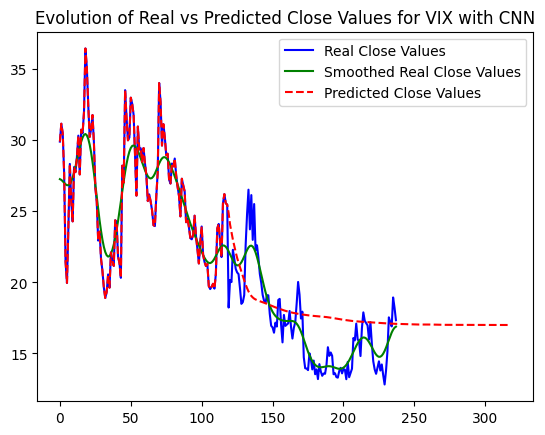

Feature: VIX - RMSE: 0.25544293589069905
Training for VIX with configuration rank 2
Epoch 1/1000
53/53 [==============================] - 27s 264ms/step - loss: 1081.8390 - val_loss: 168.4602
Epoch 2/1000
53/53 [==============================] - 12s 215ms/step - loss: 55.3777 - val_loss: 15.4277
Epoch 3/1000
53/53 [==============================] - 12s 231ms/step - loss: 14.2204 - val_loss: 12.7626
Epoch 4/1000
53/53 [==============================] - 12s 230ms/step - loss: 13.6128 - val_loss: 12.7465
Epoch 5/1000
53/53 [==============================] - 12s 226ms/step - loss: 13.5974 - val_loss: 12.6644
Epoch 6/1000
53/53 [==============================] - 12s 221ms/step - loss: 13.5602 - val_loss: 12.8300
Epoch 7/1000
53/53 [==============================] - 12s 220ms/step - loss: 13.5283 - val_loss: 12.6941
Epoch 8/1000
53/53 [==============================] - 11s 215ms/step - loss: 13.5079 - val_loss: 12.6502
Epoch 9/1000
53/53 [==============================] - 12s 221ms/step - lo

1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 80ms/step
Les prédictions sont constantes.


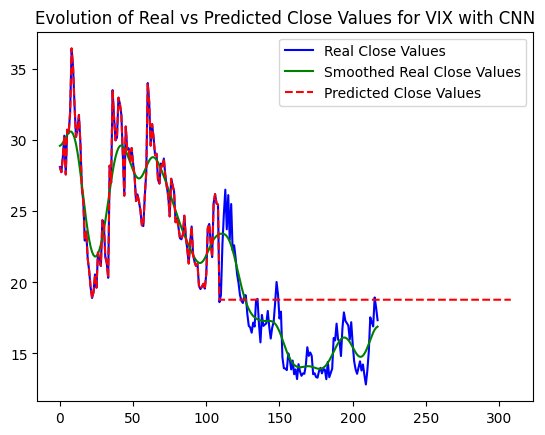

Feature: VIX - RMSE: 0.2564058737888766
Training for VIX with configuration rank 3
Epoch 1/1000
54/54 [==============================] - 21s 194ms/step - loss: 23.5641 - val_loss: 12.4180
Epoch 2/1000
54/54 [==============================] - 8s 142ms/step - loss: 9.0060 - val_loss: 6.3505
Epoch 3/1000
54/54 [==============================] - 7s 138ms/step - loss: 5.3508 - val_loss: 4.1089
Epoch 4/1000
54/54 [==============================] - 7s 138ms/step - loss: 3.4950 - val_loss: 2.7719
Epoch 5/1000
54/54 [==============================] - 7s 135ms/step - loss: 2.4247 - val_loss: 1.8256
Epoch 6/1000
54/54 [==============================] - 7s 137ms/step - loss: 1.6012 - val_loss: 1.2245
Epoch 7/1000
54/54 [==============================] - 7s 137ms/step - loss: 1.1385 - val_loss: 0.8572
Epoch 8/1000
54/54 [==============================] - 8s 140ms/step - loss: 0.8445 - val_loss: 0.6500
Epoch 9/1000
54/54 [==============================] - 8s 141ms/step - loss: 0.6814 - val_loss: 0.4

Epoch 80/1000
54/54 [==============================] - 8s 154ms/step - loss: 0.2161 - val_loss: 0.1933
Epoch 81/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.3599 - val_loss: 0.1831
Epoch 82/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.2172 - val_loss: 0.1634
Epoch 83/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.2057 - val_loss: 0.1556
Epoch 84/1000
54/54 [==============================] - 8s 156ms/step - loss: 0.2021 - val_loss: 0.1554
Epoch 85/1000
54/54 [==============================] - 8s 156ms/step - loss: 0.1944 - val_loss: 0.1575
Epoch 86/1000
54/54 [==============================] - 8s 147ms/step - loss: 0.1920 - val_loss: 0.1532
Epoch 87/1000
54/54 [==============================] - 8s 146ms/step - loss: 0.1913 - val_loss: 0.1522
Epoch 88/1000
54/54 [==============================] - 8s 146ms/step - loss: 0.1978 - val_loss: 0.1533
Epoch 89/1000
54/54 [==============================] - 8s 141ms/step - lo

Epoch 159/1000
54/54 [==============================] - 8s 141ms/step - loss: 0.1941 - val_loss: 0.1492
Epoch 160/1000
54/54 [==============================] - 8s 143ms/step - loss: 0.1912 - val_loss: 0.1514
Epoch 161/1000
54/54 [==============================] - 8s 146ms/step - loss: 0.1861 - val_loss: 0.1647
Epoch 162/1000
54/54 [==============================] - 8s 143ms/step - loss: 0.2902 - val_loss: 0.1602
Epoch 163/1000
54/54 [==============================] - 8s 143ms/step - loss: 0.2058 - val_loss: 0.1588
Epoch 164/1000
54/54 [==============================] - 8s 142ms/step - loss: 0.1990 - val_loss: 0.1704
Epoch 165/1000
54/54 [==============================] - 8s 144ms/step - loss: 0.4442 - val_loss: 1.1439
Epoch 166/1000
54/54 [==============================] - 8s 144ms/step - loss: 0.4932 - val_loss: 0.3012
Epoch 167/1000
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 107ms/step


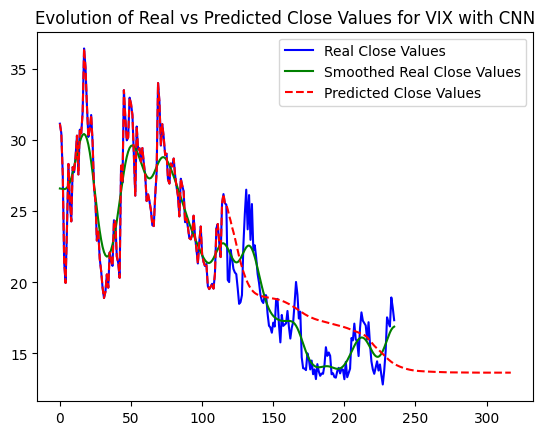

Feature: VIX - RMSE: 0.352923172554971
Training for VIX with configuration rank 4
Epoch 1/1000
54/54 [==============================] - 25s 218ms/step - loss: 30.9774 - val_loss: 20.9765
Epoch 2/1000
54/54 [==============================] - 8s 155ms/step - loss: 17.2743 - val_loss: 13.9665
Epoch 3/1000
54/54 [==============================] - 8s 147ms/step - loss: 12.4758 - val_loss: 10.6763
Epoch 4/1000
54/54 [==============================] - 8s 148ms/step - loss: 9.7159 - val_loss: 8.5744
Epoch 5/1000
54/54 [==============================] - 8s 150ms/step - loss: 7.9141 - val_loss: 7.0637
Epoch 6/1000
54/54 [==============================] - 8s 153ms/step - loss: 6.5724 - val_loss: 5.9218
Epoch 7/1000
54/54 [==============================] - 8s 152ms/step - loss: 5.5352 - val_loss: 5.0416
Epoch 8/1000
54/54 [==============================] - 8s 155ms/step - loss: 4.7329 - val_loss: 4.2865
Epoch 9/1000
54/54 [==============================] - 8s 155ms/step - loss: 4.0640 - val_loss: 

54/54 [==============================] - 9s 171ms/step - loss: 0.2273 - val_loss: 0.1991
Epoch 80/1000
54/54 [==============================] - 9s 173ms/step - loss: 0.2228 - val_loss: 0.1722
Epoch 81/1000
54/54 [==============================] - 9s 170ms/step - loss: 0.2353 - val_loss: 0.1764
Epoch 82/1000
54/54 [==============================] - 9s 171ms/step - loss: 0.2226 - val_loss: 0.1940
Epoch 83/1000
54/54 [==============================] - 9s 175ms/step - loss: 0.2222 - val_loss: 0.1749
Epoch 84/1000
54/54 [==============================] - 9s 164ms/step - loss: 0.2395 - val_loss: 0.1797
Epoch 85/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.2285 - val_loss: 0.1785
Epoch 86/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.2296 - val_loss: 0.1800
Epoch 87/1000
54/54 [==============================] - 8s 157ms/step - loss: 0.2259 - val_loss: 0.1754
Epoch 88/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.2268 - v

1/1 [==============================] - 0s 70ms/step


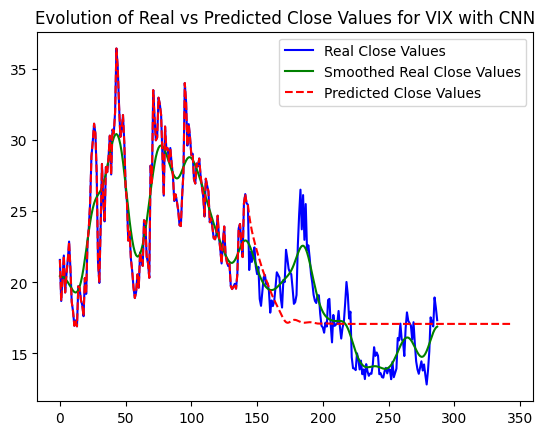

Feature: VIX - RMSE: 0.25353205434059906
Training for VIX with configuration rank 5
Epoch 1/1000
53/53 [==============================] - 26s 267ms/step - loss: 18.8171 - val_loss: 5.2037
Epoch 2/1000
53/53 [==============================] - 12s 219ms/step - loss: 2.9875 - val_loss: 1.5685
Epoch 3/1000
53/53 [==============================] - 12s 219ms/step - loss: 1.2625 - val_loss: 0.7467
Epoch 4/1000
53/53 [==============================] - 11s 210ms/step - loss: 0.6723 - val_loss: 0.4483
Epoch 5/1000
53/53 [==============================] - 11s 199ms/step - loss: 0.4265 - val_loss: 0.2821
Epoch 6/1000
53/53 [==============================] - 11s 202ms/step - loss: 0.3024 - val_loss: 0.1974
Epoch 7/1000
53/53 [==============================] - 11s 203ms/step - loss: 0.2826 - val_loss: 0.1646
Epoch 8/1000
53/53 [==============================] - 11s 205ms/step - loss: 0.3049 - val_loss: 0.1959
Epoch 9/1000
53/53 [==============================] - 11s 207ms/step - loss: 0.2868 - val_l

53/53 [==============================] - 11s 208ms/step - loss: 1.3994 - val_loss: 0.4977
Epoch 80/1000
53/53 [==============================] - 11s 209ms/step - loss: 1.2431 - val_loss: 0.4372
Epoch 81/1000
53/53 [==============================] - 11s 209ms/step - loss: 2.4499 - val_loss: 1.6289
Epoch 82/1000
53/53 [==============================] - 11s 209ms/step - loss: 1.7860 - val_loss: 0.6022
Epoch 83/1000
53/53 [==============================] - 11s 210ms/step - loss: 1.4117 - val_loss: 0.5124
Epoch 84/1000
53/53 [==============================] - 11s 209ms/step - loss: 1.2476 - val_loss: 0.3769
Epoch 85/1000
53/53 [==============================] - 12s 229ms/step - loss: 1.6726 - val_loss: 0.9327
Epoch 86/1000
53/53 [==============================] - 12s 226ms/step - loss: 2.1493 - val_loss: 1.0385
Epoch 87/1000
53/53 [==============================] - 12s 224ms/step - loss: 1.6645 - val_loss: 0.5744
Epoch 88/1000
53/53 [==============================] - 12s 228ms/step - loss: 

1/1 [==============================] - 0s 100ms/step


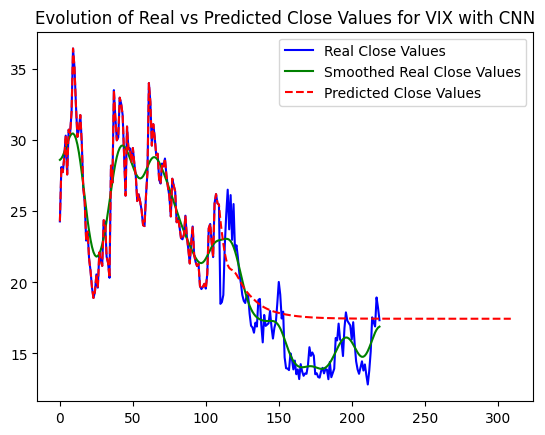

Feature: VIX - RMSE: 0.2528040193898163
Training for FVX with configuration rank 1
Epoch 1/1000
54/54 [==============================] - 24s 206ms/step - loss: 4.0813 - val_loss: 2.3602
Epoch 2/1000
54/54 [==============================] - 8s 151ms/step - loss: 1.7427 - val_loss: 1.4481
Epoch 3/1000
54/54 [==============================] - 8s 147ms/step - loss: 1.1958 - val_loss: 1.5070
Epoch 4/1000
54/54 [==============================] - 8s 151ms/step - loss: 0.9214 - val_loss: 0.8392
Epoch 5/1000
54/54 [==============================] - 8s 150ms/step - loss: 0.7195 - val_loss: 0.6417
Epoch 6/1000
54/54 [==============================] - 8s 147ms/step - loss: 0.5797 - val_loss: 0.5274
Epoch 7/1000
54/54 [==============================] - 8s 149ms/step - loss: 0.4719 - val_loss: 0.4587
Epoch 8/1000
54/54 [==============================] - 8s 152ms/step - loss: 0.3991 - val_loss: 0.3638
Epoch 9/1000
54/54 [==============================] - 8s 151ms/step - loss: 0.3276 - val_loss: 0.494

1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 103ms/step


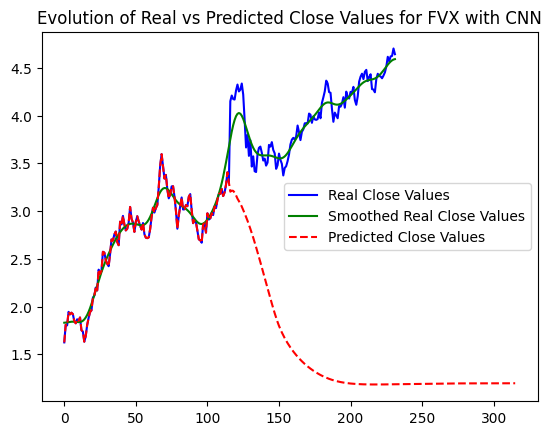

Feature: FVX - RMSE: 0.9651299610298205
Training for FVX with configuration rank 2
Epoch 1/1000
53/53 [==============================] - 22s 211ms/step - loss: 1.3756 - val_loss: 0.8995
Epoch 2/1000
53/53 [==============================] - 8s 156ms/step - loss: 0.7147 - val_loss: 0.6012
Epoch 3/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.5351 - val_loss: 0.4903
Epoch 4/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.4519 - val_loss: 0.4573
Epoch 5/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.3938 - val_loss: 0.3784
Epoch 6/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.3471 - val_loss: 0.3281
Epoch 7/1000
53/53 [==============================] - 7s 141ms/step - loss: 0.3071 - val_loss: 0.2913
Epoch 8/1000
53/53 [==============================] - 8s 143ms/step - loss: 0.2735 - val_loss: 0.2653
Epoch 9/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.2432 - val_loss: 0.234

Epoch 80/1000
53/53 [==============================] - 8s 143ms/step - loss: 0.0089 - val_loss: 0.0096
Epoch 81/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.0092 - val_loss: 0.0113
Epoch 82/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 83/1000
53/53 [==============================] - 8s 147ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 84/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.0075 - val_loss: 0.0089
Epoch 85/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.0074 - val_loss: 0.0109
Epoch 86/1000
53/53 [==============================] - 8s 147ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 87/1000
53/53 [==============================] - 8s 145ms/step - loss: 0.0075 - val_loss: 0.0096
Epoch 88/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.0075 - val_loss: 0.0111
Epoch 89/1000
53/53 [==============================] - 8s 146ms/step - lo

Epoch 159/1000
53/53 [==============================] - 8s 147ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 160/1000
53/53 [==============================] - 7s 139ms/step - loss: 0.0072 - val_loss: 0.0146
Epoch 161/1000
53/53 [==============================] - 8s 142ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 162/1000
53/53 [==============================] - 7s 141ms/step - loss: 0.0072 - val_loss: 0.0085
Epoch 163/1000
53/53 [==============================] - 8s 145ms/step - loss: 0.0070 - val_loss: 0.0145
Epoch 164/1000
53/53 [==============================] - 8s 146ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 165/1000
53/53 [==============================] - 8s 150ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 166/1000
53/53 [==============================] - 8s 146ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 167/1000
53/53 [==============================] - 8s 145ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 168/1000
53/53 [==============================] - 8s 144ms

1/1 [==============================] - 0s 113ms/step


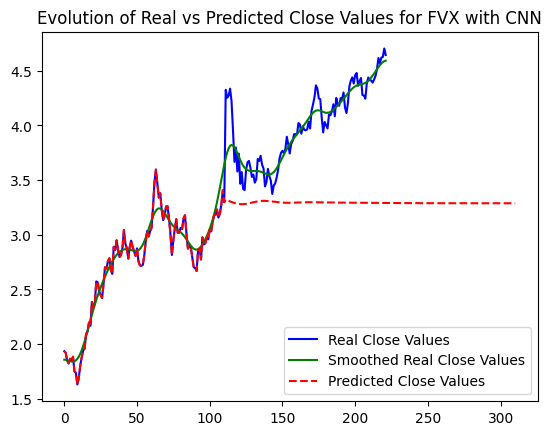

Feature: FVX - RMSE: 0.24069591311299784
Training for FVX with configuration rank 3
Epoch 1/1000
53/53 [==============================] - 25s 237ms/step - loss: 3.1573 - val_loss: 1.8710
Epoch 2/1000
53/53 [==============================] - 9s 175ms/step - loss: 1.4375 - val_loss: 1.1757
Epoch 3/1000
53/53 [==============================] - 9s 167ms/step - loss: 1.0225 - val_loss: 0.9104
Epoch 4/1000
53/53 [==============================] - 9s 166ms/step - loss: 0.7983 - val_loss: 0.8135
Epoch 5/1000
53/53 [==============================] - 8s 159ms/step - loss: 0.6401 - val_loss: 0.5604
Epoch 6/1000
53/53 [==============================] - 9s 173ms/step - loss: 0.4973 - val_loss: 0.4421
Epoch 7/1000
53/53 [==============================] - 9s 166ms/step - loss: 0.3913 - val_loss: 0.3496
Epoch 8/1000
53/53 [==============================] - 8s 160ms/step - loss: 0.3115 - val_loss: 0.2759
Epoch 9/1000
53/53 [==============================] - 9s 167ms/step - loss: 0.2454 - val_loss: 0.22

Epoch 80/1000
53/53 [==============================] - 9s 179ms/step - loss: 0.0157 - val_loss: 0.0144
Epoch 81/1000
53/53 [==============================] - 9s 178ms/step - loss: 0.0141 - val_loss: 0.0153
Epoch 82/1000
53/53 [==============================] - 9s 169ms/step - loss: 0.0143 - val_loss: 0.0148
Epoch 83/1000
53/53 [==============================] - 9s 169ms/step - loss: 0.0156 - val_loss: 0.0163
Epoch 84/1000
53/53 [==============================] - 9s 173ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 85/1000
53/53 [==============================] - 10s 183ms/step - loss: 0.0138 - val_loss: 0.0153
Epoch 86/1000
53/53 [==============================] - 9s 170ms/step - loss: 0.0138 - val_loss: 0.0166
Epoch 87/1000
53/53 [==============================] - 9s 163ms/step - loss: 0.0133 - val_loss: 0.0148
Epoch 88/1000
53/53 [==============================] - 9s 166ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 89/1000
53/53 [==============================] - 9s 164ms/step - l

1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 93ms/step


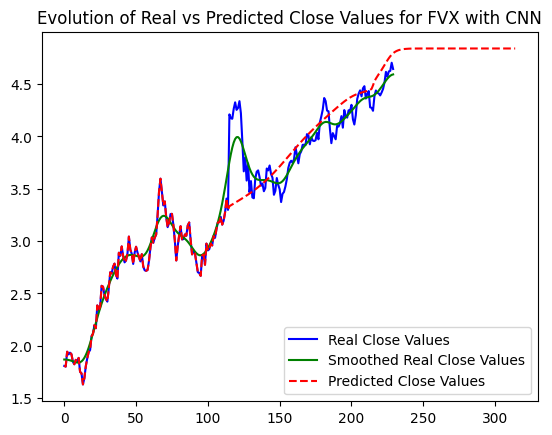

Feature: FVX - RMSE: 0.2952618487267208
Training for FVX with configuration rank 4
Epoch 1/1000
53/53 [==============================] - 22s 200ms/step - loss: 1.4707 - val_loss: 0.9636
Epoch 2/1000
53/53 [==============================] - 8s 152ms/step - loss: 0.8038 - val_loss: 0.6939
Epoch 3/1000
53/53 [==============================] - 7s 141ms/step - loss: 0.6262 - val_loss: 0.5768
Epoch 4/1000
53/53 [==============================] - 7s 139ms/step - loss: 0.5333 - val_loss: 0.5000
Epoch 5/1000
53/53 [==============================] - 7s 141ms/step - loss: 0.4680 - val_loss: 0.4488
Epoch 6/1000
53/53 [==============================] - 7s 140ms/step - loss: 0.4175 - val_loss: 0.3988
Epoch 7/1000
53/53 [==============================] - 8s 143ms/step - loss: 0.3777 - val_loss: 0.3607
Epoch 8/1000
53/53 [==============================] - 7s 141ms/step - loss: 0.3410 - val_loss: 0.3278
Epoch 9/1000
53/53 [==============================] - 7s 140ms/step - loss: 0.3122 - val_loss: 0.304

Epoch 80/1000
53/53 [==============================] - 8s 145ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 81/1000
53/53 [==============================] - 8s 145ms/step - loss: 0.0073 - val_loss: 0.0100
Epoch 82/1000
53/53 [==============================] - 8s 142ms/step - loss: 0.0081 - val_loss: 0.0093
Epoch 83/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.0074 - val_loss: 0.0096
Epoch 84/1000
53/53 [==============================] - 8s 151ms/step - loss: 0.0073 - val_loss: 0.0105
Epoch 85/1000
53/53 [==============================] - 8s 151ms/step - loss: 0.0074 - val_loss: 0.0085
Epoch 86/1000
53/53 [==============================] - 8s 155ms/step - loss: 0.0075 - val_loss: 0.0092
Epoch 87/1000
53/53 [==============================] - 8s 153ms/step - loss: 0.0074 - val_loss: 0.0120
Epoch 88/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.0068 - val_loss: 0.0091
Epoch 89/1000
53/53 [==============================] - 8s 144ms/step - lo

Epoch 159/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 160/1000
53/53 [==============================] - 8s 143ms/step - loss: 0.0062 - val_loss: 0.0079
Epoch 161/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 162/1000
53/53 [==============================] - 8s 143ms/step - loss: 0.0058 - val_loss: 0.0076
Epoch 163/1000
53/53 [==============================] - 8s 145ms/step - loss: 0.0059 - val_loss: 0.0075
Epoch 164/1000
53/53 [==============================] - 8s 143ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 165/1000
53/53 [==============================] - 8s 143ms/step - loss: 0.0057 - val_loss: 0.0074
Epoch 166/1000
53/53 [==============================] - 8s 143ms/step - loss: 0.0056 - val_loss: 0.0098
Epoch 167/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.0059 - val_loss: 0.0078
Epoch 168/1000
53/53 [==============================] - 8s 144ms

1/1 [==============================] - 0s 89ms/step


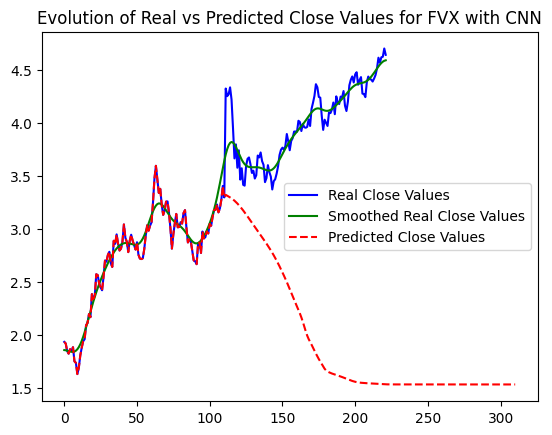

Feature: FVX - RMSE: 0.794570240617345
Training for FVX with configuration rank 5
Epoch 1/1000
53/53 [==============================] - 23s 234ms/step - loss: 1.2238 - val_loss: 0.7405
Epoch 2/1000
53/53 [==============================] - 8s 151ms/step - loss: 0.5938 - val_loss: 0.5010
Epoch 3/1000
53/53 [==============================] - 8s 151ms/step - loss: 0.4519 - val_loss: 0.4197
Epoch 4/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.3902 - val_loss: 0.3702
Epoch 5/1000
53/53 [==============================] - 8s 150ms/step - loss: 0.3481 - val_loss: 0.3404
Epoch 6/1000
53/53 [==============================] - 8s 147ms/step - loss: 0.3132 - val_loss: 0.3002
Epoch 7/1000
53/53 [==============================] - 8s 149ms/step - loss: 0.2850 - val_loss: 0.2786
Epoch 8/1000
53/53 [==============================] - 8s 152ms/step - loss: 0.2574 - val_loss: 0.2471
Epoch 9/1000
53/53 [==============================] - 8s 151ms/step - loss: 0.2331 - val_loss: 0.2244

Epoch 80/1000
53/53 [==============================] - 8s 160ms/step - loss: 0.0070 - val_loss: 0.0089
Epoch 81/1000
53/53 [==============================] - 8s 156ms/step - loss: 0.0072 - val_loss: 0.0133
Epoch 82/1000
53/53 [==============================] - 8s 154ms/step - loss: 0.0084 - val_loss: 0.0125
Epoch 83/1000
53/53 [==============================] - 8s 153ms/step - loss: 0.0075 - val_loss: 0.0108
Epoch 84/1000
53/53 [==============================] - 8s 155ms/step - loss: 0.0072 - val_loss: 0.0088
Epoch 85/1000
53/53 [==============================] - 8s 153ms/step - loss: 0.0074 - val_loss: 0.0093
Epoch 86/1000
53/53 [==============================] - 8s 158ms/step - loss: 0.0074 - val_loss: 0.0134
Epoch 87/1000
53/53 [==============================] - 8s 151ms/step - loss: 0.0077 - val_loss: 0.0087
Epoch 88/1000
53/53 [==============================] - 8s 147ms/step - loss: 0.0070 - val_loss: 0.0091
Epoch 89/1000
53/53 [==============================] - 8s 150ms/step - lo

Epoch 159/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.0063 - val_loss: 0.0086
Epoch 160/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 161/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 162/1000
53/53 [==============================] - 8s 149ms/step - loss: 0.0066 - val_loss: 0.0089
Epoch 163/1000
53/53 [==============================] - 8s 147ms/step - loss: 0.0062 - val_loss: 0.0075
Epoch 164/1000
53/53 [==============================] - 8s 144ms/step - loss: 0.0063 - val_loss: 0.0079
Epoch 165/1000
53/53 [==============================] - 8s 149ms/step - loss: 0.0063 - val_loss: 0.0099
Epoch 166/1000
53/53 [==============================] - 8s 148ms/step - loss: 0.0061 - val_loss: 0.0077
Epoch 167/1000
53/53 [==============================] - 8s 145ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 168/1000
53/53 [==============================] - 8s 145ms

1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 90ms/step


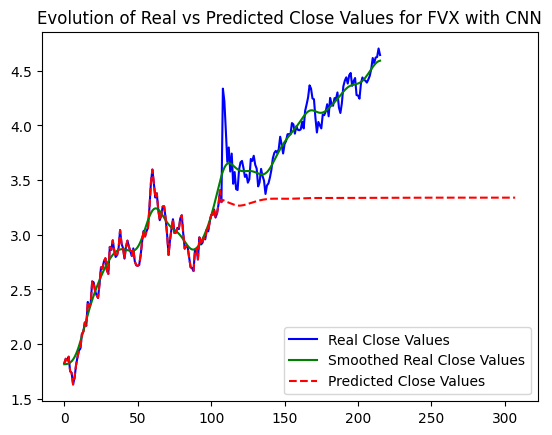

Feature: FVX - RMSE: 0.21891306911431513
Training for NVDA with configuration rank 1
Epoch 1/1000
54/54 [==============================] - 19s 186ms/step - loss: 54.7501 - val_loss: 36.6989
Epoch 2/1000
54/54 [==============================] - 8s 148ms/step - loss: 16.2206 - val_loss: 13.9660
Epoch 3/1000
54/54 [==============================] - 8s 147ms/step - loss: 8.0694 - val_loss: 10.0105
Epoch 4/1000
54/54 [==============================] - 8s 144ms/step - loss: 4.4145 - val_loss: 14.8410
Epoch 5/1000
54/54 [==============================] - 8s 147ms/step - loss: 2.5901 - val_loss: 25.0651
Epoch 6/1000
54/54 [==============================] - 8s 146ms/step - loss: 1.6951 - val_loss: 5.3619
Epoch 7/1000
54/54 [==============================] - 8s 145ms/step - loss: 1.0780 - val_loss: 10.4926
Epoch 8/1000
54/54 [==============================] - 8s 147ms/step - loss: 0.7759 - val_loss: 5.0598
Epoch 9/1000
54/54 [==============================] - 8s 147ms/step - loss: 0.6662 - val_l

1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 86ms/step


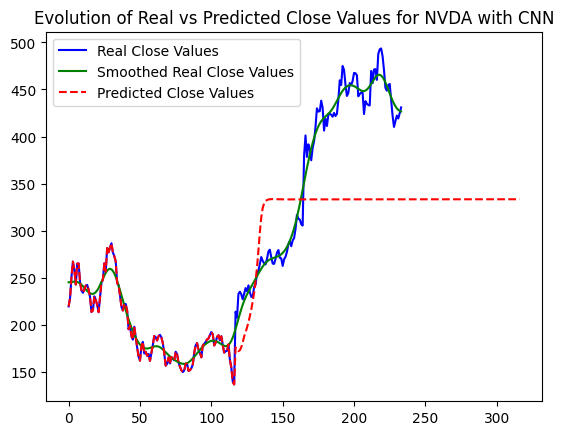

Feature: NVDA - RMSE: 1.3492802007537605
Training for NVDA with configuration rank 2
Epoch 1/1000
54/54 [==============================] - 20s 159ms/step - loss: 206.8784 - val_loss: 74.6629
Epoch 2/1000
54/54 [==============================] - 6s 113ms/step - loss: 39.8996 - val_loss: 25.9967
Epoch 3/1000
54/54 [==============================] - 6s 111ms/step - loss: 15.5996 - val_loss: 13.7322
Epoch 4/1000
54/54 [==============================] - 6s 110ms/step - loss: 8.0192 - val_loss: 15.6452
Epoch 5/1000
54/54 [==============================] - 6s 112ms/step - loss: 4.9926 - val_loss: 9.7985
Epoch 6/1000
54/54 [==============================] - 6s 114ms/step - loss: 3.5261 - val_loss: 6.6122
Epoch 7/1000
54/54 [==============================] - 6s 114ms/step - loss: 2.7630 - val_loss: 5.6056
Epoch 8/1000
54/54 [==============================] - 6s 114ms/step - loss: 2.3202 - val_loss: 7.7567
Epoch 9/1000
54/54 [==============================] - 6s 114ms/step - loss: 2.0511 - val_l

54/54 [==============================] - 6s 120ms/step - loss: 1.6956 - val_loss: 5.4236
Epoch 80/1000
54/54 [==============================] - 6s 118ms/step - loss: 1.6731 - val_loss: 5.5561
Epoch 81/1000
54/54 [==============================] - 6s 118ms/step - loss: 1.6683 - val_loss: 4.8125
Epoch 82/1000
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 85ms/step


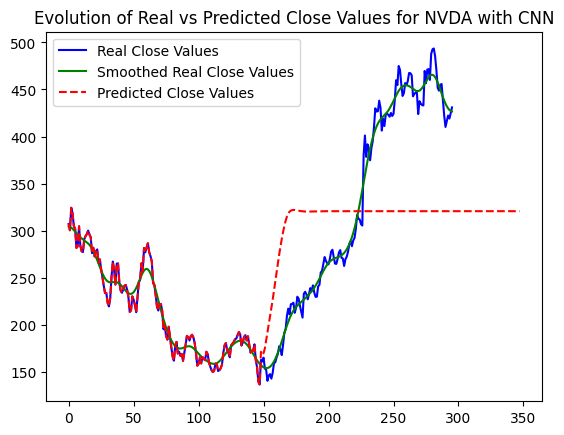

Feature: NVDA - RMSE: 1.6271214650182628
Training for NVDA with configuration rank 3
Epoch 1/1000
54/54 [==============================] - 24s 226ms/step - loss: 8.7251 - val_loss: 11.7409
Epoch 2/1000
54/54 [==============================] - 10s 175ms/step - loss: 5.6857 - val_loss: 10.5563
Epoch 3/1000
54/54 [==============================] - 9s 174ms/step - loss: 4.2606 - val_loss: 8.3332
Epoch 4/1000
54/54 [==============================] - 9s 175ms/step - loss: 3.4113 - val_loss: 7.8104
Epoch 5/1000
54/54 [==============================] - 9s 173ms/step - loss: 2.8797 - val_loss: 7.3177
Epoch 6/1000
54/54 [==============================] - 10s 177ms/step - loss: 2.5240 - val_loss: 7.7234
Epoch 7/1000
54/54 [==============================] - 9s 171ms/step - loss: 2.2545 - val_loss: 8.1536
Epoch 8/1000
54/54 [==============================] - 9s 174ms/step - loss: 2.0497 - val_loss: 7.5318
Epoch 9/1000
54/54 [==============================] - 9s 176ms/step - loss: 1.8660 - val_loss:

1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 67ms/step


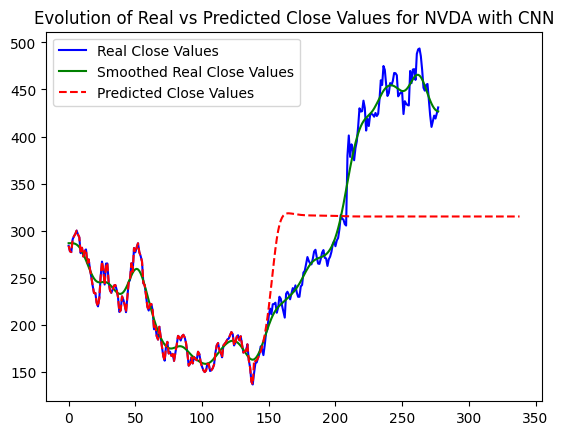

Feature: NVDA - RMSE: 1.4795984663683588
Training for NVDA with configuration rank 4
Epoch 1/1000
54/54 [==============================] - 22s 208ms/step - loss: 16.1658 - val_loss: 15.5403
Epoch 2/1000
54/54 [==============================] - 9s 162ms/step - loss: 8.8130 - val_loss: 12.4633
Epoch 3/1000
54/54 [==============================] - 10s 177ms/step - loss: 6.2655 - val_loss: 9.9175
Epoch 4/1000
54/54 [==============================] - 10s 178ms/step - loss: 4.9483 - val_loss: 8.6949
Epoch 5/1000
54/54 [==============================] - 10s 178ms/step - loss: 4.0921 - val_loss: 8.0131
Epoch 6/1000
54/54 [==============================] - 10s 177ms/step - loss: 3.4612 - val_loss: 8.1745
Epoch 7/1000
54/54 [==============================] - 10s 178ms/step - loss: 2.9413 - val_loss: 7.2461
Epoch 8/1000
54/54 [==============================] - 10s 180ms/step - loss: 2.5226 - val_loss: 5.7378
Epoch 9/1000
54/54 [==============================] - 9s 174ms/step - loss: 2.1807 - val_

1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 84ms/step


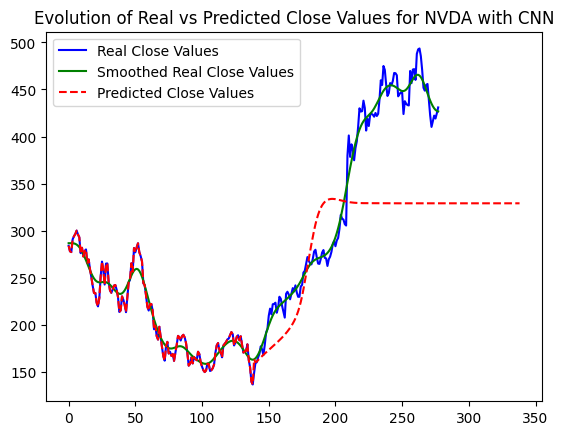

Feature: NVDA - RMSE: 1.6153818736099415
Training for NVDA with configuration rank 5
Epoch 1/1000
54/54 [==============================] - 21s 194ms/step - loss: 19.7980 - val_loss: 18.6845
Epoch 2/1000
54/54 [==============================] - 8s 147ms/step - loss: 10.4108 - val_loss: 11.2060
Epoch 3/1000
54/54 [==============================] - 8s 145ms/step - loss: 7.2070 - val_loss: 9.4762
Epoch 4/1000
54/54 [==============================] - 8s 144ms/step - loss: 5.6377 - val_loss: 9.6277
Epoch 5/1000
54/54 [==============================] - 8s 147ms/step - loss: 4.6530 - val_loss: 7.3937
Epoch 6/1000
54/54 [==============================] - 8s 148ms/step - loss: 3.8531 - val_loss: 10.1699
Epoch 7/1000
54/54 [==============================] - 8s 149ms/step - loss: 3.2309 - val_loss: 9.3792
Epoch 8/1000
54/54 [==============================] - 8s 151ms/step - loss: 2.6964 - val_loss: 8.1694
Epoch 9/1000
54/54 [==============================] - 8s 152ms/step - loss: 2.2498 - val_loss

1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 69ms/step


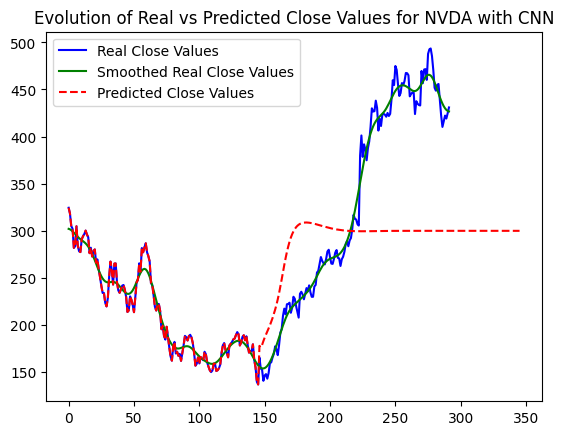

Feature: NVDA - RMSE: 1.5063751970002535
Entraînement des modèles de réseau neuronal terminé.


In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

def create_single_output_sequences(data, index_name, look_back=1):
    X, y = [], []
    feature_columns = ['Close']
    for i in range(look_back, len(data)):
        sequence_data = data.loc[data.index[i-look_back:i], [(index_name, col) for col in feature_columns]].values
        X.append(sequence_data)
        y.append(data.loc[data.index[i], [(index_name, 'Close')]].values[0])
    return np.array(X), np.array(y)

def recursive_prediction_multi_output(model, initial_input, steps):
    recursive_predictions = []  # Une liste pour stocker les prédictions à chaque étape
    current_input = initial_input.copy()  # Copie de l'entrée initiale pour éviter les modifications indésirables

    for i in range(steps):
        # Faire une prédiction pour le jour suivant en utilisant l'entrée actuelle
        predicted_values = model.predict(current_input.to_numpy().reshape(1, current_input.shape[0], current_input.shape[1]))
        
        # Ajouter ces prédictions à notre liste
        recursive_predictions.append(predicted_values[0])
        
        # Préparer l'entrée pour la prochaine prédiction
        # Supprimer la première valeur (jour le plus ancien)
        current_input = current_input.shift(-1)
        # Ajouter la nouvelle valeur prédite à la fin de l'entrée
        current_input.iloc[-1:] = pd.DataFrame(predicted_values)

    return np.array(recursive_predictions)

# Dictionnaires pour stocker les modèles et leurs performances
gru_models = {}
mse_gru = {}
recursive_preds_gru = {}

for index_name in final_df.columns.get_level_values(0).unique():  # Parcourir chaque indice
    # Sélectionner hyperparamètre optimaux
    top_n_params = top_n_trials_per_feature[index_name]
    best_rmse = float('inf') 
    best_model = None
    
    for rank, best_params in enumerate(top_n_params, 1):
        print(f"Training for {index_name} with configuration rank {rank}")
        look_back=best_params['look_back']

        # Créer des séquences pour l'entraînement et les tests
        X_train, y_train = create_single_output_sequences(train_data, index_name , look_back)
        X_test, y_test = create_single_output_sequences(test_data, index_name ,look_back)

        # Create the neural network model
        model = create_model(
            num_layers=best_params['num_layers'],
            units_per_layer=[2 ** (best_params[f'units_power_{i}']) for i in range(best_params['num_layers'])],
            layer_type=[best_params[f'layer_type_{i}'] for i in range(best_params['num_layers'])],
            dropout_per_layer=[best_params[f'dropout_{i}'] for i in range(best_params['num_layers'])],
            input_shape=(X_train.shape[1], 1),
            use_conv1d=best_params['use_conv1d'],
            conv1d_filters=2 ** best_params['conv1d_filters'] if best_params['use_conv1d'] else None,
            conv1d_kernel_size=best_params.get('conv1d_kernel_size', None),
            use_residual_connection=best_params['use_residual_connection'],
            attention_layer=best_params['use_attention_layer'],
            l1_reg=best_params['l1_reg'],
            l2_reg=best_params['l2_reg']
        )

        # Entraîner le modèle
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=64, callbacks=[early_stopping])

        # Évaluer le modèle

        # Initial input: X dernières observations du jeu de données d'entraînement
        initial_input = train_data[[(index_name, 'Close')]][-look_back:]

        # Prédictions récursives
        predictions = recursive_prediction_multi_output(model, initial_input, len(test_data))

        # Initialisation
        inverse_predictions = np.zeros_like(predictions)
        inverse_real_values = np.zeros_like(y_test)

        # Parcourir chaque caractéristique et chaque indice
        for idx, feature_name in enumerate(['Close']):
            scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
            feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant

            # Inverser la mise à l'échelle pour les prédictions et les valeurs réelles
            inverse_predictions = feature_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
            inverse_real_values_test = feature_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

            # Utilisez le scaler pour inverser la mise à l'échelle des dernières valeurs réelles de l'ensemble d'entraînement
            last_real_values_train_scaled = train_data[(index_name, 'Close')].iloc[-len(y_test):].values
            last_real_values_train = feature_scaler.inverse_transform(last_real_values_train_scaled.reshape(-1, 1)).flatten()

            # Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les vraies valeurs de l'ensemble de test
            real_values = np.concatenate([last_real_values_train, inverse_real_values_test])

            # Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les valeurs prédites
            predicted_values = np.concatenate([last_real_values_train, inverse_predictions])
            
            # Appliquer le filtre gaussien
            sigma = 5
            smoothed_values_test = gaussian_filter1d(y_test, sigma)
            smoothed_values = gaussian_filter1d(real_values, sigma)

            rmse = weighted_rmse(smoothed_values_test, np.array(predictions), len(smoothed_values_test))
            if np.std(predictions) > 1e-3:
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    
                    # Stockez les prédictions pour cette caractéristique
                    recursive_preds_gru[scaler_key] = inverse_predictions
            else:
                print("Les prédictions sont constantes.")
            
            plt.plot(real_values, label='Real Close Values', color='blue')
            plt.plot(smoothed_values, label='Smoothed Real Close Values', color='green')
            plt.plot(predicted_values, label='Predicted Close Values', color='red', linestyle='--')
            plt.title(f"Evolution of Real vs Predicted Close Values for {index_name} with CNN")
            plt.legend()
            plt.show()

            # Stocker le modèle et sa performance
            gru_models[scaler_key] = best_model
            mse_gru[scaler_key] = best_rmse
        print(f"Feature: {index_name} - RMSE: {rmse}")

print("Entraînement des modèles de réseau neuronal terminé.")

#### Modèle XGBoost:

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Si les données sont une liste ou un tableau 1D, les convertir en DataFrame
    if type(data) is list or len(data.shape) == 1:
        df = pd.DataFrame(data)
        n_vars = 1
    else:
        df = pd.DataFrame(data)
        n_vars = data.shape[1]
    cols, names = list(), list()
    # Séquence d'entrée (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Séquence de prévision (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Concaténer le tout
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Supprimer les lignes avec des valeurs NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def recursive_prediction_xgb(model, initial_input, steps):
    current_input = np.array(initial_input)
    predictions = []
    for _ in range(steps):
        predicted_values = model.predict(current_input.reshape(1, -1))
        predictions.append(predicted_values)
        current_input = np.roll(current_input, -1)
        current_input[-1:] = predicted_values
    return np.array(predictions)

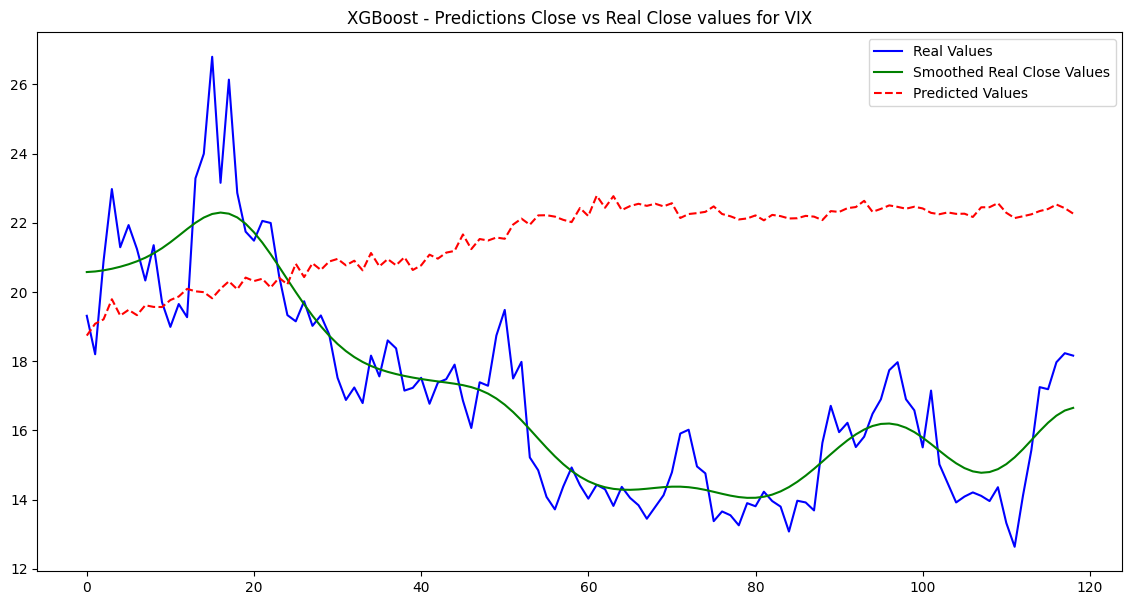

Feature: VIX - RMSE: 0.358162152162774


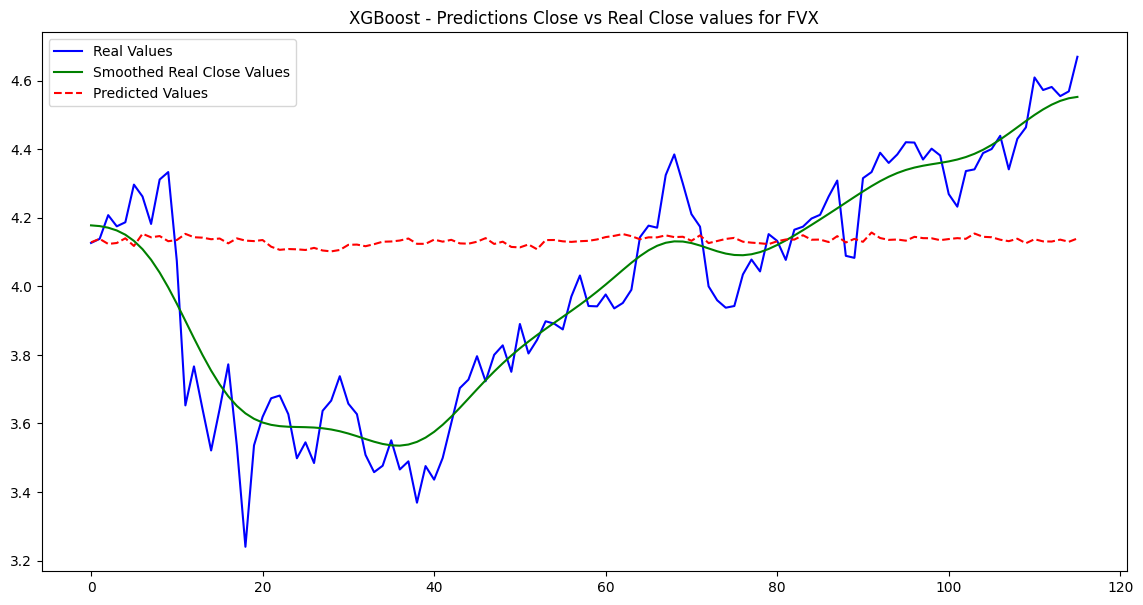

Feature: FVX - RMSE: 0.1431140908559981


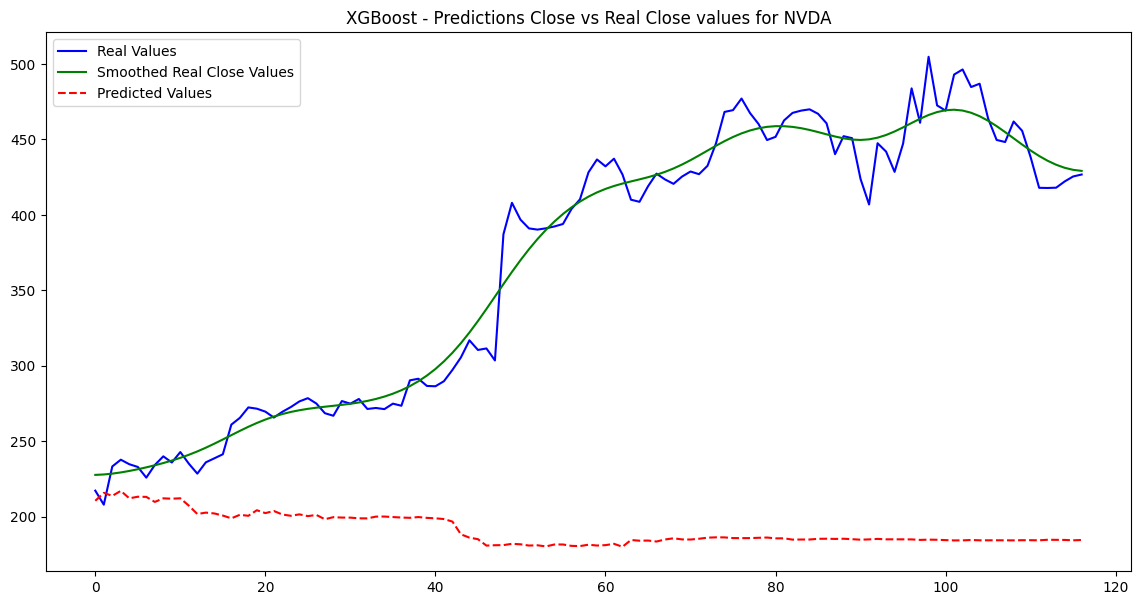

Feature: NVDA - RMSE: 2.3150465490460475
Entraînement des modèles XGBoost terminé.


In [25]:
# Dictionnaires pour stocker les modèles XGBoost et leurs performances
xgb_models = {}
mse_xgb = {}
recursive_preds_xgb = {}

for index_name in final_df.columns.get_level_values(0).unique():
    
    # Sélectionner look_back optimal
    best_params = best_params_per_feature[index_name]
    look_back = best_params['look_back']
    
    # Préparer les données pour XGBoost
    # Créer un indexeur
    idx = pd.IndexSlice

    # Utiliser cet indexeur pour récupérer les données
    values = scaled_data_df.filter(like=index_name, axis=1).values
    data = series_to_supervised(values, look_back, 1)
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    # Diviser en entrées et sorties
    
    X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values
    
    # Modèle XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
    model.fit(X_train, y_train)
    
    # Prédictions
    initial_input = X_test[0]
    predictions = recursive_prediction_xgb(model, initial_input, len(y_test))
    
    for idx, feature_name in enumerate(['Close']):
        scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
        feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant
    
        # Inversez la mise à l'échelle

        inverse_predictions = feature_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        inverse_real_values = feature_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        # Appliquer le filtre gaussien
        sigma = 5
        smoothed_values_test = gaussian_filter1d(y_test, sigma)
        smoothed_values = gaussian_filter1d(y_test, sigma)
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
        # Afficher les graphiques
        plt.figure(figsize=(14,7))

        # Tracez les valeurs réelles
        plt.plot(inverse_real_values, label='Real Values', color='blue')
        
        plt.plot(smoothed_values_test, label='Smoothed Real Close Values', color='green')

        # Tracez les prédictions
        plt.plot(inverse_predictions, label='Predicted Values', color='red', linestyle='--')

        plt.title(f"XGBoost - Predictions Close vs Real Close values for {index_name}")
        plt.legend()
        plt.show()

        # Évaluer le modèle
        rmse = weighted_rmse(smoothed_values, np.array(predictions), len(smoothed_values))

        # Stocker le modèle et sa performance
        xgb_models[scaler_key] = model
        mse_xgb[scaler_key] = rmse
        recursive_preds_xgb[scaler_key] = inverse_predictions
        print(f"Feature: {index_name} - RMSE: {rmse}")

print("Entraînement des modèles XGBoost terminé.")

#### Modèle SARIMA:

[I 2023-10-02 21:26:09,345] A new study created in memory with name: no-name-7a49b2a6-5fef-4729-aa75-e4e1430815ac
[I 2023-10-02 21:26:55,894] Trial 0 finished with value: 0.14098386104291682 and parameters: {'p': 5, 'd': 0, 'q': 3, 'P': 2, 'D': 1, 'Q': 3, 's': 8}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 21:26:55,895] Trial 1 finished with value: inf and parameters: {'p': 3, 'd': 0, 'q': 0, 'P': 3, 'D': 1, 'Q': 1, 's': 6}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 21:26:55,897] Trial 2 finished with value: inf and parameters: {'p': 5, 'd': 1, 'q': 2, 'P': 5, 'D': 1, 'Q': 4, 's': 5}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 21:27:03,782] Trial 3 finished with value: 0.2895336610689149 and parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 0, 'D': 0, 'Q': 3, 's': 5}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 21:27:03,784] Trial 4 finished with value: inf and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 1, '

[I 2023-10-02 22:04:22,923] Trial 42 finished with value: 0.18727983613547908 and parameters: {'p': 5, 'd': 0, 'q': 4, 'P': 3, 'D': 1, 'Q': 1, 's': 11}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 22:05:01,074] Trial 43 finished with value: inf and parameters: {'p': 5, 'd': 0, 'q': 4, 'P': 2, 'D': 1, 'Q': 1, 's': 12}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 22:05:01,100] Trial 44 finished with value: inf and parameters: {'p': 4, 'd': 0, 'q': 3, 'P': 4, 'D': 1, 'Q': 1, 's': 10}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 22:05:59,613] Trial 45 finished with value: 0.18727983613547908 and parameters: {'p': 5, 'd': 0, 'q': 4, 'P': 3, 'D': 1, 'Q': 1, 's': 11}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 22:06:34,824] Trial 46 finished with value: 0.29726564789560883 and parameters: {'p': 4, 'd': 0, 'q': 3, 'P': 3, 'D': 1, 'Q': 0, 's': 12}. Best is trial 0 with value: 0.14098386104291682.
[I 2023-10-02 22:06:48

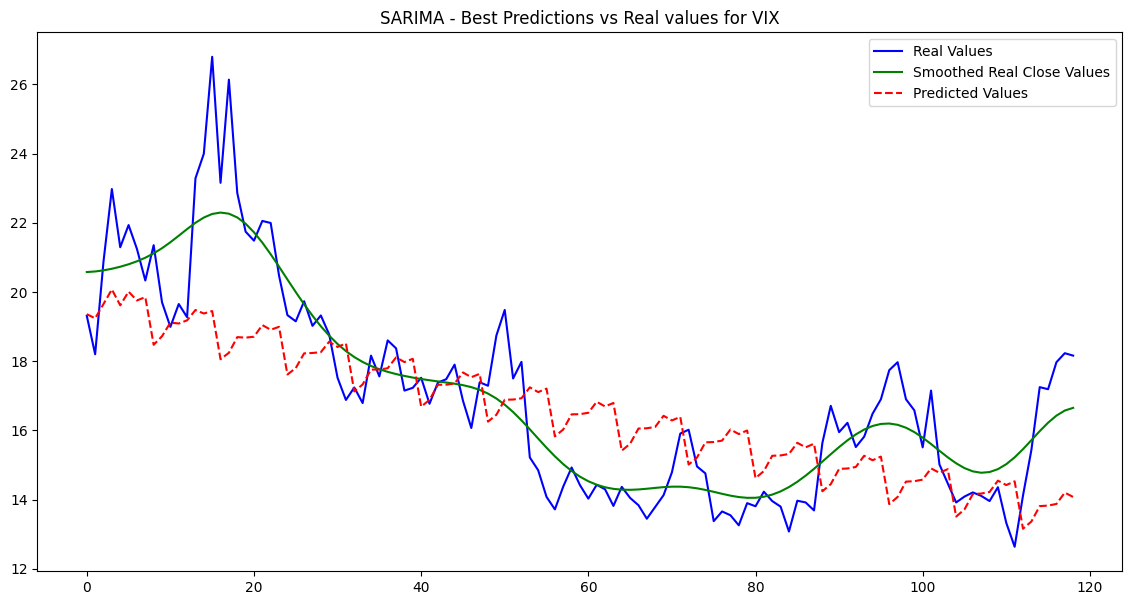

[I 2023-10-02 22:07:58,390] A new study created in memory with name: no-name-25ca9c8f-8c72-4520-9c11-b3b5d380eb36
[I 2023-10-02 22:07:58,392] Trial 0 finished with value: inf and parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 3, 's': 12}. Best is trial 0 with value: inf.


Feature: VIX - Best RMSE: 0.14098386104291682


[I 2023-10-02 22:08:03,504] Trial 1 finished with value: 0.1441733569385913 and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 3, 'D': 1, 'Q': 0, 's': 6}. Best is trial 1 with value: 0.1441733569385913.
[I 2023-10-02 22:08:05,817] Trial 2 finished with value: 1.050424962213772 and parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 3, 'D': 0, 'Q': 0, 's': 6}. Best is trial 1 with value: 0.1441733569385913.
[I 2023-10-02 22:08:21,924] Trial 3 finished with value: 0.1467220735291494 and parameters: {'p': 5, 'd': 0, 'q': 0, 'P': 3, 'D': 1, 'Q': 1, 's': 9}. Best is trial 1 with value: 0.1441733569385913.
[I 2023-10-02 22:08:32,469] Trial 4 finished with value: 0.9636708173901276 and parameters: {'p': 2, 'd': 0, 'q': 0, 'P': 5, 'D': 0, 'Q': 2, 's': 6}. Best is trial 1 with value: 0.1441733569385913.
[I 2023-10-02 22:08:32,471] Trial 5 finished with value: inf and parameters: {'p': 5, 'd': 0, 'q': 2, 'P': 3, 'D': 1, 'Q': 1, 's': 4}. Best is trial 1 with value: 0.1441733569385913.
[I 2023-10-02 22:08:40,696

[I 2023-10-02 22:14:10,584] Trial 43 finished with value: 0.10451009328144169 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 3, 'D': 1, 'Q': 4, 's': 6}. Best is trial 40 with value: 0.10451009328144169.
[I 2023-10-02 22:15:02,611] Trial 44 finished with value: 0.10451009328144169 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 3, 'D': 1, 'Q': 4, 's': 6}. Best is trial 40 with value: 0.10451009328144169.
[I 2023-10-02 22:15:23,972] Trial 45 finished with value: 0.10239347032570412 and parameters: {'p': 0, 'd': 0, 'q': 3, 'P': 3, 'D': 1, 'Q': 4, 's': 6}. Best is trial 45 with value: 0.10239347032570412.
[I 2023-10-02 22:15:45,192] Trial 46 finished with value: 0.10239347032570412 and parameters: {'p': 0, 'd': 0, 'q': 3, 'P': 3, 'D': 1, 'Q': 4, 's': 6}. Best is trial 45 with value: 0.10239347032570412.
[I 2023-10-02 22:16:24,270] Trial 47 finished with value: 0.1037951687926772 and parameters: {'p': 0, 'd': 0, 'q': 4, 'P': 3, 'D': 1, 'Q': 4, 's': 6}. Best is trial 45 with value: 0.1023934703

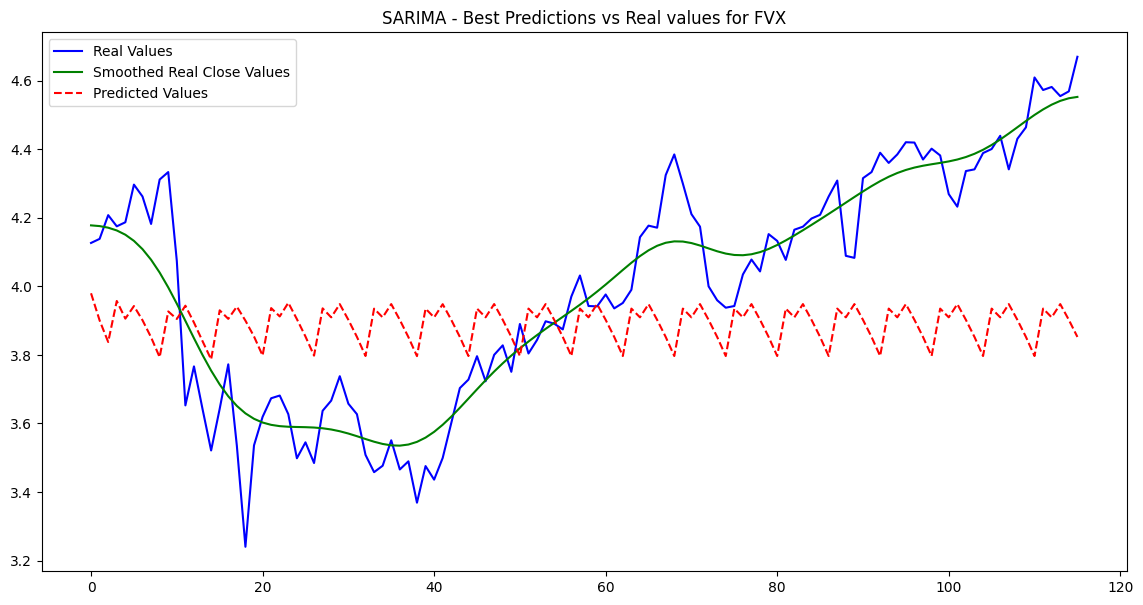

[I 2023-10-02 22:17:15,316] A new study created in memory with name: no-name-f132d1f8-9e6a-4cc4-9d96-46dcff2f42f4


Feature: FVX - Best RMSE: 0.10183620321744019


[I 2023-10-02 22:17:21,032] Trial 0 finished with value: 2.2723307623417974 and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 2, 's': 7}. Best is trial 0 with value: 2.2723307623417974.
C:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
[I 2023-10-02 22:18:26,501] Trial 1 finished with value: inf and parameters: {'p': 4, 'd': 0, 'q': 2, 'P': 3, 'D': 0, 'Q': 1, 's': 12}. Best is trial 0 with value: 2.2723307623417974.
[I 2023-10-02 22:19:06,192] Trial 2 finished with value: 0.5325896474886582 and parameters: {'p': 4, 'd': 0, 'q': 2, 'P': 3, 'D': 1, 'Q': 3, 's': 8}. Best is trial 2 with value: 0.5325896474886582.
C:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationar

[I 2023-10-02 23:11:47,603] Trial 36 finished with value: inf and parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 4, 'D': 1, 'Q': 2, 's': 11}. Best is trial 2 with value: 0.5325896474886582.
[I 2023-10-02 23:11:59,030] Trial 37 finished with value: 2.2429495557287393 and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 3, 'D': 1, 'Q': 3, 's': 6}. Best is trial 2 with value: 0.5325896474886582.
C:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
[I 2023-10-02 23:12:03,523] Trial 38 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 3, 'D': 0, 'Q': 0, 's': 8}. Best is trial 2 with value: 0.5325896474886582.
[I 2023-10-02 23:12:03,549] Trial 39 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 1, 'D': 1, 'Q': 1, 's': 12}. Best is trial 2 with value: 0.5325896474886582.
C:\Python310\lib\si

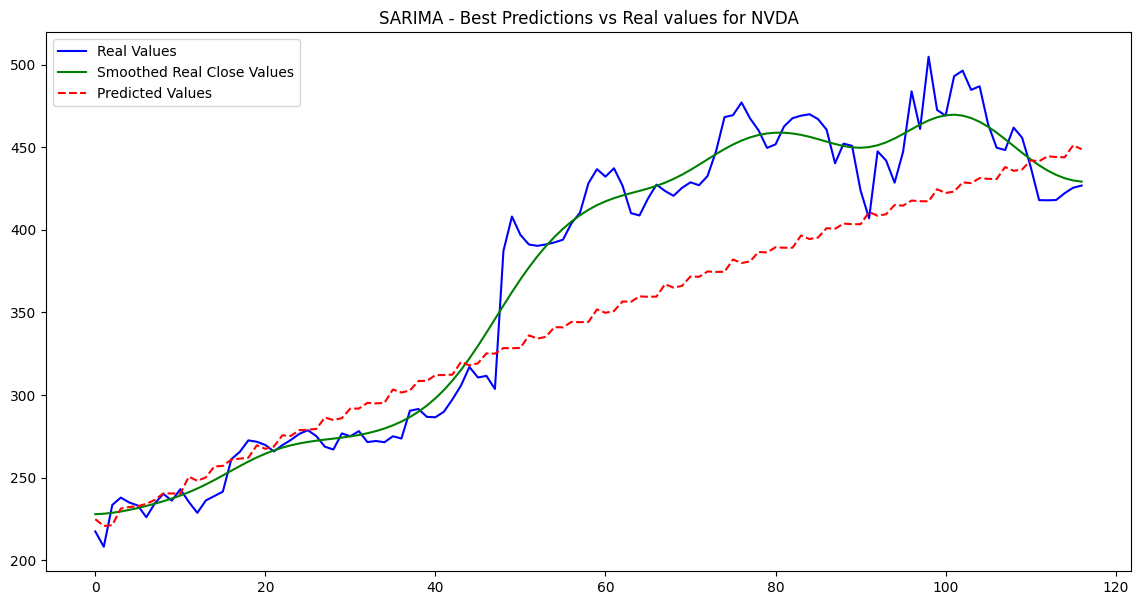

Feature: NVDA - Best RMSE: 0.5325896474886582
Entraînement des modèles SARIMA terminé.


In [26]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", "Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", "Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")
# Dictionnaires pour stocker les modèles SARIMA et leurs performances
sarima_models = {}
mse_sarima = {}
recursive_preds_sarima = {}

for index_name in final_df.columns.get_level_values(0).unique():
    def objective_sarima(trial):
        # Paramètres à optimiser
        p = trial.suggest_int('p', 0, 5)
        d = trial.suggest_int('d', 0, 1)
        q = trial.suggest_int('q', 0, 4)
        P = trial.suggest_int('P', 0, 5)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 4)
        s = trial.suggest_int('s', 2, 12)  # saisonnalité

        # Validation des hyperparamètres
        if p == P:
            return float('inf')  # retourne une valeur infinie pour indiquer un mauvais essai

        try:
            # Création du modèle SARIMA
            sarima = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
            sarima_fit = sarima.fit(disp=False, maxiter=300, method='bfgs')

            # Prédictions
            predictions = sarima_fit.forecast(steps=len(y_test))
            
            if not adf_test(predictions):
                return float('inf')  # Rejeter le modèle si les prédictions sont stationnaires
            
            smoothed_values_test = gaussian_filter1d(y_test, sigma)

            # Calcul de la RMSE
            rmse = weighted_rmse(smoothed_values_test, predictions, len(smoothed_values_test))

            return rmse

        except Exception as e:  # Attrape toutes les exceptions, y compris les problèmes de convergence ou les erreurs de spécification du modèle
            return float('inf')  # retourne une valeur infinie pour indiquer un mauvais essai

    # Sélectionner look_back optimal
    best_params = best_params_per_feature[index_name]
    look_back = best_params['look_back']
    
    # Préparer les données pour XGBoost
    # Créer un indexeur
    idx = pd.IndexSlice

    # Utiliser cet indexeur pour récupérer les données
    values = scaled_data_df.filter(like=index_name, axis=1).values
    data = series_to_supervised(values, look_back, 1)
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    # Diviser en entrées et sorties
    
    X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values
    
    
    # Création d'une étude Optuna
    study_sarima = optuna.create_study(direction='minimize')
    study_sarima.optimize(objective_sarima, n_trials=50)
    
    best_params = study_sarima.best_params
    best_rmse = study_sarima.best_value

    # Modèle SARIMA avec les meilleurs hyperparamètres
    best_model = SARIMAX(y_train, 
                          order=(best_params['p'], best_params['d'], best_params['q']), 
                          seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']))
    best_model_fit = best_model.fit(disp=False, maxiter=200, method='bfgs')
    
    # Meilleures prédictions
    best_predictions = best_model_fit.forecast(steps=len(y_test))
    
    for idx, feature_name in enumerate(['Close']):
        scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
        feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant
        
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
    
        # Inversez la mise à l'échelle

        inverse_predictions = feature_scaler.inverse_transform(np.array(best_predictions).reshape(-1, 1))
        inverse_real_values = feature_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        
        # Appliquer le filtre gaussien
        sigma = 5
        smoothed_values_test = gaussian_filter1d(y_test, sigma)
        smoothed_values = gaussian_filter1d(y_test, sigma)
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
        
        # Affichage des graphiques
        plt.figure(figsize=(14,7))
        plt.plot(inverse_real_values, label='Real Values', color='blue')
        plt.plot(smoothed_values_test, label='Smoothed Real Close Values', color='green')
        plt.plot(inverse_predictions, label='Predicted Values', color='red', linestyle='--')
        plt.title(f"SARIMA - Best Predictions vs Real values for {index_name}")
        plt.legend()
        plt.show()

        # Stocker le modèle et sa performance
        sarima_models[scaler_key] = best_model
        mse_sarima[scaler_key] = best_rmse
        recursive_preds_sarima[scaler_key] = inverse_predictions

        print(f"Feature: {index_name} - Best RMSE: {best_rmse}")
        
print("Entraînement des modèles SARIMA terminé.")

### Choix du modèle par features

In [32]:
features_choice_df = pd.DataFrame({"GRU": mse_gru, "XGBoost": mse_xgb})

best_model_per_feature = features_choice_df.idxmin(axis=1).to_frame(name='Best Model')
best_model_per_feature['MSE'] = features_choice_df.min(axis=1)


print(best_model_per_feature)

           Best Model       MSE
VIX  Close        GRU  0.252804
FVX  Close    XGBoost  0.143114
NVDA Close        GRU  1.349280


### Filtrage : comparaison avec un modèle naif

Ce n'est parce que un modèle est meilleurs que les autres qu'il est réellement pertinant, la comparaison avec un modèle naif/simpliste indiquera si le modèle est réelement performant (et pas seulement par rapport aux autres)

In [33]:
# Créer un dictionnaire avec les données de test pour chaque feature
test_data_dict = {}
for feature in scaled_data_df.columns:
    test_data_dict[feature] = test_data[feature]
    
# Dictionnaire pour regrouper toutes les prédictions récursives
all_recursive_preds = {
    'GRU': recursive_preds_gru,
    'XGBoost': recursive_preds_xgb,
    'SARIMA': recursive_preds_sarima
}

def naive_recursive_forecast(series, steps):
    """Génère des prédictions récursives en utilisant la dernière valeur connue pour `steps` prédictions."""
    predictions = [series[-1]]  # on commence avec la dernière observation
    for _ in range(steps-1):
        predictions.append(predictions[-1])
    return np.array(predictions)

mse_naive_recursive_dict = {}

for index_name in final_df.columns.get_level_values(0).unique():
    
    actual_values = data.values[1:]
    naive_predictions = naive_recursive_forecast(data.values[:-1], len(actual_values))
    mse_naive_recursive = mean_squared_error(actual_values, naive_predictions)
    mse_naive_recursive_dict[index_name] = mse_naive_recursive
    
    # Récupérer les valeurs réelles, les prédictions du modèle et les prédictions naïves
    best_model_name = best_model_per_feature.loc[(index_name, 'Close'), 'Best Model']
    best_model_predictions = all_recursive_preds[best_model_name][index_name, 'Close']
    
    actual_values = data.values
    naive_predictions = naive_recursive_forecast(data.values[:-1], len(actual_values))

# Comparer les MSE des modèles et des prévisions naïves récursives
comparison_recursive_dict = {}
for feature, row in best_model_per_feature.iterrows():
    comparison_recursive_dict[feature] = {
        'Model MSE': row['MSE'],
        'Naive Recursive MSE': mse_naive_recursive_dict[index_name],
        'Model is Better': row['MSE'] < mse_naive_recursive_dict[index_name]
    }

comparison_recursive_dict

{('VIX', 'Close'): {'Model MSE': 0.2528040193898163,
  'Naive Recursive MSE': 64.60608360695346,
  'Model is Better': True},
 ('FVX', 'Close'): {'Model MSE': 0.1431140908559981,
  'Naive Recursive MSE': 64.60608360695346,
  'Model is Better': True},
 ('NVDA', 'Close'): {'Model MSE': 1.3492802007537605,
  'Naive Recursive MSE': 64.60608360695346,
  'Model is Better': True}}

### Conclusion sur les features finales

In [34]:
# Vérifier pour quelles features le modèle naïf est meilleur
naive_better_features = [feature for feature, values in comparison_recursive_dict.items() if not values['Model is Better']]

# Afficher un message d'avertissement pour ces features
if naive_better_features:
    print("Avertissement : Pour les features suivantes, le modèle naïf a performé mieux que le modèle choisi :")
    for feature in naive_better_features:
        print(f"- {feature}")

# Modèle final : basé sur les précédentes features

#### Préparation des données

In [35]:
final_features  = []
for model_type in all_recursive_preds:
    for feature in comparison_recursive_dict:
        print("for : " + str(feature) + "/" + str(model_type) + ":" + str(all_recursive_preds[model_type][feature][0]))
        
for feature in comparison_recursive_dict:
    final_features.append(feature)

# Initialiser le dictionnaire pour stocker les scalers pour chaque feature
final_scalers = {}
print(final_features)
# Mettre à l'échelle les données pour chaque feature
final_features_with_sp500 = final_features + [('GSPC', 'Open')] + [('GSPC', 'Close')]
final_combined_data = combined_data[final_features_with_sp500].copy()

print("Combined data shape:", combined_data.shape)

for feature in final_features:
    scaler = MinMaxScaler()
    final_combined_data[feature] = scaler.fit_transform(final_combined_data[feature].values.reshape(-1, 1))
    final_scalers[feature] = scaler

# Mettre à l'échelle le SP500
sp500_scaler = RobustScaler()
final_combined_data[('GSPC', 'Open')] = sp500_scaler.fit_transform(final_combined_data[('GSPC', 'Open')].values.reshape(-1, 1))
final_combined_data[('GSPC', 'Close')] = sp500_scaler.fit_transform(final_combined_data[('GSPC', 'Close')].values.reshape(-1, 1))

final_combined_data.tail()

for : ('VIX', 'Close')/GRU:24.370693
for : ('FVX', 'Close')/GRU:3.317702
for : ('NVDA', 'Close')/GRU:175.88919
for : ('VIX', 'Close')/XGBoost:[18.740576]
for : ('FVX', 'Close')/XGBoost:[4.128667]
for : ('NVDA', 'Close')/XGBoost:[210.67175]
for : ('VIX', 'Close')/SARIMA:[19.36015924]
for : ('FVX', 'Close')/SARIMA:[3.97998373]
for : ('NVDA', 'Close')/SARIMA:[224.77485394]
[('VIX', 'Close'), ('FVX', 'Close'), ('NVDA', 'Close')]
Combined data shape: (3677, 140)


VIX       FVX      NVDA      GSPC          
               Close     Close     Close      Open     Close
Date                                                        
2023-09-22  0.112648  0.869237  0.842825  1.650767  1.635426
2023-09-25  0.108413  0.879372  0.855245  1.630320  1.646840
2023-09-26  0.137211  0.880366  0.848934  1.631805  1.604868
2023-09-27  0.127047  0.895866  0.860237  1.611930  1.605511
2023-09-28  0.114625  0.883943  0.872840  1.603402  1.622055

# Etudes des paramètres optimaux du modèle final

In [37]:
early_stopping = EarlyStopping(monitor='val_mean_directional_accuracy', mode='max', patience=10, restore_best_weights=True)

def mean_directional_accuracy(y_true, y_pred):
    # Obtenir la forme du tenseur y_true (ou y_pred, ils ont la même forme)
    y_shape = K.shape(y_true)

    # Calculer le nombre d'échantillons dans ce lot
    batch_size = y_shape[0]

    # Calculer le nombre de blocs de 10 que nous pouvons avoir
    num_blocks = batch_size // 10

    # Calculer le nombre d'échantillons à garder pour avoir un multiple de 10
    keep_samples = num_blocks * 10

    # Tronquer les tenseurs pour avoir un multiple de 10
    y_true = y_true[:keep_samples]
    y_pred = y_pred[:keep_samples]

    # Si keep_samples est 0, retourner 0 comme métrique
    if keep_samples == 0:
        return K.constant(0, dtype='float32')

    # Réorganiser en blocs de 10
    y_true_reshaped = K.reshape(y_true, (-1, 10))
    y_pred_reshaped = K.reshape(y_pred, (-1, 10))

    # Calculer la différence entre le premier et le dernier élément de chaque bloc
    true_diff = y_true_reshaped[:, -1] - y_true_reshaped[:, 0]
    pred_diff = y_pred_reshaped[:, -1] - y_pred_reshaped[:, 0]

    # Comparer les signes
    matches = K.equal(K.sign(true_diff), K.sign(pred_diff))

    # Calculer la précision directionnelle moyenne
    accuracy = K.mean(K.cast(matches, dtype='float32'))

    return accuracy

def create_sequences(data, look_back=100):
    X, y = [], []
    total_data_points = len(data) // 2 * 2  # Pour s'assurer que nous avons un nombre pair de jours à considérer
    
    for i in range(look_back, total_data_points - 1, 1):  # On avance de un en un pour prendre en compte chaque jour
        sequence_data_open = []
        sequence_data_close = []

        # Ajouter les valeurs d'ouverture et de clôture, alternées
        for j in range(i - look_back, i):
            sequence_data_open.append([data[j, -2]])  # Valeur d'ouverture
            sequence_data_close.append([data[j, -1]])  # Valeur de clôture

        # Séquence pour les autres features
        other_features_seq = data[i - look_back:i, :-2]

        # Double chaque valeur de clôture prédite pour les autres features
        other_features_seq_doubled_open = np.repeat(other_features_seq, 1, axis=0)
        other_features_seq_doubled_close = np.repeat(other_features_seq, 1, axis=0)

        # Combinez les séquences
        combined_seq_open = np.hstack([other_features_seq_doubled_open, sequence_data_open])
        combined_seq_close = np.hstack([other_features_seq_doubled_close, sequence_data_close])

        X.append(combined_seq_open)  # Remodeler pour avoir look_back x (nombre de features - 1)
        y.append(data[i, -1])  # Clôture du jour i

        X.append(combined_seq_close)  # Remodeler pour avoir look_back x (nombre de features - 1)
        y.append(data[i + 1, -2])  # Ouverture du jour i+1

    return np.array(X), np.array(y)

def create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, input_shape, use_conv1d , conv1d_filters ,conv1d_kernel_size ,use_residual_connection, attention_layer, l1_reg, l2_reg):
    inputs = Input(shape=input_shape)
    x = inputs
    if use_conv1d:
        x = Conv1D(conv1d_filters, kernel_size=conv1d_kernel_size, activation='relu')(x)
    if layer_type[0] == "GRU":
        x = Bidirectional(GRU(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    elif layer_type[0] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    x = Dropout(dropout_per_layer[0])(x)
    for i in range(1, num_layers):
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x_res = x
        if layer_type[i] == "GRU":
            x = Bidirectional(GRU(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        elif layer_type[i] == "LSTM":
            x = Bidirectional(LSTM(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        x = Dropout(dropout_per_layer[i])(x)
        if attention_layer:
            x = Attention(use_scale=True)([x, x])
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x = Add()([x, x_res])
    if layer_type[num_layers-1] == "GRU":
        x = Bidirectional(GRU(units_per_layer[num_layers-1]))(x)
    elif layer_type[num_layers-1] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[num_layers-1]))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[mean_directional_accuracy])
    return model

# Fonction pour réaliser une prédiction récursive avec le modèle final
def recursive_prediction_final_model(model, initial_input, steps, best_model_per_feature, final_scalers, look_back):
    recursive_predictions = []
    current_input = initial_input.copy()

    for step in range(steps):
        # Utilisez les X derniers jours (qu'ils soient réels ou prédits) pour faire la prédiction
        input_for_prediction = current_input[-look_back:]
        
        # Prédire la prochaine valeur du SP500 en utilisant le modèle final
        predicted_sp500_values = model.predict(input_for_prediction.reshape(1, look_back, input_for_prediction.shape[1]), verbose=0)
        recursive_predictions.append(predicted_sp500_values)

        # Mettez à jour l'entrée pour la prochaine prédiction en utilisant les meilleurs modèles pour chaque caractéristique
        new_input_row = []
        for feature in final_features:
            model_type = best_model_per_feature['Best Model'][feature]
            predicted_feature_value = all_recursive_preds[model_type][feature][step//2]

            # Mettez à l'échelle la caractéristique prédite
            scaled_feature_prediction = final_scalers[feature].transform(np.array(predicted_feature_value).reshape(-1, 1))
            new_input_row.append(scaled_feature_prediction[0][0])

        # Utilisez deux fois la valeur de clôture prédite pour les autres indices comme entrée
        #new_input_row = [item for item in new_input_row for _ in range(2)]

        # Ajouter les valeurs prédites ajustées pour le S&P 500
        new_input_row.append(predicted_sp500_values[0, 0])

        # Mettez à jour l'entrée pour la prochaine prédiction
        current_input = np.vstack([current_input[1:], np.array(new_input_row)])

    return np.array(recursive_predictions)

def objective(trial):

    # Espace de recherche
    ###############################################################################################
    look_back = trial.suggest_int('look_back', int(test_size/3), int(test_size/2) - 1)
    num_layers = trial.suggest_int('num_layers', 3, 9)
    layer_type = [trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) for i in range(num_layers)]
    units_per_layer = [trial.suggest_int(f'units_power_{i}', 7, 9) for i in range(num_layers)]
    units_per_layer = [2 ** power for power in units_per_layer]
    dropout_per_layer = [trial.suggest_float(f'dropout_{i}', 0.1, 0.3) for i in range(num_layers)]
    use_residual_connection = trial.suggest_categorical('use_residual_connection', [True, False])
    attention_layer = trial.suggest_categorical('use_attention_layer', [True, False])
    use_conv1d = trial.suggest_categorical('use_conv1d', [False, True])
    if use_conv1d:
        conv1d_filters = trial.suggest_int('conv1d_filters', 5, 7)
        conv1d_filters = 2 ** conv1d_filters
        conv1d_kernel_size = trial.suggest_int('conv1d_kernel_size', 3, 7)
    l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
    ################################################################################################
    
    # Créez des séquences en utilisant look_back
    X_train, y_train = create_sequences(final_combined_data.iloc[:train_size].values, look_back)
    X_test, y_test = create_sequences(final_combined_data.iloc[train_size:].values, look_back)
    
    n_splits = 5  # Nombre de splits
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    val_loss_list = []  # Liste pour stocker la val_loss de chaque split
        
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        if use_conv1d:
            model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), (len(reduced_df.columns) + 1)), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)
        else:
            conv1d_filters = 36
            conv1d_kernel_size = 5
            model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), (len(reduced_df.columns) + 1)), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)

        recursive_predictions = []
        
        input_sequence = X_val_fold[0].reshape(1, look_back, len(reduced_df.columns) + 1)

        history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=15, batch_size=32, verbose=0, callbacks=[early_stopping])
        
        # Obtenez la val_loss du dernier epoch
        last_val_loss = history.history['val_loss'][-1]
        val_loss_list.append(last_val_loss)
    
    mean_val_loss = np.mean(val_loss_list)  # Moyenne des val_loss sur tous les plis
    
    initial_input = X_val_fold[0]
    recursive_predictions = recursive_prediction_final_model(model, initial_input, look_back, best_model_per_feature, final_scalers, look_back) #prédictions que sur le dernier pli
    if not adf_test(recursive_predictions[:, 0][:, 0]):
        return float('inf')  # Rejeter le modèle si les prédictions sont stationnaires
    return mean_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params_final = study.best_params
top_5_trials = sorted(study.trials, key=lambda trial: trial.value)[:5]

# Affichage des résultats
print('Number of finished trials: ', len(study.trials))
for i, trial in enumerate(top_5_trials):
    print(f'Rank {i+1} - Value: {trial.value}, Params: {trial.params}')

[I 2023-10-03 00:15:14,735] A new study created in memory with name: no-name-810a1294-19d3-4d9d-ab2e-eb607944b23f
[I 2023-10-03 00:33:49,530] Trial 0 finished with value: inf and parameters: {'look_back': 79, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.16575416717558958, 'dropout_1': 0.1103135627315617, 'dropout_2': 0.132306448616674, 'dropout_3': 0.22187906480753178, 'dropout_4': 0.2261039436902576, 'dropout_5': 0.1705529591675167, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 1.492054884214809e-05, 'l2_reg': 0.007571605246576846}. Best is trial 0 with value: inf.
[I 2023-10-03 00:57:22,241] Trial 1 finished with value: 0.26355122551321986 and parame

[I 2023-10-03 04:00:14,679] Trial 10 finished with value: inf and parameters: {'look_back': 87, 'num_layers': 3, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 7, 'dropout_0': 0.24507122419764935, 'dropout_1': 0.2981946866834797, 'dropout_2': 0.17048487852229324, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 1.0233553022295116e-05, 'l2_reg': 0.000985350548984814}. Best is trial 1 with value: 0.26355122551321986.
[I 2023-10-03 04:23:29,988] Trial 11 finished with value: inf and parameters: {'look_back': 96, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 7, 'units_powe

[I 2023-10-03 07:14:41,918] Trial 19 finished with value: 0.756371483206749 and parameters: {'look_back': 78, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.2992922743923872, 'dropout_1': 0.23893610802585574, 'dropout_2': 0.28420693748292136, 'dropout_3': 0.15164230418713356, 'dropout_4': 0.1559737893682334, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.00017219902846911953, 'l2_reg': 0.0004459971354820072}. Best is trial 1 with value: 0.26355122551321986.
[I 2023-10-03 07:33:46,893] Trial 20 finished with value: inf and parameters: {'look_back': 70, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_

[I 2023-10-03 10:47:44,479] Trial 29 finished with value: inf and parameters: {'look_back': 78, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.22795420739371702, 'dropout_1': 0.27222630115537094, 'dropout_2': 0.24711194771572267, 'dropout_3': 0.10242405373860453, 'dropout_4': 0.15884865020354136, 'dropout_5': 0.27519251662447186, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 1.9504608979456728e-05, 'l2_reg': 0.011028913040592017}. Best is trial 1 with value: 0.26355122551321986.
[I 2023-10-03 11:03:01,444] Trial 30 finished with value: 0.13015069477260113 and parameters: {'look_back': 83, 'num_layers': 4, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 

[I 2023-10-03 14:13:12,893] Trial 42 finished with value: 0.1537897102534771 and parameters: {'look_back': 80, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'dropout_0': 0.245292352727541, 'dropout_1': 0.2890811446082905, 'dropout_2': 0.20000943495074378, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.00010176506022473897, 'l2_reg': 0.00032329835229891586}. Best is trial 41 with value: 0.12650710344314575.
[I 2023-10-03 14:27:16,245] Trial 43 finished with value: 0.14942369237542152 and parameters: {'look_back': 80, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'dropout_0': 0.24294659221462747, 'dropout_1': 0.2879206229927998, 'dropout_2': 0.20105959905874915, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d':

Number of finished trials:  50
Rank 1 - Value: 0.12650710344314575, Params: {'look_back': 80, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'dropout_0': 0.24349825076067558, 'dropout_1': 0.2861495007513322, 'dropout_2': 0.19782015044156115, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.00010426650158941843, 'l2_reg': 0.0003467908797394777}
Rank 2 - Value: 0.13015069477260113, Params: {'look_back': 83, 'num_layers': 4, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'dropout_0': 0.24036917110714331, 'dropout_1': 0.28557966883298647, 'dropout_2': 0.22419411589267213, 'dropout_3': 0.1198671699935698, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kerne

#### Création du modèle

Epoch 1/1000
213/213 [==============================] - 27s 97ms/step - loss: 1.9795 - mean_directional_accuracy: 0.9562 - val_loss: 0.3787 - val_mean_directional_accuracy: 0.5833
Epoch 2/1000
213/213 [==============================] - 19s 88ms/step - loss: 0.1825 - mean_directional_accuracy: 0.9671 - val_loss: 0.1284 - val_mean_directional_accuracy: 0.5833
Epoch 3/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0652 - mean_directional_accuracy: 0.9593 - val_loss: 0.0642 - val_mean_directional_accuracy: 0.5833
Epoch 4/1000
213/213 [==============================] - 19s 91ms/step - loss: 0.0481 - mean_directional_accuracy: 0.9687 - val_loss: 0.0588 - val_mean_directional_accuracy: 0.6250
Epoch 5/1000
213/213 [==============================] - 19s 91ms/step - loss: 0.0450 - mean_directional_accuracy: 0.9640 - val_loss: 0.0433 - val_mean_directional_accuracy: 0.5833
Epoch 6/1000
213/213 [==============================] - 20s 94ms/step - loss: 0.0439 - mean_directio

213/213 [==============================] - 19s 90ms/step - loss: 0.0498 - mean_directional_accuracy: 0.9671 - val_loss: 0.0486 - val_mean_directional_accuracy: 0.7083
Epoch 47/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0453 - mean_directional_accuracy: 0.9640 - val_loss: 0.0444 - val_mean_directional_accuracy: 0.7500
Epoch 48/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0413 - mean_directional_accuracy: 0.9765 - val_loss: 0.0414 - val_mean_directional_accuracy: 0.7500
Epoch 49/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0394 - mean_directional_accuracy: 0.9671 - val_loss: 0.0388 - val_mean_directional_accuracy: 0.7917
Epoch 50/1000
213/213 [==============================] - 20s 93ms/step - loss: 0.0386 - mean_directional_accuracy: 0.9718 - val_loss: 0.0357 - val_mean_directional_accuracy: 0.7083
Epoch 51/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0375 - mean_directional_accu

213/213 [==============================] - 19s 91ms/step - loss: 0.0442 - mean_directional_accuracy: 0.9656 - val_loss: 0.0605 - val_mean_directional_accuracy: 0.6667
Epoch 92/1000
213/213 [==============================] - 20s 95ms/step - loss: 0.2371 - mean_directional_accuracy: 0.9405 - val_loss: 0.1858 - val_mean_directional_accuracy: 0.6667
Epoch 93/1000
213/213 [==============================] - 20s 95ms/step - loss: 0.1113 - mean_directional_accuracy: 0.9515 - val_loss: 0.0743 - val_mean_directional_accuracy: 0.6667
Epoch 94/1000
213/213 [==============================] - 20s 94ms/step - loss: 0.0719 - mean_directional_accuracy: 0.9531 - val_loss: 0.0572 - val_mean_directional_accuracy: 0.6667
Epoch 95/1000
213/213 [==============================] - 20s 93ms/step - loss: 0.0545 - mean_directional_accuracy: 0.9421 - val_loss: 0.0556 - val_mean_directional_accuracy: 0.7083
Epoch 96/1000
213/213 [==============================] - 21s 97ms/step - loss: 0.0521 - mean_directional_accu

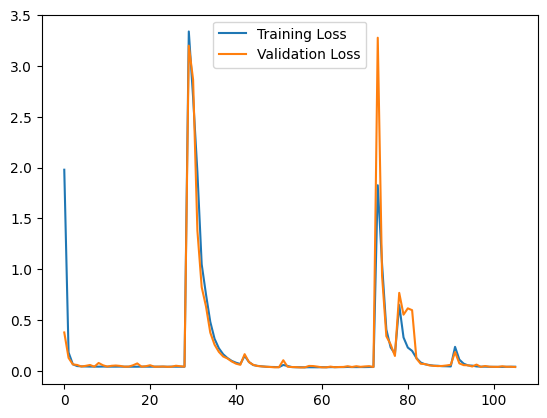

Epoch 1/1000
213/213 [==============================] - 27s 98ms/step - loss: 1.8535 - mean_directional_accuracy: 0.9546 - val_loss: 0.2540 - val_mean_directional_accuracy: 0.5417
Epoch 2/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.1190 - mean_directional_accuracy: 0.9671 - val_loss: 0.0592 - val_mean_directional_accuracy: 0.5833
Epoch 3/1000
213/213 [==============================] - 19s 87ms/step - loss: 0.0533 - mean_directional_accuracy: 0.9750 - val_loss: 0.1074 - val_mean_directional_accuracy: 0.6250
Epoch 4/1000
213/213 [==============================] - 19s 88ms/step - loss: 0.0471 - mean_directional_accuracy: 0.9562 - val_loss: 0.0582 - val_mean_directional_accuracy: 0.6250
Epoch 5/1000
213/213 [==============================] - 19s 88ms/step - loss: 0.0453 - mean_directional_accuracy: 0.9703 - val_loss: 0.0432 - val_mean_directional_accuracy: 0.6250
Epoch 6/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0434 - mean_directio

213/213 [==============================] - 20s 94ms/step - loss: 0.0791 - mean_directional_accuracy: 0.9296 - val_loss: 0.0614 - val_mean_directional_accuracy: 0.7083
Epoch 47/1000
213/213 [==============================] - 20s 96ms/step - loss: 0.0725 - mean_directional_accuracy: 0.9327 - val_loss: 0.0633 - val_mean_directional_accuracy: 0.7083
Epoch 48/1000
213/213 [==============================] - 19s 91ms/step - loss: 0.2817 - mean_directional_accuracy: 0.9374 - val_loss: 0.6134 - val_mean_directional_accuracy: 0.7083
Epoch 49/1000
213/213 [==============================] - 19s 87ms/step - loss: 1.2338 - mean_directional_accuracy: 0.9045 - val_loss: 0.8419 - val_mean_directional_accuracy: 0.7500
Epoch 50/1000
213/213 [==============================] - 19s 87ms/step - loss: 0.5507 - mean_directional_accuracy: 0.9030 - val_loss: 0.3514 - val_mean_directional_accuracy: 0.7083
Epoch 51/1000
213/213 [==============================] - 19s 88ms/step - loss: 0.3940 - mean_directional_accu

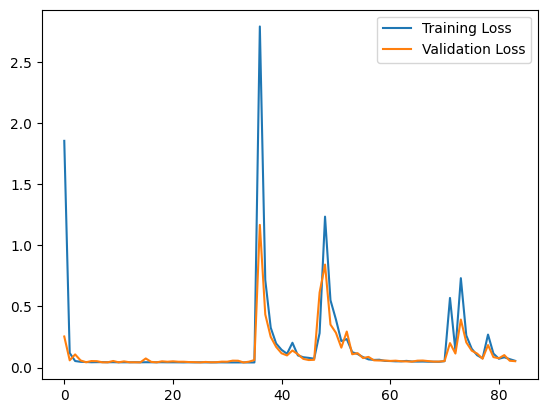

Epoch 1/1000
213/213 [==============================] - 27s 100ms/step - loss: 2.3260 - mean_directional_accuracy: 0.9687 - val_loss: 0.5636 - val_mean_directional_accuracy: 0.5417
Epoch 2/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.2922 - mean_directional_accuracy: 0.9671 - val_loss: 0.1335 - val_mean_directional_accuracy: 0.5000
Epoch 3/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0883 - mean_directional_accuracy: 0.9577 - val_loss: 0.0635 - val_mean_directional_accuracy: 0.5417
Epoch 4/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0504 - mean_directional_accuracy: 0.9656 - val_loss: 0.0449 - val_mean_directional_accuracy: 0.5833
Epoch 5/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0446 - mean_directional_accuracy: 0.9484 - val_loss: 0.0426 - val_mean_directional_accuracy: 0.5833
Epoch 6/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0445 - mean_directi

213/213 [==============================] - 19s 89ms/step - loss: 0.0409 - mean_directional_accuracy: 0.9781 - val_loss: 0.0433 - val_mean_directional_accuracy: 0.7083
Epoch 47/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0408 - mean_directional_accuracy: 0.9765 - val_loss: 0.0409 - val_mean_directional_accuracy: 0.7083
Epoch 48/1000
213/213 [==============================] - 19s 92ms/step - loss: 0.0406 - mean_directional_accuracy: 0.9765 - val_loss: 0.0514 - val_mean_directional_accuracy: 0.7083
Epoch 49/1000
213/213 [==============================] - 20s 92ms/step - loss: 0.0408 - mean_directional_accuracy: 0.9828 - val_loss: 0.0439 - val_mean_directional_accuracy: 0.7083
Epoch 50/1000
213/213 [==============================] - 20s 93ms/step - loss: 0.0405 - mean_directional_accuracy: 0.9828 - val_loss: 0.0434 - val_mean_directional_accuracy: 0.7083
Epoch 51/1000
213/213 [==============================] - 20s 92ms/step - loss: 0.0406 - mean_directional_accu

213/213 [==============================] - 19s 90ms/step - loss: 7.5479 - mean_directional_accuracy: 0.9546 - val_loss: 7.5403 - val_mean_directional_accuracy: 0.5833
Epoch 92/1000
213/213 [==============================] - 19s 89ms/step - loss: 7.5404 - mean_directional_accuracy: 0.9499 - val_loss: 7.5329 - val_mean_directional_accuracy: 0.5833
Epoch 93/1000
213/213 [==============================] - 19s 90ms/step - loss: 7.5366 - mean_directional_accuracy: 0.9499 - val_loss: 7.5351 - val_mean_directional_accuracy: 0.5833
Epoch 94/1000
213/213 [==============================] - 19s 89ms/step - loss: 7.5237 - mean_directional_accuracy: 0.9484 - val_loss: 7.5178 - val_mean_directional_accuracy: 0.5833
Epoch 95/1000
213/213 [==============================] - 19s 90ms/step - loss: 7.5312 - mean_directional_accuracy: 0.9327 - val_loss: 7.5236 - val_mean_directional_accuracy: 0.5833
Epoch 96/1000
213/213 [==============================] - 19s 91ms/step - loss: 7.5064 - mean_directional_accu

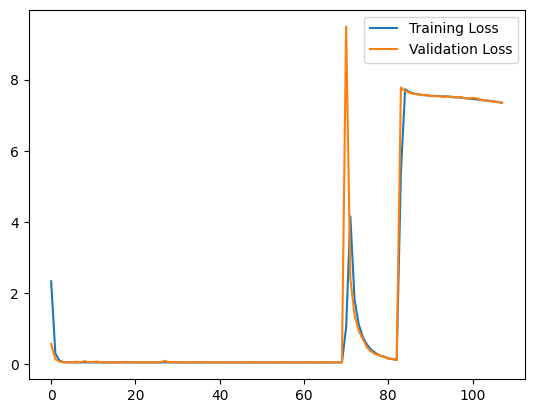

Epoch 1/1000
213/213 [==============================] - 30s 97ms/step - loss: 2.0256 - mean_directional_accuracy: 0.9577 - val_loss: 0.3634 - val_mean_directional_accuracy: 0.5833
Epoch 2/1000
213/213 [==============================] - 19s 91ms/step - loss: 0.1695 - mean_directional_accuracy: 0.9718 - val_loss: 0.0876 - val_mean_directional_accuracy: 0.5833
Epoch 3/1000
213/213 [==============================] - 19s 91ms/step - loss: 0.0587 - mean_directional_accuracy: 0.9718 - val_loss: 0.0530 - val_mean_directional_accuracy: 0.5833
Epoch 4/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0462 - mean_directional_accuracy: 0.9734 - val_loss: 0.0671 - val_mean_directional_accuracy: 0.6250
Epoch 5/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0446 - mean_directional_accuracy: 0.9703 - val_loss: 0.0610 - val_mean_directional_accuracy: 0.5833
Epoch 6/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0443 - mean_directio

213/213 [==============================] - 19s 89ms/step - loss: 0.0467 - mean_directional_accuracy: 0.9828 - val_loss: 0.0598 - val_mean_directional_accuracy: 0.6667
Epoch 47/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0449 - mean_directional_accuracy: 0.9734 - val_loss: 0.0477 - val_mean_directional_accuracy: 0.6667
Epoch 48/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0432 - mean_directional_accuracy: 0.9750 - val_loss: 0.0453 - val_mean_directional_accuracy: 0.6667
Epoch 49/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0421 - mean_directional_accuracy: 0.9844 - val_loss: 0.0467 - val_mean_directional_accuracy: 0.6667
Epoch 50/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0414 - mean_directional_accuracy: 0.9781 - val_loss: 0.0465 - val_mean_directional_accuracy: 0.6667
Epoch 51/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0405 - mean_directional_accu

213/213 [==============================] - 20s 95ms/step - loss: 0.0382 - mean_directional_accuracy: 0.9797 - val_loss: 0.0426 - val_mean_directional_accuracy: 0.5417
Epoch 92/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0382 - mean_directional_accuracy: 0.9687 - val_loss: 0.0446 - val_mean_directional_accuracy: 0.5000
Epoch 93/1000
213/213 [==============================] - 20s 92ms/step - loss: 0.0437 - mean_directional_accuracy: 0.9014 - val_loss: 0.0425 - val_mean_directional_accuracy: 0.5000
Epoch 94/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0397 - mean_directional_accuracy: 0.9703 - val_loss: 0.0589 - val_mean_directional_accuracy: 0.5000
Epoch 95/1000
213/213 [==============================] - 19s 88ms/step - loss: 0.0407 - mean_directional_accuracy: 0.9687 - val_loss: 0.0405 - val_mean_directional_accuracy: 0.5000
Epoch 96/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0476 - mean_directional_accu

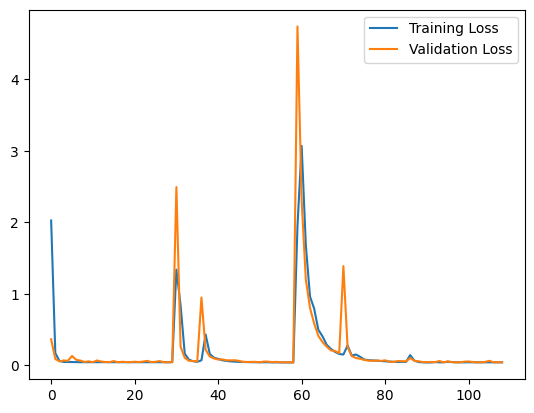

Epoch 1/1000
213/213 [==============================] - 26s 96ms/step - loss: 2.0519 - mean_directional_accuracy: 0.9640 - val_loss: 0.3706 - val_mean_directional_accuracy: 0.5833
Epoch 2/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.1810 - mean_directional_accuracy: 0.9531 - val_loss: 0.1057 - val_mean_directional_accuracy: 0.5833
Epoch 3/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0604 - mean_directional_accuracy: 0.9718 - val_loss: 0.0551 - val_mean_directional_accuracy: 0.5833
Epoch 4/1000
213/213 [==============================] - 19s 92ms/step - loss: 0.0456 - mean_directional_accuracy: 0.9656 - val_loss: 0.0430 - val_mean_directional_accuracy: 0.5833
Epoch 5/1000
213/213 [==============================] - 20s 95ms/step - loss: 0.0449 - mean_directional_accuracy: 0.9624 - val_loss: 0.0564 - val_mean_directional_accuracy: 0.6250
Epoch 6/1000
213/213 [==============================] - 20s 94ms/step - loss: 0.0437 - mean_directio

213/213 [==============================] - 19s 91ms/step - loss: 0.0407 - mean_directional_accuracy: 0.9797 - val_loss: 0.0432 - val_mean_directional_accuracy: 0.7083
Epoch 47/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0408 - mean_directional_accuracy: 0.9765 - val_loss: 0.0451 - val_mean_directional_accuracy: 0.7083
Epoch 48/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0408 - mean_directional_accuracy: 0.9734 - val_loss: 0.0404 - val_mean_directional_accuracy: 0.7083
Epoch 49/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0407 - mean_directional_accuracy: 0.9703 - val_loss: 0.0410 - val_mean_directional_accuracy: 0.7083
Epoch 50/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0405 - mean_directional_accuracy: 0.9844 - val_loss: 0.0414 - val_mean_directional_accuracy: 0.7083
Epoch 51/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0404 - mean_directional_accu

213/213 [==============================] - 20s 93ms/step - loss: 0.0401 - mean_directional_accuracy: 0.9687 - val_loss: 0.0459 - val_mean_directional_accuracy: 0.7500
Epoch 92/1000
213/213 [==============================] - 20s 95ms/step - loss: 0.0403 - mean_directional_accuracy: 0.9828 - val_loss: 0.0424 - val_mean_directional_accuracy: 0.7500
Epoch 93/1000
213/213 [==============================] - 20s 94ms/step - loss: 0.0402 - mean_directional_accuracy: 0.9828 - val_loss: 0.0401 - val_mean_directional_accuracy: 0.7500
Epoch 94/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0404 - mean_directional_accuracy: 0.9765 - val_loss: 0.0415 - val_mean_directional_accuracy: 0.7083
Epoch 95/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0402 - mean_directional_accuracy: 0.9797 - val_loss: 0.0508 - val_mean_directional_accuracy: 0.7500
Epoch 96/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0401 - mean_directional_accu

213/213 [==============================] - 19s 89ms/step - loss: 0.0400 - mean_directional_accuracy: 0.9875 - val_loss: 0.0443 - val_mean_directional_accuracy: 0.7083
Epoch 137/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.1138 - mean_directional_accuracy: 0.9280 - val_loss: 0.0659 - val_mean_directional_accuracy: 0.7083
Epoch 138/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0649 - mean_directional_accuracy: 0.9515 - val_loss: 0.0593 - val_mean_directional_accuracy: 0.6667
Epoch 139/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0504 - mean_directional_accuracy: 0.9718 - val_loss: 0.0461 - val_mean_directional_accuracy: 0.7083
Epoch 140/1000
213/213 [==============================] - 19s 91ms/step - loss: 0.0466 - mean_directional_accuracy: 0.9562 - val_loss: 0.0484 - val_mean_directional_accuracy: 0.6667
Epoch 141/1000
213/213 [==============================] - 20s 95ms/step - loss: 0.0451 - mean_directional

213/213 [==============================] - 19s 90ms/step - loss: 0.0389 - mean_directional_accuracy: 0.9828 - val_loss: 0.0388 - val_mean_directional_accuracy: 0.7083
Epoch 182/1000
213/213 [==============================] - 20s 92ms/step - loss: 0.0388 - mean_directional_accuracy: 0.9781 - val_loss: 0.0401 - val_mean_directional_accuracy: 0.7083
Epoch 183/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.0390 - mean_directional_accuracy: 0.9750 - val_loss: 0.0451 - val_mean_directional_accuracy: 0.7083
Epoch 184/1000
213/213 [==============================] - 19s 89ms/step - loss: 0.0389 - mean_directional_accuracy: 0.9875 - val_loss: 0.0397 - val_mean_directional_accuracy: 0.7083
Epoch 185/1000
213/213 [==============================] - 19s 88ms/step - loss: 0.0389 - mean_directional_accuracy: 0.9750 - val_loss: 0.0410 - val_mean_directional_accuracy: 0.7083
Epoch 186/1000
213/213 [==============================] - 19s 88ms/step - loss: 0.0390 - mean_directional

213/213 [==============================] - 19s 90ms/step - loss: 0.8293 - mean_directional_accuracy: 0.9390 - val_loss: 0.6919 - val_mean_directional_accuracy: 0.7083
Epoch 227/1000
213/213 [==============================] - 20s 96ms/step - loss: 0.5827 - mean_directional_accuracy: 0.9531 - val_loss: 0.4962 - val_mean_directional_accuracy: 0.7083
Epoch 228/1000
213/213 [==============================] - 20s 96ms/step - loss: 0.4431 - mean_directional_accuracy: 0.9656 - val_loss: 0.4482 - val_mean_directional_accuracy: 0.6667
Epoch 229/1000
213/213 [==============================] - 20s 96ms/step - loss: 0.3563 - mean_directional_accuracy: 0.9437 - val_loss: 0.3115 - val_mean_directional_accuracy: 0.7083
Epoch 230/1000
213/213 [==============================] - 20s 92ms/step - loss: 0.2867 - mean_directional_accuracy: 0.9656 - val_loss: 0.2589 - val_mean_directional_accuracy: 0.7500
Epoch 231/1000
213/213 [==============================] - 19s 90ms/step - loss: 0.2368 - mean_directional

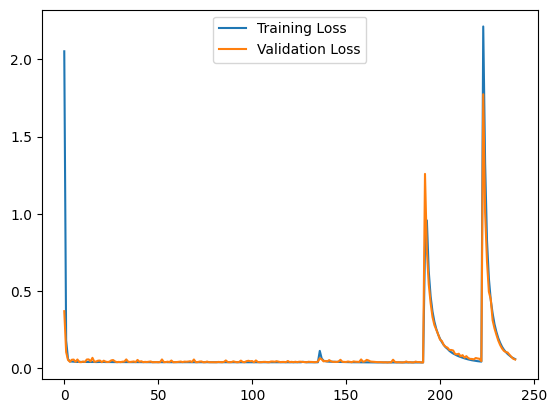

In [38]:
all_predictions = []
final_close_predictions = []
final_models = []
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



for i, trial in enumerate(top_5_trials):
    best_params = trial.params
    
    # Créer le modèle de réseau neuronal
    final_model = create_model(
            num_layers = best_params_final['num_layers'],
            units_per_layer=[2 ** (best_params_final[f'units_power_{i}']) for i in range(int(best_params_final['num_layers']))],
            layer_type=[best_params_final[f'layer_type_{i}'] for i in range(best_params_final['num_layers'])],
            dropout_per_layer=[best_params_final[f'dropout_{i}'] for i in range(best_params_final['num_layers'])],
            input_shape=((best_params_final['look_back']), (len(reduced_df.columns) + 1)),
            use_conv1d=best_params_final['use_conv1d'],
            conv1d_filters=2 ** best_params_final.get('conv1d_filters', 0),
            conv1d_kernel_size=best_params_final.get('conv1d_kernel_size', None),
            use_residual_connection=best_params_final['use_residual_connection'],
            attention_layer=best_params_final['use_attention_layer'],
            l1_reg=best_params_final['l1_reg'],
            l2_reg=best_params_final['l2_reg']
    )
    
    #Création de séquences

    X_train_final, y_train_final = create_sequences(final_combined_data.iloc[:train_size].values, best_params_final['look_back'])
    X_test_final, y_test_final = create_sequences(final_combined_data.iloc[train_size:].values, best_params_final['look_back'])

    history = final_model.fit(
        X_train_final, y_train_final,
        validation_data=(X_test_final, y_test_final),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stopping]
    )

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()
    
    # Initialiser l'entrée récursive avec les dernières valeurs réelles des caractéristiques filtrées et la valeur du SP500 de la veille
    initial_input_features = final_combined_data[final_features].iloc[-(best_params_final['look_back']):].values
    initial_input_sp500_close = final_combined_data[('GSPC', 'Close')].iloc[-(best_params_final['look_back']):].values.reshape(-1, 1)
    initial_input_sp500_open = final_combined_data[('GSPC', 'Open')].iloc[-(best_params_final['look_back']):].values.reshape(-1, 1)

    # Alternance des valeurs 'Close' et 'Open'
    initial_input_sp500 = np.column_stack((initial_input_sp500_close, initial_input_sp500_open)).ravel().reshape(-1, 1)

    # Concaténer les caractéristiques et la valeur du SP500 pour former l'entrée récursive initiale
    initial_input = np.hstack([np.repeat(initial_input_features, 2, axis=0), initial_input_sp500])


    # Effectuer la prédiction récursive avec le modèle final
    last_n_real_values_sp500 = combined_data[('GSPC', 'Close')].iloc[-10-len(y_test_final):].values.flatten()
    predictions = recursive_prediction_final_model(final_model, initial_input, best_params_final['look_back'], best_model_per_feature, final_scalers, best_params_final['look_back'])
    
    # Ne conserver que les prédictions de clôture (positions impaires)
    close_predictions = predictions[1::2]  # Commence à l'index 1 et prend chaque deuxième élément à partir de là
    final_close_predictions.append(close_predictions)
    
    all_predictions.append(predictions)
    final_models.append(final_model)


#### Utiliser la médiane des prédictions

In [172]:
median_predictions = np.median(np.array(all_predictions), axis=0)

In [173]:
#Appliquer le filtre gaussien aux données réelles
smoothed_real_values = gaussian_filter1d(real_values, sigma=5)

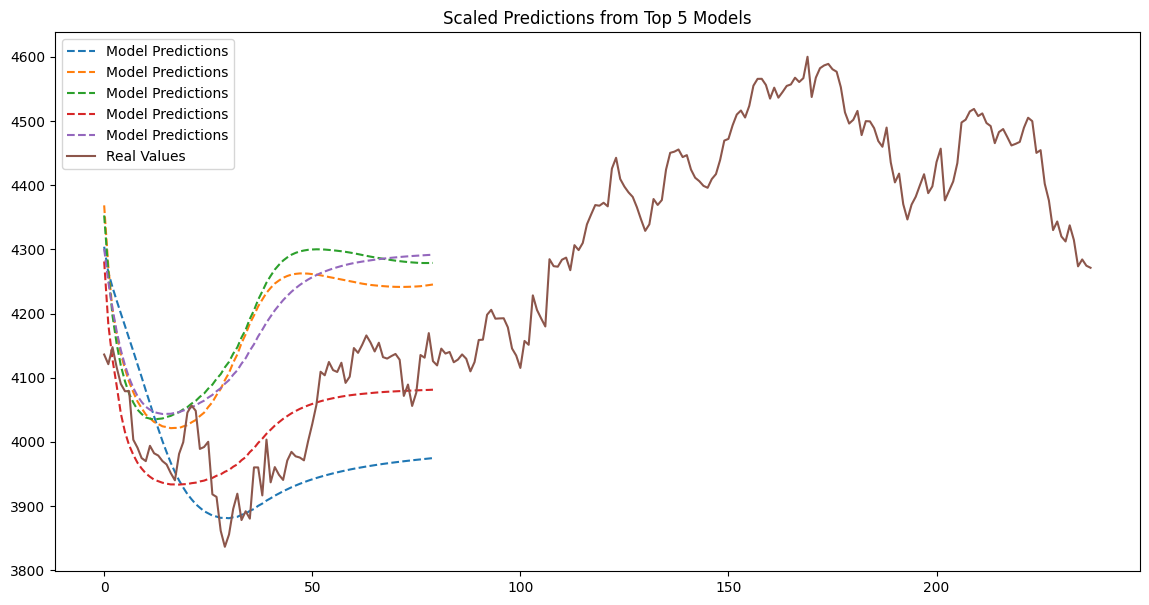

In [189]:
plt.figure(figsize=(14, 7))

for predictions in all_predictions:
    
    predictions_close = predictions[:, 0]
    predictions_close_inverse = sp500_scaler.inverse_transform(predictions_close)
    plt.plot(predictions_close_inverse[:, 0], label='Model Predictions', linestyle='--')

# Inverser la mise à l'échelle des valeurs réelles (y_test_final)
inverse_real_values = sp500_scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Extraire les valeurs de clôture
inverse_real_values_close = inverse_real_values[:, 0]
plt.plot(inverse_real_values_close, label='Real Values')
plt.legend()

plt.title('Scaled Predictions from Top 5 Models')

plt.show()


#### Graphique comparatif avec les valeurs réelles

In [175]:
inverse_final_predictions = sp500_scaler.inverse_transform(median_predictions[:,0])
print(inverse_final_predictions.shape)

(80, 1)


In [176]:
# Afficher les dernières valeurs réelles pour chaque feature (y compris le SP500)
print("Dernières valeurs réelles :")
for feature in final_features:
    real_value = combined_data[feature].iloc[-1-len(y_test)]
    print(f"{feature}: {real_value}")

real_sp500 = combined_data[('GSPC', 'Close')].iloc[-1-len(y_test)]
print(f"GSPC_Close: {real_sp500}")

print("\nPremières valeurs prédites :")
# Afficher les premières valeurs prédites pour chaque feature
for feature in final_features:
    model_type = best_model_per_feature['Best Model'][feature]
    predicted_feature_value = all_recursive_preds[model_type][feature][0]
    # Inversez la mise à l'échelle pour la caractéristique prédite
    print(f"{feature}: {predicted_feature_value}")

# Afficher la première valeur prédite pour le SP500
predicted_sp500_value = median_predictions[0]
inverse_sp500_prediction = sp500_scaler.inverse_transform(np.array(predicted_sp500_value).reshape(-1, 1))
print(f"GSPC_Close (avant correction): {inverse_sp500_prediction[0][0]}")

Dernières valeurs réelles :
('VIX', 'Close'): 20.170000076293945
('FVX', 'Close'): 4.047999858856201
('NVDA', 'Close'): 220.02000427246094
GSPC_Close: 4090.409912109375

Premières valeurs prédites :
('VIX', 'Close'): 24.37069320678711
('FVX', 'Close'): [4.128667]
('NVDA', 'Close'): 175.88919067382812
GSPC_Close (avant correction): 4304.109375


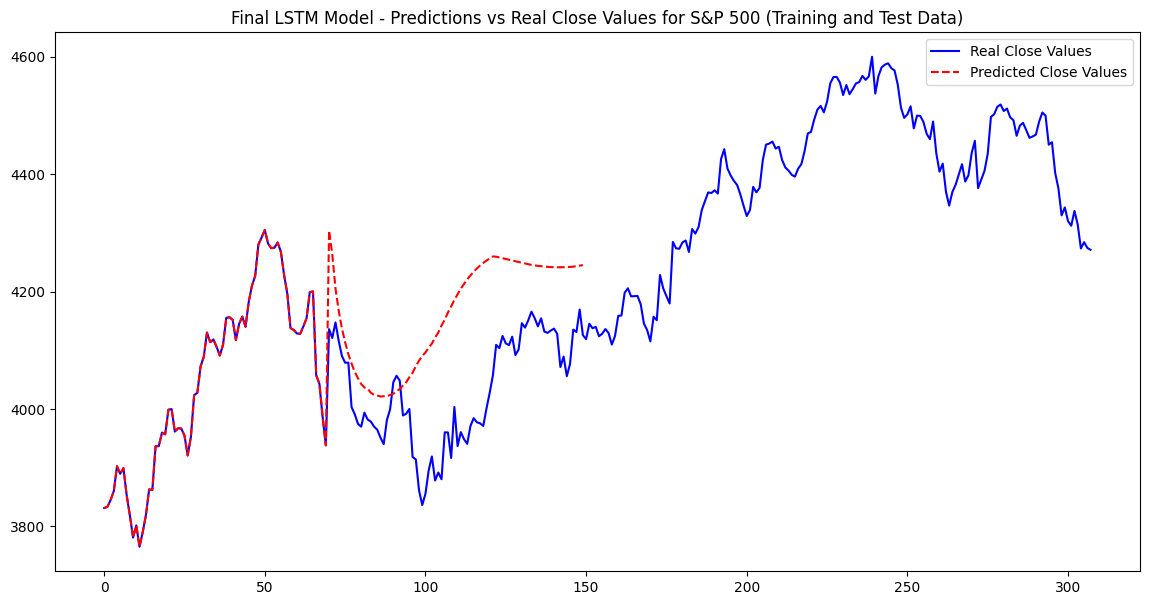

array([3938.2341, 3897.9065, 3839.3337, 3801.618 , 3771.5007, 3747.866 ,
       3727.4802, 3711.6252, 3697.265 , 3686.7244, 3676.7717, 3670.9373,
       3668.89  , 3661.9065, 3658.4353, 3657.154 , 3655.5305, 3655.8967,
       3655.7498, 3658.301 , 3660.2092, 3664.5818, 3668.2087, 3674.3772,
       3679.6204, 3688.3894, 3695.9363, 3707.0632, 3716.6116, 3724.7112,
       3730.427 , 3738.7864, 3745.7156, 3755.9944, 3764.5188, 3776.3816,
       3786.2502, 3798.5422, 3808.863 , 3820.0935, 3829.6013, 3839.0637,
       3847.18  , 3854.9573, 3861.7112, 3868.0378, 3873.5408, 3878.5955,
       3883.0403, 3887.116 , 3890.721 , 3894.0369, 3893.6453, 3892.4246,
       3891.0046, 3889.7747, 3888.4382, 3887.1711, 3885.8816, 3884.5642,
       3883.328 , 3881.9602, 3880.7039, 3879.6633, 3878.6882, 3878.0173,
       3877.3752, 3876.825 , 3876.346 , 3875.9714, 3875.6946, 3875.5984,
       3875.6008, 3875.7444, 3875.9666, 3876.2805, 3876.715 , 3877.536 ,
       3878.4148, 3879.3708], dtype=float32)

In [187]:
inverse_final_predictions_close = inverse_final_predictions[:, 0]
# Utilisez le scaler pour inverser la mise à l'échelle des dernières valeurs réelles de l'ensemble d'entraînement pour le S&P 500
last_real_values_train_scaled = y_train_final
last_real_values_train = sp500_scaler.inverse_transform(last_real_values_train_scaled.reshape(-1, 1))[:, 0]  # On prend seulement les valeurs de clôture

# Inverser la mise à l'échelle des valeurs réelles (y_test_final)
inverse_real_values = sp500_scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Extraire les valeurs de clôture
inverse_real_values_close = inverse_real_values[:, 0]

# Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les vraies valeurs de l'ensemble de test
real_values = np.concatenate([last_real_values_train, inverse_real_values_close])


#inverse_final_predictions_close = inverse_final_predictions_close -(inverse_final_predictions_close[0] - last_real_values_train[-1])

# Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les valeurs prédites
predicted_values = np.concatenate([last_real_values_train, inverse_final_predictions_close])

inverse_final_predictions_close = inverse_final_predictions_close -(inverse_final_predictions_close[0] - last_real_values_train[-1])
plt.figure(figsize=(14,7))

# Tracer les valeurs réelles
plt.plot(real_values[-150 - (len(real_values) - len(predicted_values)):], label='Real Close Values', color='blue')
# Tracer les valeurs prédites
plt.plot(predicted_values[-150:], label='Predicted Close Values', color='red', linestyle='--')

plt.title("Final LSTM Model - Predictions vs Real Close Values for S&P 500 (Training and Test Data)")
plt.legend()
plt.show()

inverse_final_predictions_close

#### Métrique d'évaluation:

In [188]:
min_length = min(len(inverse_real_values_close), len(inverse_final_predictions_close))
mse = mean_squared_error(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])
rmse = np.sqrt(mse)
mae = mean_absolute_error(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])
r2 = r2_score(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])

print(f"Erreur quadratique moyenne MSE: {mse}")
print(f"Racine de l'erreur quadratique moyenne RMSE: {rmse}")
print(f"Erreur absolue moyenne MAE: {mae}")
print(f"Coefficient de détermination R²: {r2}")

Erreur quadratique moyenne MSE: 59291.409690301356
Racine de l'erreur quadratique moyenne RMSE: 243.49827451195904
Erreur absolue moyenne MAE: 229.65841796231925
Coefficient de détermination R²: -6.37807000513784


# Simulation Gain/Perte (ajouter méchanisme d'anticipation)

In [179]:
def simulate_trading_strategy(predictions, actual_prices, min_yield=0.000117, stop_loss=0.05, 
                              take_profit=0.05, transaction_fee=0.001, anticipation_days=2, delay_days=2):
    capital = 150
    realized_gain = [0]  # Gain that is realized by selling
    stock_quantity = 0  # Number of stocks owned
    capital_over_time = [capital]  # Track capital over time
    realized_gain_over_time = [realized_gain]  # Track realized gain over time

    last_price = actual_prices[0]

    for i in range(1, len(predictions)):

        if i % 5 != 0:
            continue

        start_window = max(0, i - anticipation_days)
        end_window = min(len(predictions) - 1, i + delay_days)
        
        window_predictions = predictions[start_window:end_window + 1]
        window_actuals = actual_prices[start_window:end_window + 1]
        
        mean_prediction = np.mean(window_predictions)
        mean_actual = np.mean(window_actuals)

        pred_today = mean_prediction
        pred_yesterday = predictions[i - 5]
        actual_today = mean_actual
        actual_yesterday = actual_prices[i - 5]
        
        expected_return = (pred_today - pred_yesterday) / pred_yesterday
        actual_return = (actual_today - actual_yesterday) / actual_yesterday

        if expected_return > min_yield and actual_return > min_yield:
            confidence_factor = 1.2
        else:
            confidence_factor = 1.0

        dynamic_stop_loss = stop_loss * confidence_factor
        dynamic_take_profit = take_profit * confidence_factor

        if stock_quantity > 0:
            gain_loss = (actual_today - last_price) / last_price

            if gain_loss >= dynamic_take_profit:
                capital += stock_quantity * actual_today * (1 - transaction_fee)
                realized_gain += stock_quantity * (actual_today - last_price)
                stock_quantity = 0

            elif gain_loss <= -dynamic_stop_loss:
                capital += stock_quantity * actual_today * (1 - transaction_fee)
                realized_gain += stock_quantity * (actual_today - last_price)
                stock_quantity = 0

        if expected_return > min_yield and capital > 0:
            buy_quantity = capital / actual_today
            capital -= buy_quantity * actual_today
            stock_quantity += buy_quantity
            last_price = actual_today

            print(f"Buy executed on day {i}. New stock quantity : {stock_quantity}")
            
        if expected_return < -min_yield and stock_quantity > 0:
            sell_quantity = stock_quantity  # sell all stocks
            capital += sell_quantity * actual_today  # Add to capital
            stock_quantity = 0  # Reset stock quantity
            last_price = actual_today  # Update the last price when a stock is sold
            print(f"Sell executed on day {i}. New stock quantity : 0")

        total_capital = capital + stock_quantity * actual_today
        capital_over_time.append(total_capital)
        realized_gain_over_time.append(realized_gain[0])

    strategy_returns = np.diff(np.array(capital_over_time)) / np.array(capital_over_time)[:-1]
    return strategy_returns, capital_over_time, realized_gain_over_time

strategy_returns, capital_over_time, realized_gain_over_time = simulate_trading_strategy(inverse_final_predictions_close, inverse_real_values)
realized_gain_over_time[0] = 0

Buy executed on day 20. New stock quantity : 0.03725474104029934
Sell executed on day 55. New stock quantity : 0
Buy executed on day 75. New stock quantity : 0.03740682034331001


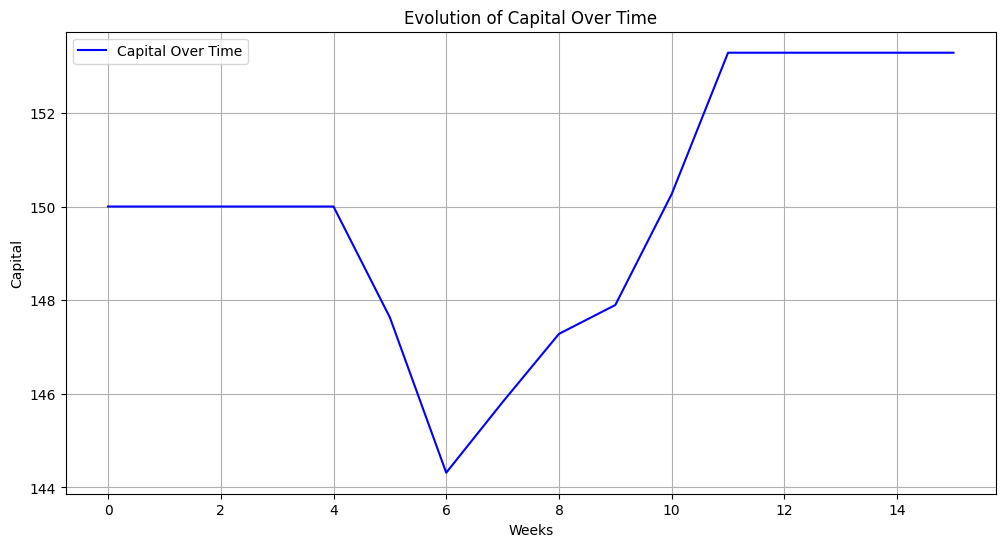

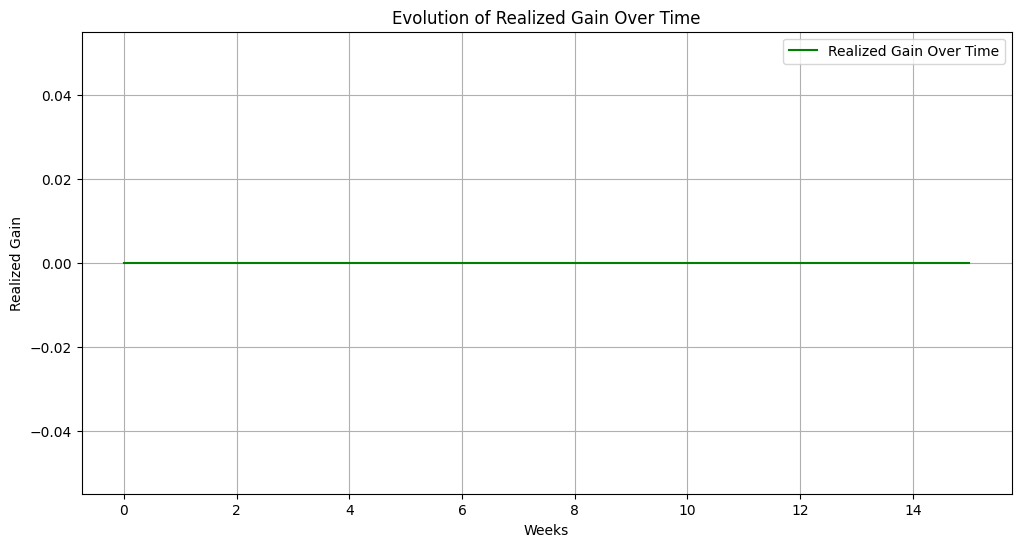

In [180]:
# Generate some sample data for the sake of demonstration
days = list(range(len(capital_over_time)))

# Plotting the evolution of capital over time
plt.figure(figsize=(12, 6))
plt.plot(days, capital_over_time, label="Capital Over Time", color='blue')
plt.xlabel("Weeks")
plt.ylabel("Capital")
plt.title("Evolution of Capital Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the evolution of realized gain over time
plt.figure(figsize=(12, 6))
plt.plot(days, realized_gain_over_time, label="Realized Gain Over Time", color='green')
plt.xlabel("Weeks")
plt.ylabel("Realized Gain")
plt.title("Evolution of Realized Gain Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [181]:
# Calculate the absolute and percentage gain/loss

initial_capital = capital_over_time[0]

final_capital = capital_over_time[-1]



absolute_gain_loss = final_capital - initial_capital

percentage_gain_loss = ((final_capital - initial_capital) / initial_capital) * 100



# Calculate volatility as the standard deviation of the returns

returns = np.diff(np.array(capital_over_time)) / np.array(capital_over_time)[:-1]

volatility = np.std(returns)

print(f"Gain/perte absolu sur {len(capital_over_time)*5 -1} jours : {absolute_gain_loss}")
print(f"Gain/perte en % sur {len(capital_over_time)*5 -1} jours : {percentage_gain_loss}")
print(f"Volatilité de l'indice sur {len(capital_over_time)*5 -1} jours : {volatility}")

annualized_return_percentage = ((1 + percentage_gain_loss/100) ** (252 / len(capital_over_time)/5 -1) - 1) * 100

print(f"Taux gain/perte annualisé : {annualized_return_percentage}")

initial_market_price = inverse_real_values_close[0]
final_market_price = inverse_real_values_close[len(capital_over_time)*5 -1]
market_return = (final_market_price - initial_market_price) / initial_market_price * 100

# Calculate if we beat the market
beat_the_market = percentage_gain_loss > market_return

print(f"Rendement du marché en % sur {len(capital_over_time)*5 - 1} jours : {market_return}")
print(f"Est-ce que nous avons battu le marché ? {'Oui' if beat_the_market else 'Non'} : {market_return:.2f} % {'<' if beat_the_market else '>'} {percentage_gain_loss:.2f} %")

Gain/perte absolu sur 79 jours : 3.283884155120063
Gain/perte en % sur 79 jours : 2.189256103413375
Volatilité de l'indice sur 79 jours : 0.01035018730119776
Taux gain/perte annualisé : 4.7662166941584205
Rendement du marché en % sur 79 jours : -0.24889175798128066
Est-ce que nous avons battu le marché ? Oui : -0.25 % < 2.19 %


In [182]:
# Calcul du ratio de Sharpe
mean_return = np.mean(np.diff(inverse_real_values_close) / inverse_real_values_close[:-1])
sharpe_ratio = mean_return / np.std(np.diff(inverse_real_values_close) / inverse_real_values_close[:-1])

print(f"Ratio de Sharpe: {sharpe_ratio}")

Ratio de Sharpe: 0.024230058456328946


## Conclusion

In [185]:
def calculate_directional_accuracy(real_values, predicted_values):
    correct_directions = 0
    total_directions = 0
    
    #fenêtre glissante sur 10 jours (2 semaines, du lundi au vendredi)
    for i in range(0, len(predicted_values), 5): #first cycle of 5 never used
        real_diff = real_values[i] - real_values[i-5]
        predicted_diff = predicted_values[i] - predicted_values[i-5]

        if (real_diff > 0 and predicted_diff > 0) or (real_diff < 0 and predicted_diff < 0):
            correct_directions += 1
        else: 
            print(f"Variation entre n°{i} et n°{i+5} fausse")

        total_directions += 1

    directional_accuracy = (correct_directions / total_directions) * 100
    return directional_accuracy

directional_accuracy = calculate_directional_accuracy(inverse_real_values_close, inverse_final_predictions_close)
print(f"Précision directionnelle sur 1 semaine: {directional_accuracy:.2f}%")

Variation entre n°0 et n°5 fausse
Variation entre n°25 et n°30 fausse
Variation entre n°30 et n°35 fausse
Variation entre n°55 et n°60 fausse
Variation entre n°60 et n°65 fausse
Variation entre n°75 et n°80 fausse
Précision directionnelle sur 1 semaine: 62.50%


Les résultats sont très encourageants, un investissement naïf au jour 0 aurait conduit à une perte de capital à j + 80

Les prédictions semblent satisfaisantes dans la mesure où nous battons le marché sur cette période et ce, même si le taux de gain est faible (dû à un actif très peu volatile sur la période)

Quelques points et améliorations cependant à soulever :

- Les prédictions des features autres que la valeur de l'indice lui-même ne sont disponibles que pour la valeur de clôture (et pas d'ouverture, pour l'ouverture on utilise donc la dernière valeur connue), la précision pour les modèles des features ainsi que le modèle final peut donc être encore augmenté.


- Toute la partie sur la simulation de gain/perte suppose que ce notebook n'est jamais réexécuté pendant 80 jours, or, dans les faits, prédire à nouveau la valeur de l'indice avec les nouvelles valeurs réelles augmentera les chances de corriger les prédictions directionnelles fausses à plus long terme.


- Les performances passées ne préjugent pas des performances futures, c'est valable pour un fonds investi en actions tout comme les performances de ce notebook, prenez du recul sur les résultats produits par ce dernier s'il a une quelconque influence sur vos investissements.
